In [1]:
from openai import OpenAI
import json, os, sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Load answers

In [2]:
source_filename = "../data/processed/UN_data.json"
des_filename = "../data/processed/UN_data_with_narrative_answers.json"

# Load articles
with open(source_filename, 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Load questions
with open('../data/processed/narrative_questions.json', 'r', encoding='utf-8') as f:
    questions = json.load(f)

#print number of questions
print("Number of questions:", len(questions))

# Set API key
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

Number of questions: 6


In [3]:
def get_answers(article, questions, model):
    article_content = article.get('text')
    print(f"Proceeding article")
    pre = "You are an AI trained to understand speeches and generate concise answers to multiple-choice questions based on the content. \
        Please read the following speech carefully. After reading, answer ALL the questions listed below. \
            Your answers must be in capital letters and formatted as a single string, where each question number is followed by its corresponding answer letter. \
                Separate each question-answer pair with a semicolon. \
                    Example format: 1A;2B;3C;4D;... \n\n"

    prompt = pre + f"Speech Content:\n{article_content}\n\n Questions: {questions}\n"
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
    except Exception as e:
        print(f"Error: {e}")
    return response

In [ ]:
def convert_string_to_dict(answer_string):
    if answer_string == "":
        return {}
    if answer_string[-1] == ';':
        answer_string = answer_string[:-1]
    return {item[:-1]: item[-1] for item in answer_string.split(';')}

results = []
iteration = 0
max_iteration = len(articles)

for article in articles:

    answers = get_answers(article, questions, model="gpt-4o")

    pure_answers = answers.choices[0].message.content
    print(pure_answers)

    # convert string to dictionary 1A;2B;3C;44D to {'1': 'A', '2': 'B', '3': 'C', '44': 'D'}
    processed_answers = convert_string_to_dict(pure_answers)
    article['Narrative_answers']= processed_answers

    results.append(article)
    iteration += 1

# Save results to a JSON file
with open(des_filename, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

In [4]:
updated_json = "../data/processed/UN_data_with_narrative_answers.json"
with open(updated_json, 'r', encoding='utf-8') as f:
    articles = json.load(f)

len(articles)

1138

In [5]:
#give each article a unique number from 0 to 1137 and update the json
for i, article in enumerate(articles):
    article['id'] = i

with open(updated_json, 'w', encoding='utf-8') as f:
    json.dump(articles, f, ensure_ascii=False, indent=4)

# Load articles
with open(updated_json, 'r', encoding='utf-8') as f:
    articles = json.load(f)

In [6]:
# Load articles
with open(updated_json, 'r', encoding='utf-8') as f:
    articles = json.load(f)

In [7]:
def check_narrative_format(narrative_answers):
    expected_keys = {"1", "2", "3", "4", "5", "6"}
    # Check if the keys match the expected format
    if isinstance(narrative_answers, dict):
        return set(narrative_answers.keys()) == expected_keys
    return False

# Iterate through articles and print session number and country if format doesn't match
for article in articles:
    narrative_answers = article.get("Narrative_answers", {})
    session_number = article.get("id", "N/A")
    country = article.get("country", "N/A")
    if not check_narrative_format(narrative_answers):
        print(f"Session Number: {session_number}, Country: {country}")

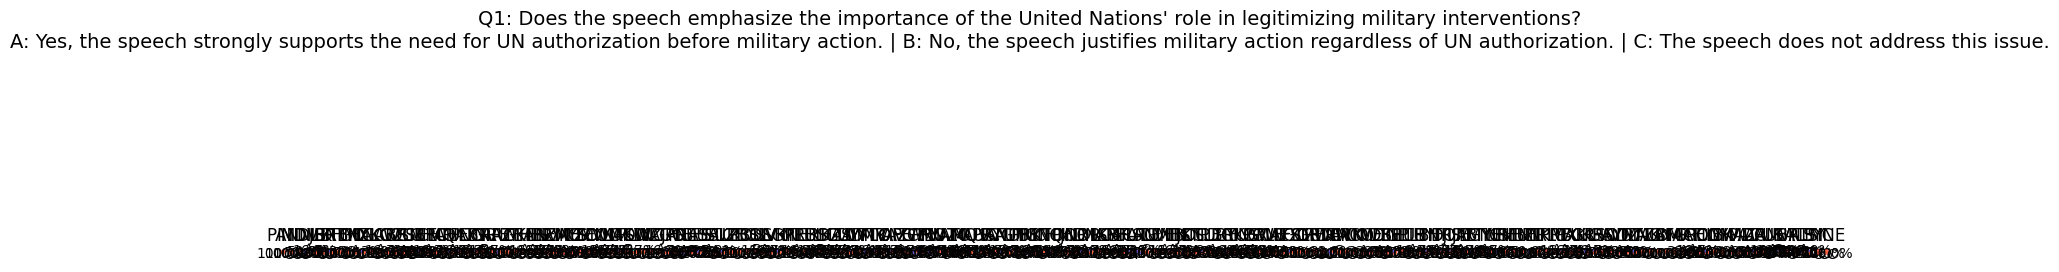

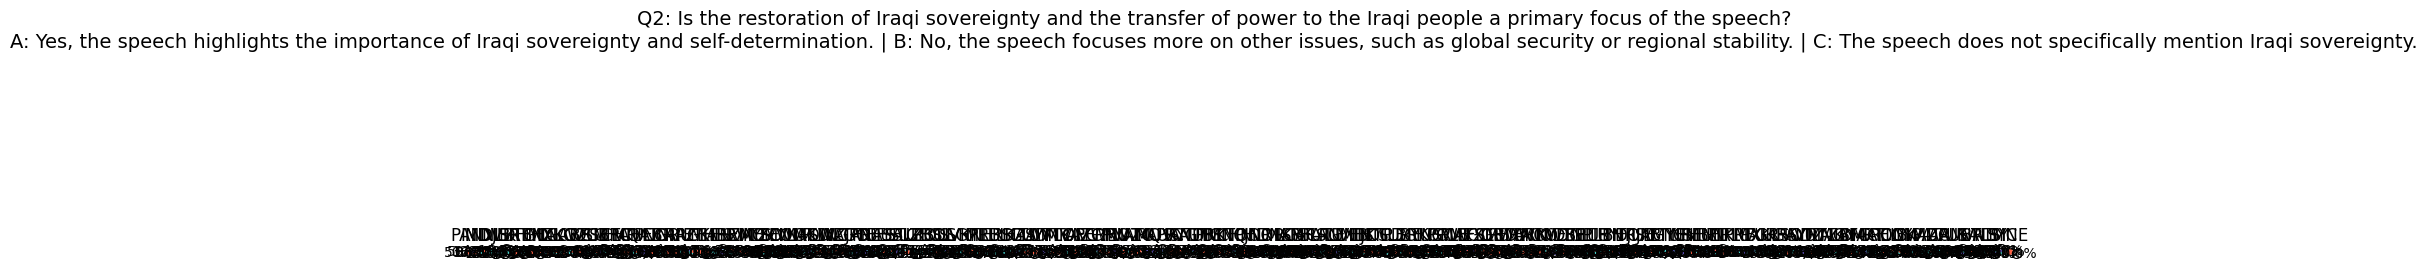

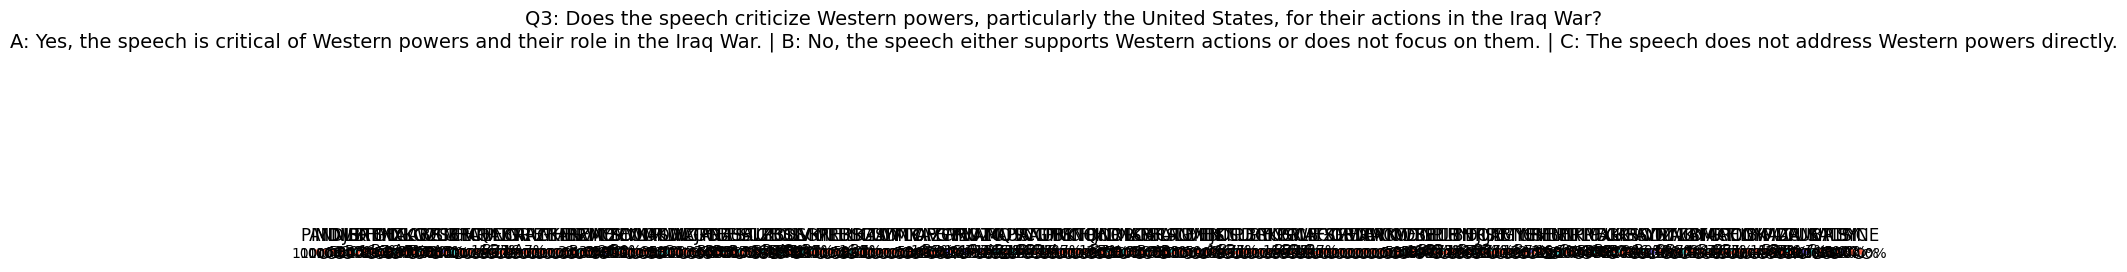

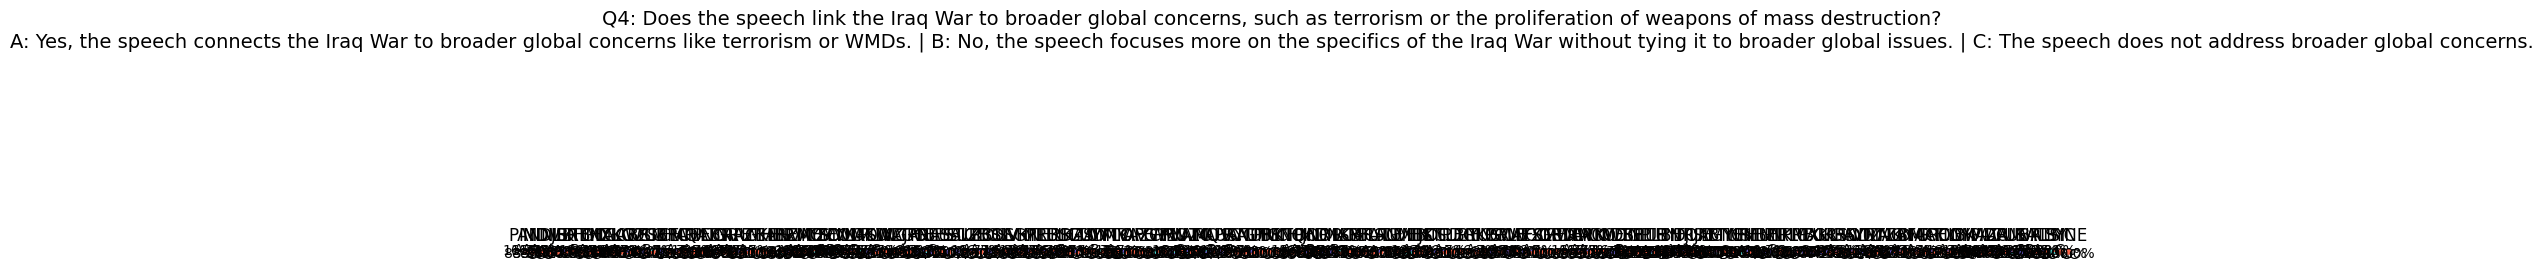

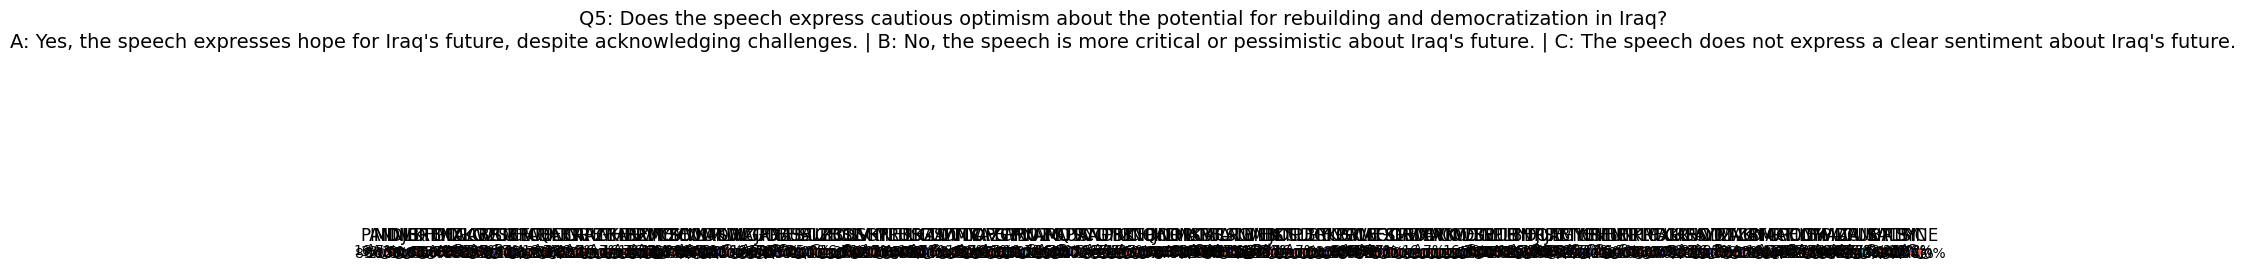

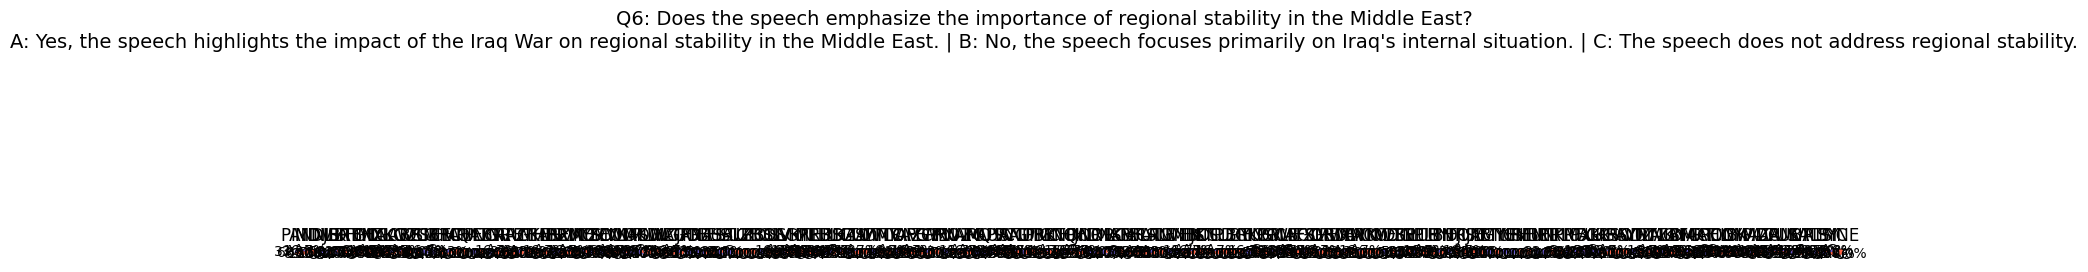

In [141]:
# Load the data and questions JSON

questions_data = {
    "Q1": {
        "question": "Does the speech emphasize the importance of the United Nations' role in legitimizing military interventions?",
        "choices": {
            "A": "Yes, the speech strongly supports the need for UN authorization before military action.",
            "B": "No, the speech justifies military action regardless of UN authorization.",
            "C": "The speech does not address this issue."
        }
    },
    "Q2": {
        "question": "Is the restoration of Iraqi sovereignty and the transfer of power to the Iraqi people a primary focus of the speech?",
        "choices": {
            "A": "Yes, the speech highlights the importance of Iraqi sovereignty and self-determination.",
            "B": "No, the speech focuses more on other issues, such as global security or regional stability.",
            "C": "The speech does not specifically mention Iraqi sovereignty."
        }
    },
    "Q3": {
        "question": "Does the speech criticize Western powers, particularly the United States, for their actions in the Iraq War?",
        "choices": {
            "A": "Yes, the speech is critical of Western powers and their role in the Iraq War.",
            "B": "No, the speech either supports Western actions or does not focus on them.",
            "C": "The speech does not address Western powers directly."
        }
    },
    "Q4": {
        "question": "Does the speech link the Iraq War to broader global concerns, such as terrorism or the proliferation of weapons of mass destruction?",
        "choices": {
            "A": "Yes, the speech connects the Iraq War to broader global concerns like terrorism or WMDs.",
            "B": "No, the speech focuses more on the specifics of the Iraq War without tying it to broader global issues.",
            "C": "The speech does not address broader global concerns."
        }
    },
    "Q5": {
        "question": "Does the speech express cautious optimism about the potential for rebuilding and democratization in Iraq?",
        "choices": {
            "A": "Yes, the speech expresses hope for Iraq's future, despite acknowledging challenges.",
            "B": "No, the speech is more critical or pessimistic about Iraq's future.",
            "C": "The speech does not express a clear sentiment about Iraq's future."
        }
    },
    "Q6": {
        "question": "Does the speech emphasize the importance of regional stability in the Middle East?",
        "choices": {
            "A": "Yes, the speech highlights the impact of the Iraq War on regional stability in the Middle East.",
            "B": "No, the speech focuses primarily on Iraq's internal situation.",
            "C": "The speech does not address regional stability."
        }
    }
}

# Convert the JSON data to a DataFrame
df = pd.DataFrame(articles)

# List of unique questions based on the question format in the `questions_data` dictionary
questions = questions_data.keys()

# List of countries
countries = df['country'].unique()

# Define a color map for the options A, B, C with dimmer colors
color_map = {'A': '#6A5ACD', 'B': '#48D1CC', 'C': '#FF6347'}

# Custom function to format the percentage display
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%' if pct > 0 else ''
    return my_format

# Iterate through each question
for question in questions:
    fig, axes = plt.subplots(1, len(countries), figsize=(20, 5), subplot_kw={'aspect': 'equal'})
    
    # Retrieve question text and options
    question_text = questions_data[question]['question']
    choices = questions_data[question]['choices']
    
    # Create the title including question and options
    title = f"{question}: {question_text}\n"
    title += f"A: {choices['A']} | B: {choices['B']} | C: {choices['C']}"
    
    fig.suptitle(title, fontsize=14)
    
    # Iterate through each country and plot its pie chart
    for i, country in enumerate(countries):
        # Filter the DataFrame for the current country
        country_data = df[df['country'] == country]
        
        # Get the answer for the current question and count occurrences
        answer_counts = country_data['Narrative_answers'].apply(lambda x: x[question[-1]]).value_counts()
        
        # Sort the answer_counts to ensure the order of A, B, C
        answer_counts = answer_counts.reindex(['A', 'B', 'C'], fill_value=0)
        
        # Get colors for the current pie chart
        colors = [color_map[option] for option in answer_counts.index]
        
        # Filter out labels with 0% to avoid displaying them
        labels = [f'{idx}' if value > 0 else '' for idx, value in zip(answer_counts.index, answer_counts.values)]
        
        # Plot the pie chart
        axes[i].pie(answer_counts, labels=labels, colors=colors, 
                    autopct=autopct_format(answer_counts), startangle=90)
        axes[i].set_title(country)
    
    plt.show()


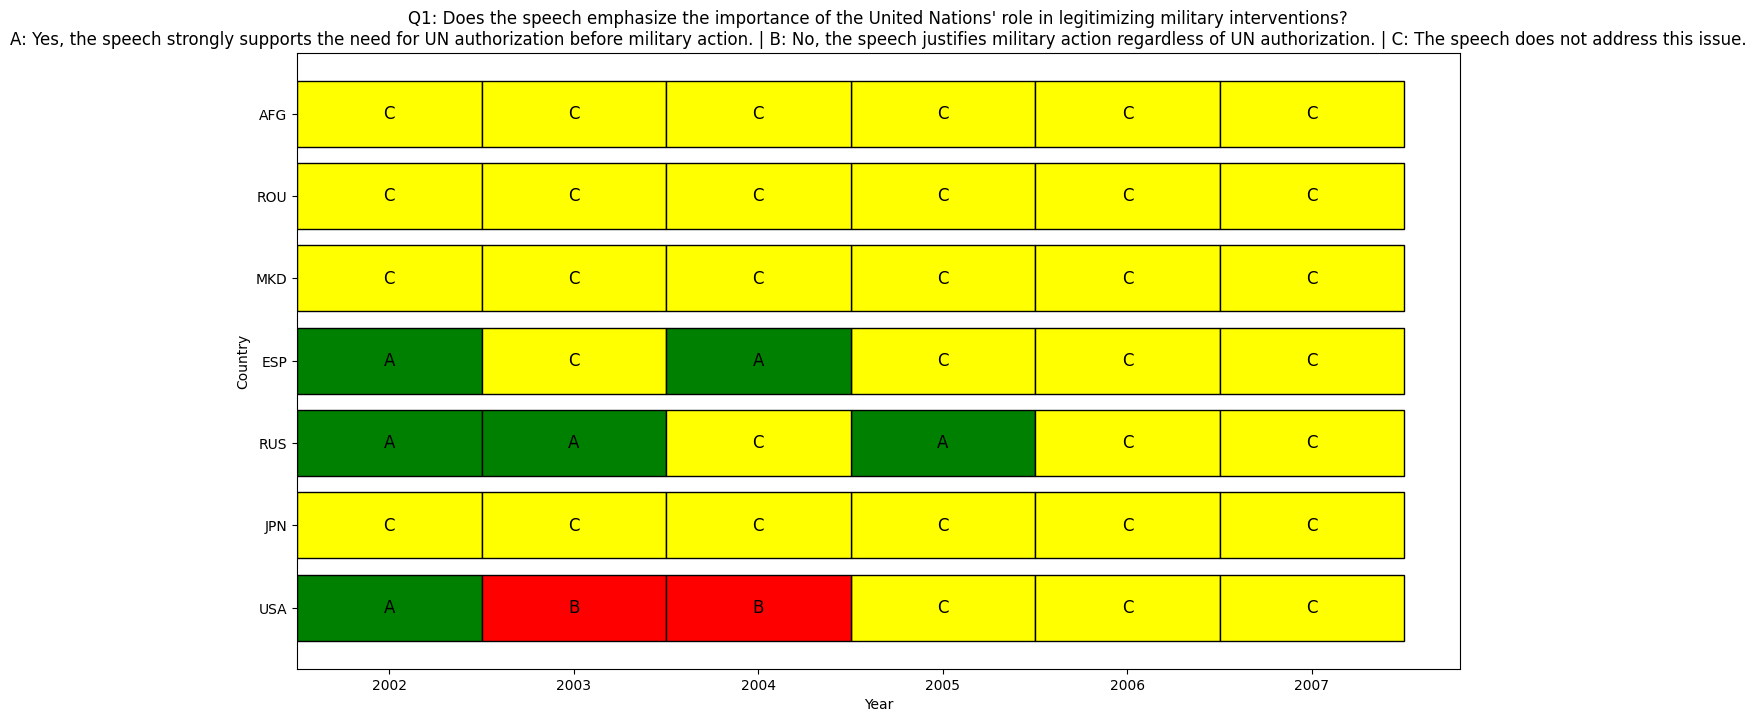

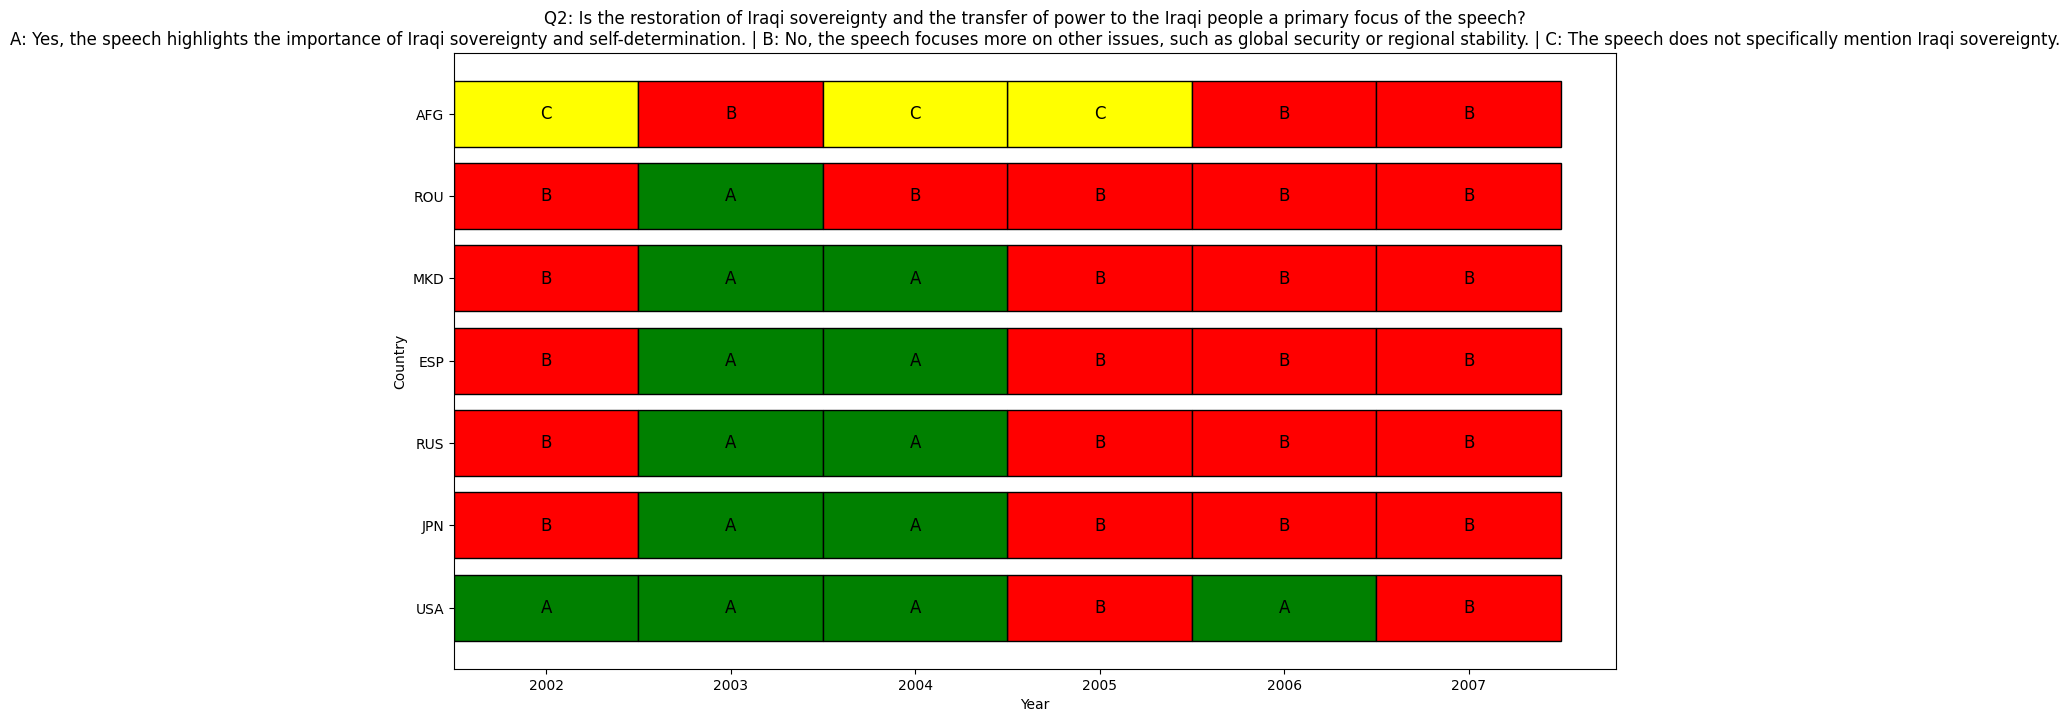

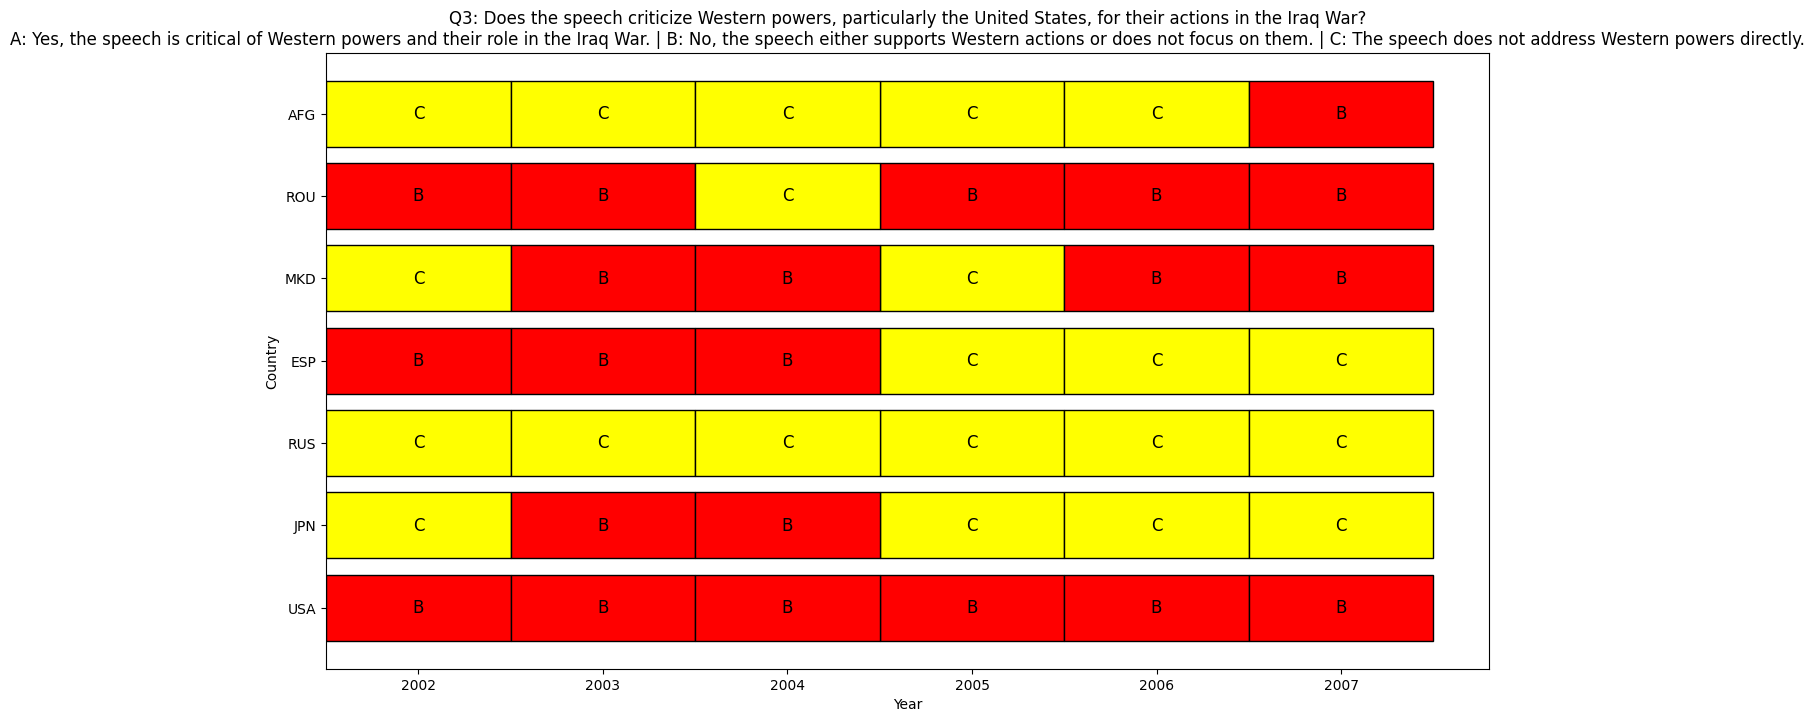

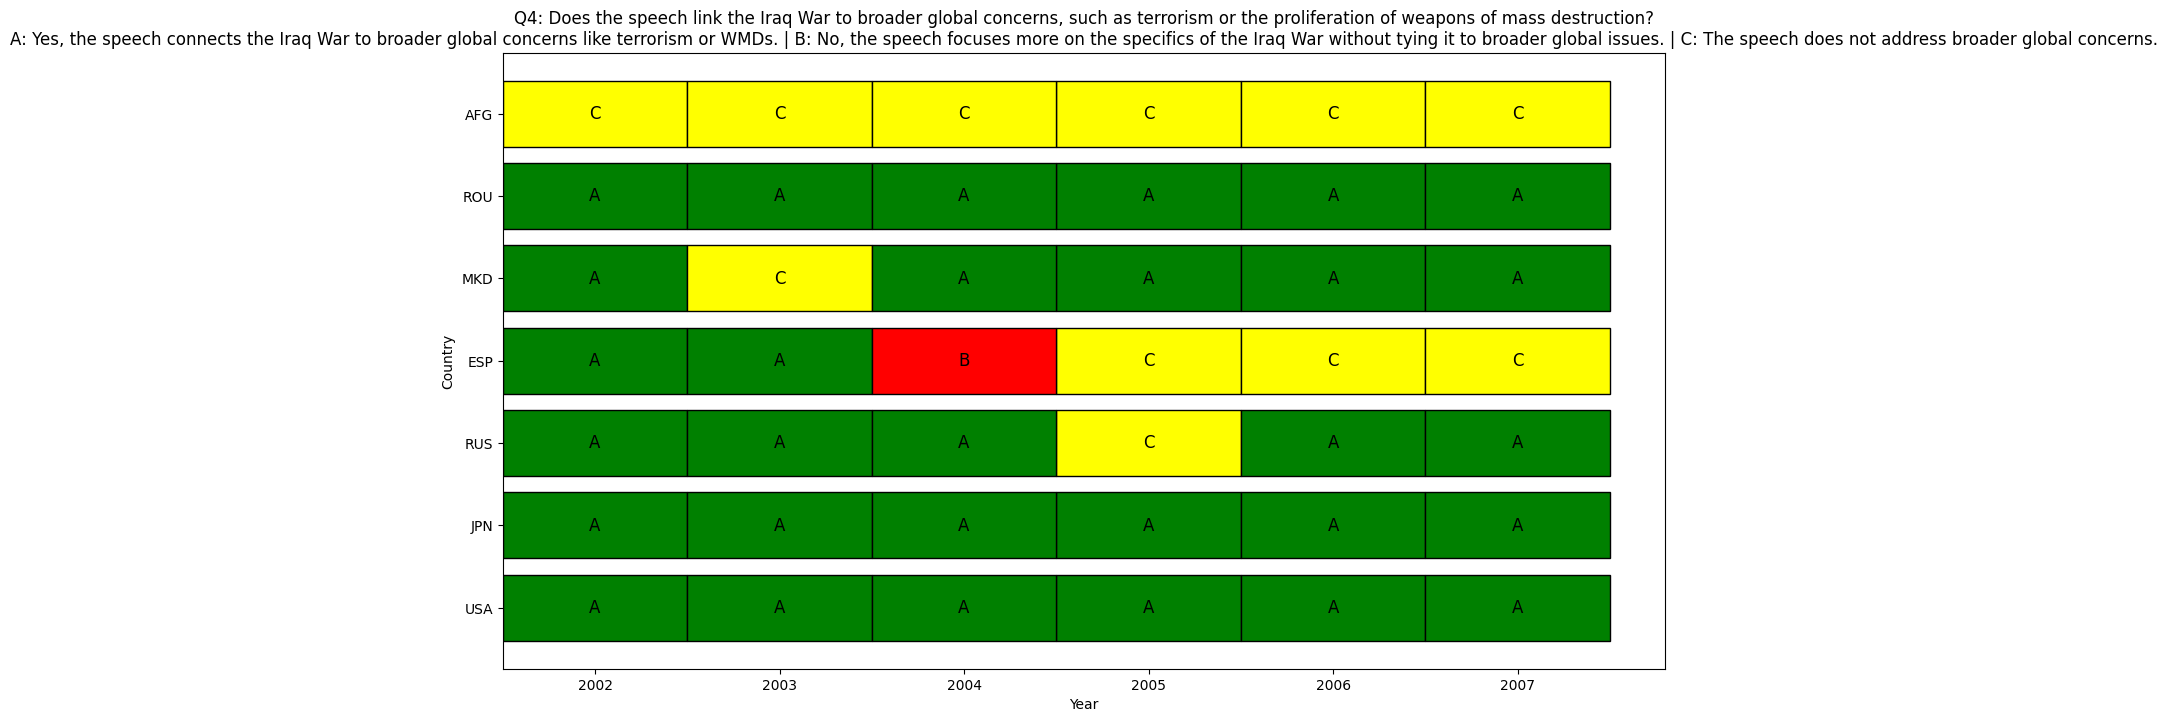

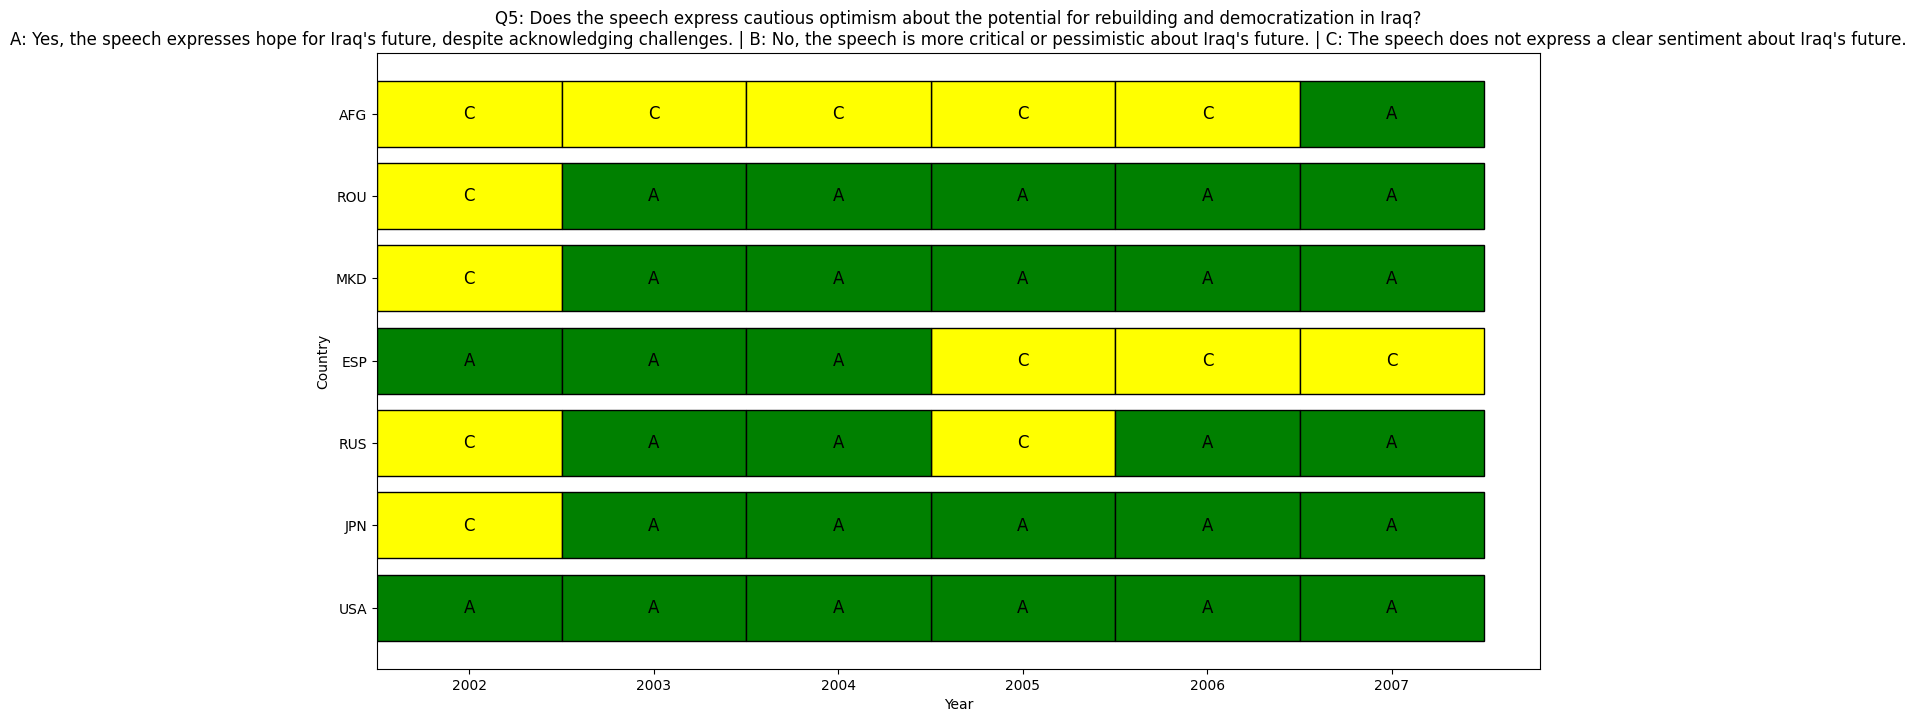

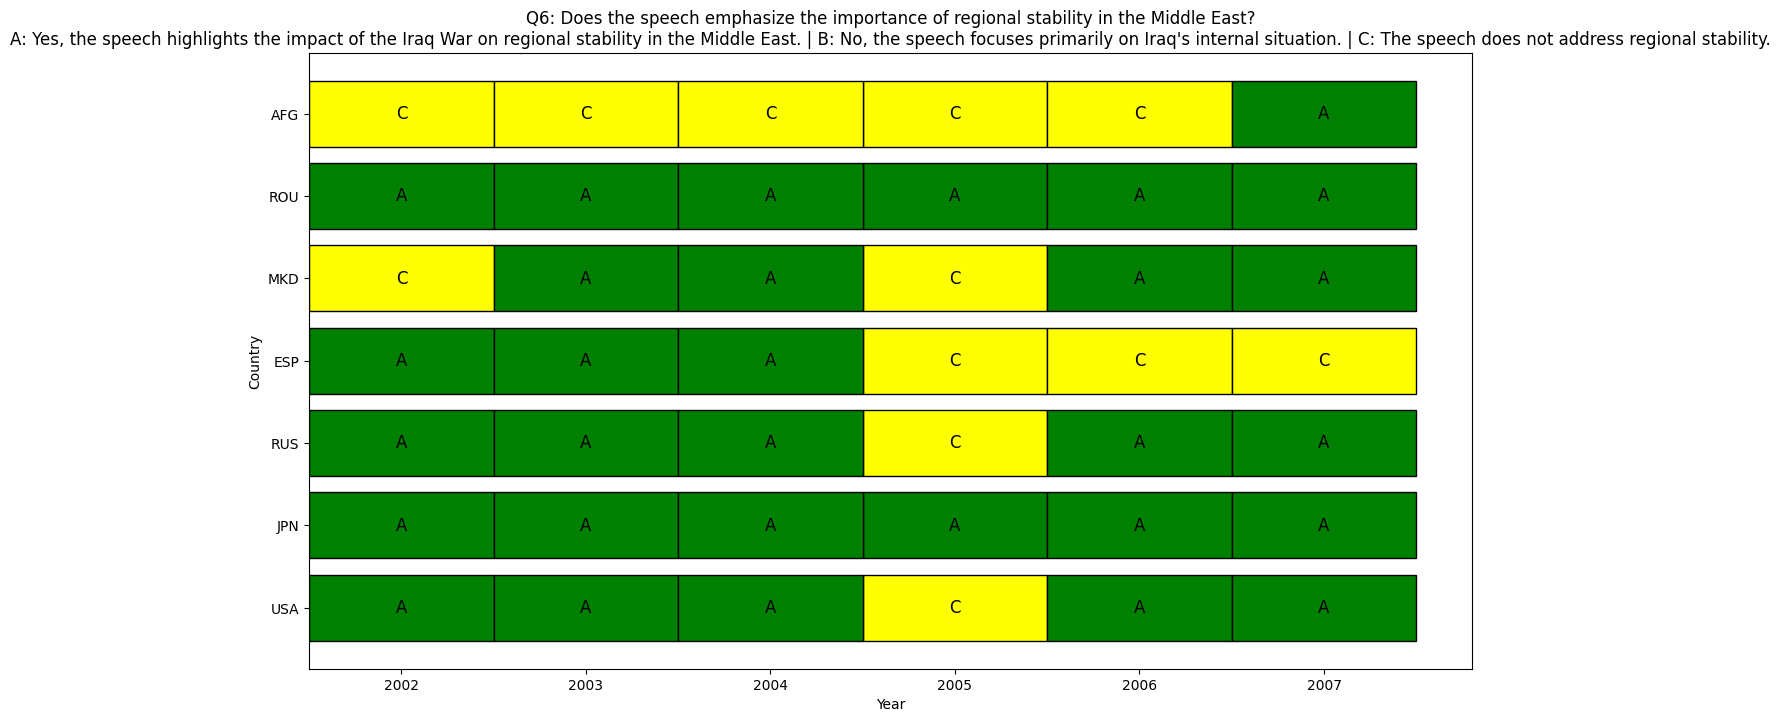

In [142]:
# Define color mapping for options
color_map = {'A': 'green', 'B': 'red', 'C': 'yellow'}

# List of unique questions
questions = list(questions_data.keys())

# List of unique countries
countries = ['USA', 'JPN', 'RUS','ESP','MKD','ROU','AFG']

# Iterate over each question
for question in questions:
    plt.figure(figsize=(15, 8))
    
    # Set up the y-ticks (countries)
    y_pos = np.arange(len(countries))
    
    # Iterate over each year
    for year in df['year'].unique():
        # Filter data for the current year
        year_data = df[df['year'] == year]
        
        # Get the answer counts for each country for the current question
        answers = year_data['Narrative_answers'].apply(lambda x: x[question[-1]])
        
        # Plot bars for each country based on the answers
        for i, country in enumerate(countries):
            if country in year_data['country'].values:
                country_answer = answers[year_data['country'] == country].values[0]
                plt.barh(i, 1, left=year - 0.5, color=color_map[country_answer], edgecolor='black')
                plt.text(year, i, country_answer, va='center', ha='center', color='black', fontsize=12)
    
    # Set x and y axis labels
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.yticks(y_pos, countries)
    plt.xticks(np.arange(df['year'].min(), df['year'].max() + 1))
    
    # Retrieve question text and options
    question_text = questions_data[question]['question']
    choices = questions_data[question]['choices']
    
    # Create the title including question and options
    title = f"{question}: {question_text}\n"
    title += f"A: {choices['A']} | B: {choices['B']} | C: {choices['C']}"
    
    # Set the title to the current question with options
    plt.title(title, fontsize=12)
    
    # Show the plot
    plt.show()

### 0: China
### 1: France
### 2: UK
### 3: India
### 4: Iran
### 5: Iraq
### 6: Saudi Arabia
### 7: USA

In [52]:
with open("../data/processed/UN_data_with_narrative_answers_relevant.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
labels = df['label'].to_list()

(38, 3)


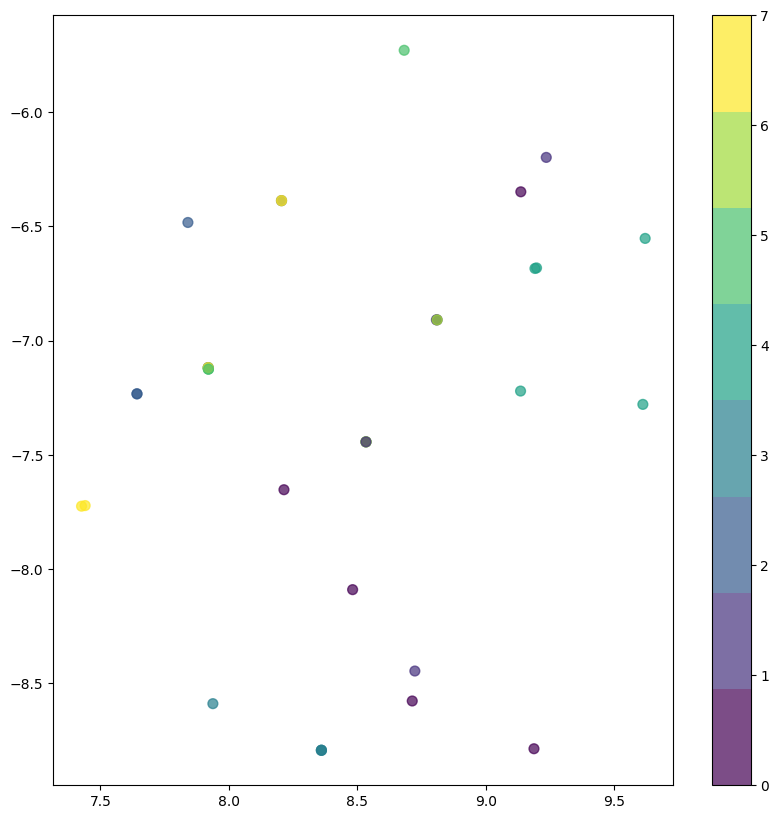

In [53]:
# Load the latent vectors
df_vectors = pd.read_csv("../data/processed/latent_vector_3.csv", header=None)
data_vectors = df_vectors.values
print(data_vectors.shape)

# Check the number of samples
n_samples = data_vectors.shape[0]

# Set the perplexity parameter to be less than the number of samples
perplexity = min(30, n_samples - 1)

# Apply TSNE to reduce the dimensions to 2D
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
v_2d = tsne.fit_transform(data_vectors)

# Create a scatter plot with different colors for each label
plt.figure(figsize=(10, 10))

# Define a colormap for 7 distinct labels (0-6)
colors = plt.get_cmap('viridis', 8)

# Plot the 2D embeddings
sc = plt.scatter(v_2d[:, 0], v_2d[:, 1], c=labels, cmap=colors, s=50, alpha=0.7)

# Adding a colorbar and adjusting to show the range of labels
cbar = plt.colorbar(sc)
cbar.set_ticks(np.arange(0, 8))
cbar.set_ticklabels(np.arange(0, 8))

plt.show()

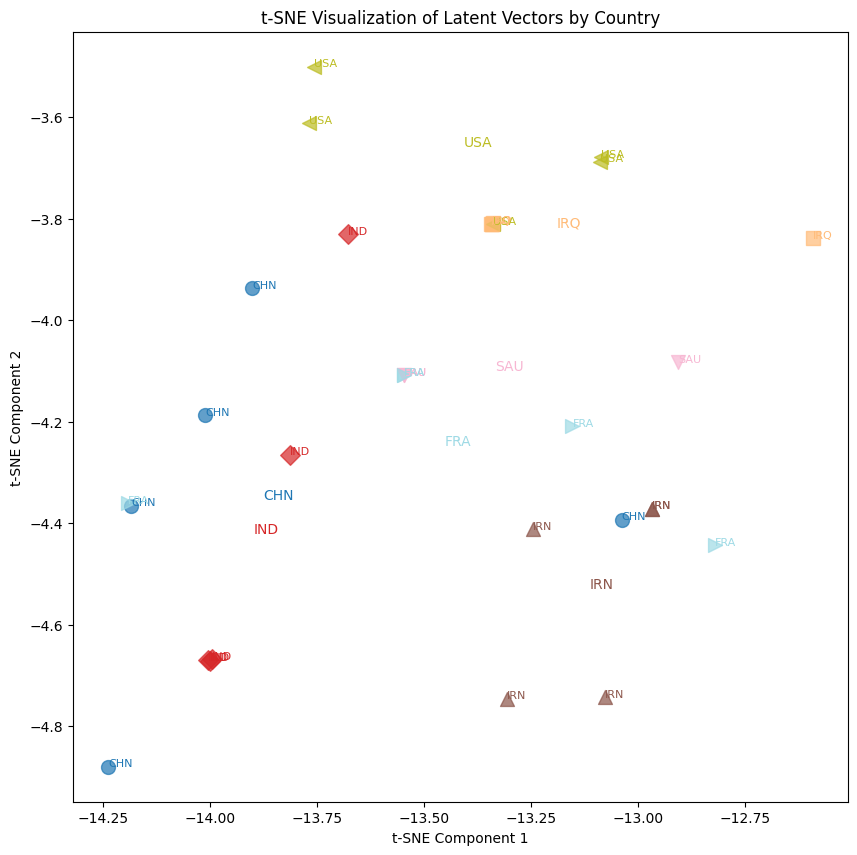

In [43]:
# Load the latent vectors
df_vectors = pd.read_csv("../data/processed/latent_vector_3.csv", header=None)
data_vectors = df_vectors.values

# Load the labels (assuming they are country names)
with open("../data/processed/UN_data_with_narrative_answers.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
labels = df['country'].to_list()
countries = df['country'].to_list()

# Check for consistency in lengths
if len(data_vectors) != len(labels):
    raise ValueError("Mismatch between the number of data points and labels")

# Check the number of samples
n_samples = data_vectors.shape[0]

# Set the perplexity parameter to be less than the number of samples
perplexity = min(30, n_samples - 1)

# Apply TSNE to reduce the dimensions to 2D
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
v_2d = tsne.fit_transform(data_vectors)

# Create a scatter plot with different marker shapes for each country
plt.figure(figsize=(10, 10))

# Define a list of markers and colors to use for different countries
markers = ['o', 's', 'D', '^', 'v', '<', '>']  # Add more if necessary
unique_labels = list(set(labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))  # Define a color map

# Create a dictionary mapping each unique label to a specific marker and color
marker_map = {label: markers[i % len(markers)] for i, label in enumerate(unique_labels)}
color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# Plot each point with the corresponding marker, color, and label
for i in range(len(v_2d)):
    x, y = v_2d[i]
    plt.scatter(x, y, marker=marker_map[labels[i]], color=color_map[labels[i]], s=100, alpha=0.7)
    plt.text(x, y, countries[i], fontsize=8, color=color_map[labels[i]])

# Handle overlapping labels by concatenating them
for label in unique_labels:
    x_coords = [v_2d[i][0] for i in range(len(v_2d)) if labels[i] == label]
    y_coords = [v_2d[i][1] for i in range(len(v_2d)) if labels[i] == label]
    plt.text(np.mean(x_coords), np.mean(y_coords), ', '.join(set([countries[i] for i in range(len(v_2d)) if labels[i] == label])), fontsize=10, color=color_map[label], bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Display the plot
plt.title("t-SNE Visualization of Latent Vectors by Country")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


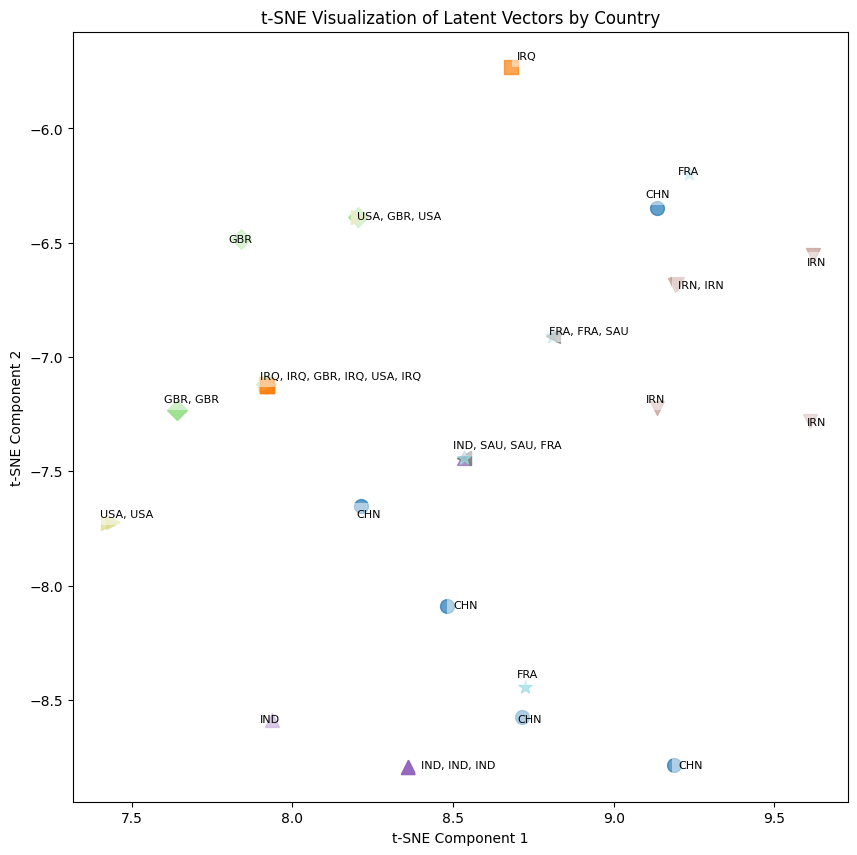

In [54]:
# Load the latent vectors
df_vectors = pd.read_csv("../data/processed/latent_vector_3.csv", header=None)
data_vectors = df_vectors.values

# Load the labels (assuming they are country names)
with open("../data/processed/UN_data_with_narrative_answers.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
labels = df['country'].to_list()
countries = df['country'].to_list()

# Check for consistency in lengths
if len(data_vectors) != len(labels):
    raise ValueError("Mismatch between the number of data points and labels")

# Check the number of samples
n_samples = data_vectors.shape[0]

# Set the perplexity parameter to be less than the number of samples
perplexity = min(30, n_samples - 1)

# Apply TSNE to reduce the dimensions to 2D
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
v_2d = tsne.fit_transform(data_vectors)

# Create a scatter plot with different marker shapes for each country
plt.figure(figsize=(10, 10))

# Define a list of markers and colors to use for different countries
markers = ['o', 's', 'D', '^', 'v', '<', '>','*']  # Add more if necessary
unique_labels = list(set(labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))  # Define a color map

# Create a dictionary mapping each unique label to a specific marker and color
marker_map = {label: markers[i % len(markers)] for i, label in enumerate(unique_labels)}
color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# Create a dictionary to hold positions and their respective country labels
position_labels = {}

# Plot each point with the corresponding marker, color, and label
for i in range(len(v_2d)):
    x, y = v_2d[i]
    plt.scatter(x, y, marker=marker_map[labels[i]], color=color_map[labels[i]], s=100, alpha=0.7)
    
    # Group labels by their positions, rounded to avoid too many different groups
    rounded_pos = (round(x, 1), round(y, 1))
    if rounded_pos not in position_labels:
        position_labels[rounded_pos] = []
    position_labels[rounded_pos].append(countries[i])

# Add labels to the plot, separating them by commas for overlapping points
for pos, country_list in position_labels.items():
    x, y = pos
    label = ', '.join(country_list)
    plt.text(x, y, label, fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Display the plot
plt.title("t-SNE Visualization of Latent Vectors by Country")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [110]:
with open("../data/processed/UN_data_with_narrative_answers_relevant.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
labels = df['country'].to_list()
countries = df['country'].to_list()
years = df['year'].to_list()

# Load the latent vectors
df_vectors = pd.read_csv("../data/processed/latent_vector_3_relevant.csv", header=None)

#add the year and countries column to the latent vectors
df_vectors['year'] = years
df_vectors['country'] = countries

df_vectors.head()


0         1         2  year country
0 -0.981812  0.637015 -0.419007  2002     PAN
1  0.883020  1.421178  1.110162  2002     DJI
2  0.461430 -1.527740  1.316927  2002     NLD
3 -0.042672 -1.250940  1.820795  2002     ISR
4 -1.442041  0.099308 -0.667775  2002     BRB

In [128]:
# Define the Euclidean distance function
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2)**2))

# Create a new column 'distance'
df_vectors['distance'] = np.nan

# Iterate over each row in the dataframe
for i, row in df_vectors.iterrows():
    # Get the current country's latent vector and year
    current_vector = row[[0, 1, 2]].values
    current_year = row['year']
    current_country = row['country']
    
    # Get the US vector for the same year
    us_vector = df_vectors[(df_vectors['year'] == current_year) & (df_vectors['country'] == 'USA')].iloc[0][[0, 1, 2]].values
    
    # Calculate the Euclidean distance and assign it to the 'distance' column
    #df_vectors.at[i, 'distance'] = euclidean_distance(current_vector, us_vector)
    distance = euclidean_distance(current_vector, us_vector)
    
    # Assign the distance to the DataFrame and format to avoid scientific notation
    df_vectors.at[i, 'distance'] = f'{distance:.10f}'
df_vectors


/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_50842/1212899531.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2348643422' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_vectors.at[i, 'distance'] = f'{distance:.10f}'


0         1         2  year country      distance
0   -0.981812  0.637015 -0.419007  2002     PAN  3.2348643422
1    0.883020  1.421178  1.110162  2002     DJI  3.5253509285
2    0.461430 -1.527740  1.316927  2002     NLD  0.9806542700
3   -0.042672 -1.250940  1.820795  2002     ISR  1.6723728034
4   -1.442041  0.099308 -0.667775  2002     BRB  3.1709675677
5    0.883019  1.421180  1.110162  2002     KHM  3.5253519917
6    0.141059 -0.734527 -0.122187  2002     THA  1.5092030839
7   -0.329441 -1.773595  1.365994  2002     NZL  1.3008988618
8   -1.364683  1.341613  2.441151  2002     NIC  4.3664235580
9   -0.329440 -1.773599  1.365992  2002     WSM  1.3008963499
10  -0.220633 -0.764756 -0.306722  2002     PSE  1.7085431065
11   0.174434 -1.900761  0.747236  2002     GBR  0.5118561032
12  -0.981813  0.637015 -0.419005  2002     CMR  3.2348643116
13  -3.187340  1.650538 -1.260499  2002     CHE  5.5651307382
14   1.282710  0.342808 -0.080558  2002     QAT  2.5421027372
15  -0.212493 -0.891424 -0.060034  2002     LBN  1.5058192121
16  -0.981830  0.636943 -0.419018  2002     CRI  3.2348158257
17   0.755528  0.953533  1.410293  2002     ARG  3.1333002774
18  -0.981857  0.636794 -0.418986  2002     AZE  3.2346973524
19   0.194814 -1.041886 -0.366852  2002     ARE  1.3728611676
20  -0.329433 -1.773580  1.366005  2002     HRV  1.3009037515
21  -3.187356  1.650524 -1.260515  2002     SVN  5.5651371564
22  -0.897428 -2.181616 -0.900200  2002     MYS  2.0447170019
23  -0.042672 -1.250949  1.820794  2002     CZE  1.6723675187
24   0.194813 -1.041885 -0.366852  2002     OMN  1.3728616516
25  -0.981809  0.636979 -0.418995  2002     COG  3.2348295924
26   0.883019  1.421179  1.110162  2002     VNM  3.5253514913
27  -0.220633 -0.764756 -0.306722  2002     LAO  1.7085432298
28  -1.364682  1.341613  2.441150  2002     MKD  4.3664228154
29  -4.327168 -2.512433 -0.266451  2002     PLW  5.0027798902
30   0.755520  0.953533  1.410308  2002     MLT  3.1333043562
31   0.883020  1.421179  1.110162  2002     NGA  3.5253513728
32  -0.981812  0.637010 -0.419007  2002     AGO  3.2348602307
33   0.755522  0.953522  1.410335  2002     JPN  3.1333022262
34   0.174435 -1.900764  0.747234  2002     FRA  0.5118533981
35  -0.329448 -1.773612  1.365980  2002     DEU  1.3008908366
36  -3.187362  1.650518 -1.260521  2002     BHS  5.5651396067
37  -2.112295 -0.356313  2.435679  2002     EST  3.7340048303
38   0.755514  0.953545  1.410294  2002     SAU  3.1333115106
39  -2.112295 -0.356313  2.435678  2002     UZB  3.7340041569
40  -0.981824  0.637030 -0.419020  2002     GEO  3.2348863478
41  -0.042672 -1.250940  1.820789  2002     ROU  1.6723679843
42  -1.442030  0.099316 -0.667765  2002     SVK  3.1709622157
43  -1.442038  0.099312 -0.667772  2002     SGP  3.1709666419
44  -0.981811  0.637012 -0.419007  2002     HTI  3.2348613741
45   2.040704  4.716489  1.113272  2002     MLI  6.9347261690
46  -3.187344  1.650535 -1.260502  2002     NER  5.5651326217
47  -0.212493 -0.891424 -0.060034  2002     RUS  1.5058191381
48  -1.364681  1.341612  2.441151  2002     BIH  4.3664222463
49   1.374317  0.305312  0.511405  2002     DZA  2.4687604029
50   3.313401  5.011605  3.356853  2002     SDN  8.0804900364
51  -2.112294 -0.356313  2.435680  2002     LVA  3.7340042129
52  -0.981825  0.636996 -0.419013  2002     PER  3.2348562082
53   0.305258 -0.884073 -0.691590  2002     IRN  1.6761087927
54  -0.981811  0.637016 -0.419007  2002     MOZ  3.2348644262
55  -0.212493 -0.891425 -0.060034  2002     NAM  1.5058184858
56   3.101326 -4.262711 -2.131384  2002     IRQ  4.2548421611
57  -0.981826  0.636946 -0.419011  2002     MUS  3.2348148646
58  -0.042677 -1.250946  1.820802  2002     AUS  1.6723777096
59   2.040705  4.716487  1.113274  2002     PRY  6.9347247207
60  -0.329442 -1.773598  1.365993  2002     VCT  1.3008981919
61  -1.979225 -1.304649  0.809020  2002     AND  2.6956351389
62  -0.329432 -1.773582  1.366005  2002     AUT  1.3009027813
63  -0.981808  0.636983 -0.419006  2002     

In [112]:
#add df_vectors to new csv file
df_vectors.to_csv("../data/processed/latent_vector_with_distance_relevant.csv", index=False)

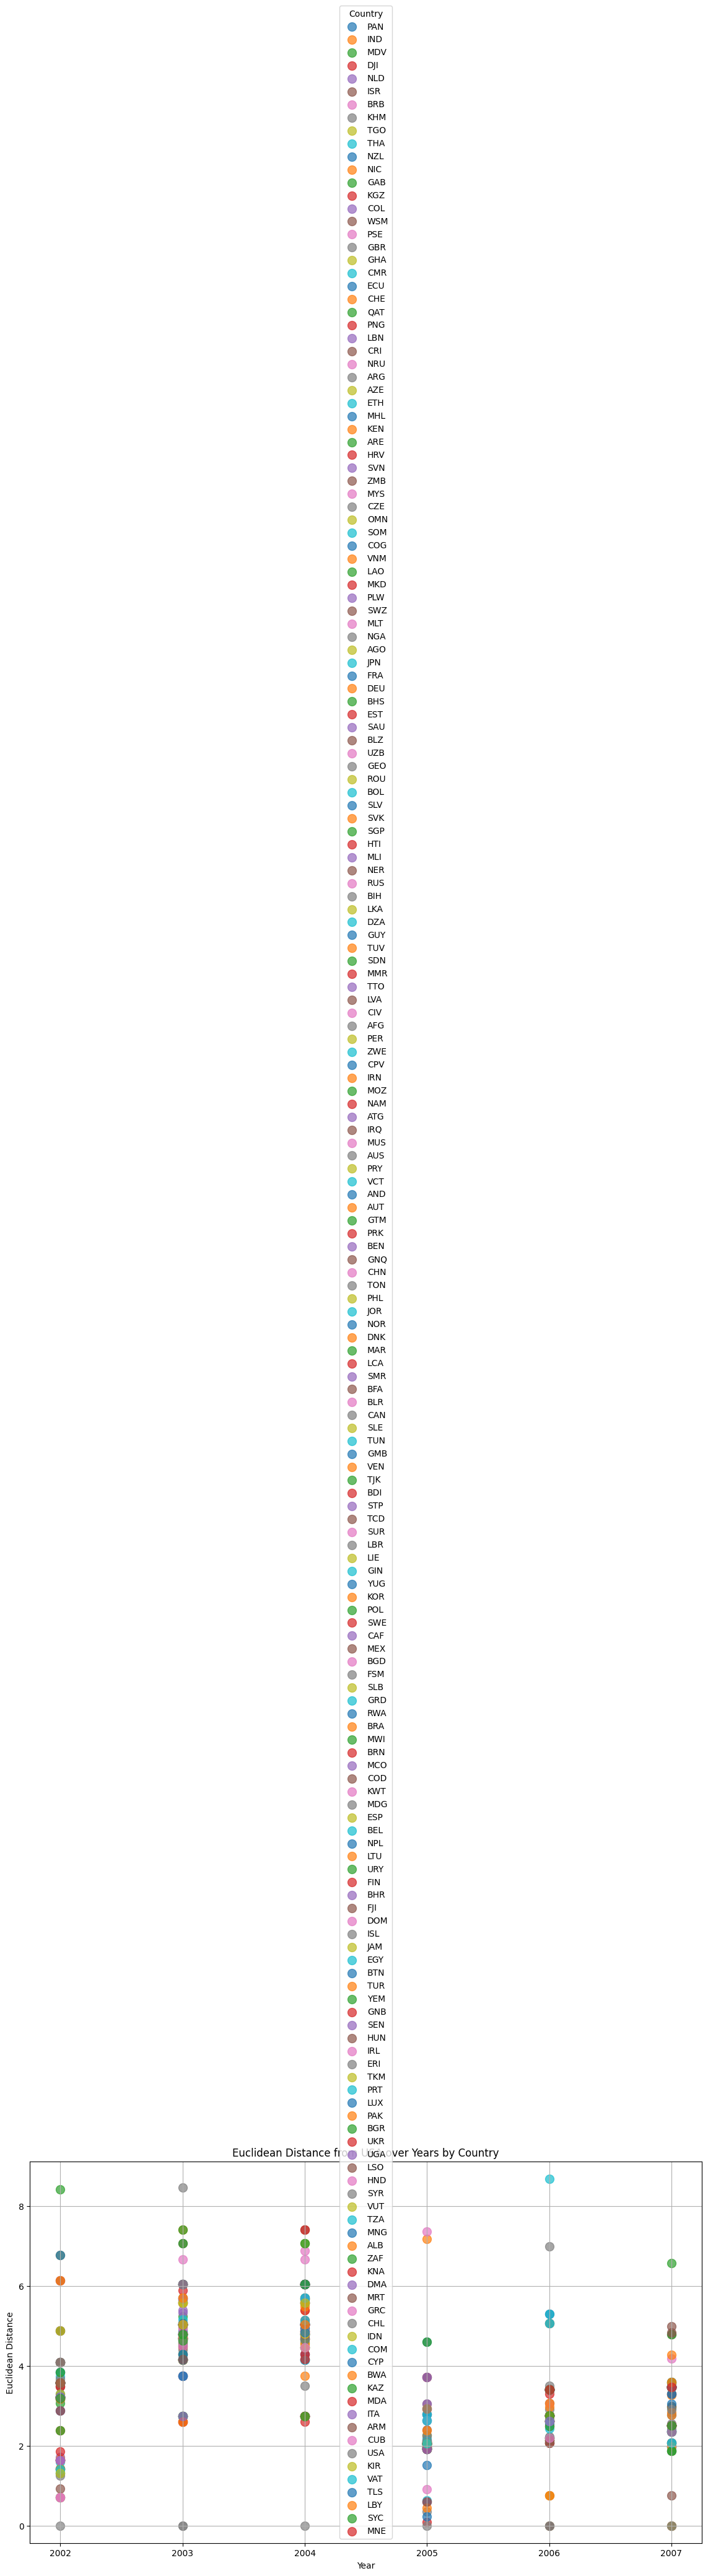

In [25]:
# Ensure the 'year' column is treated as a numerical value
df_vectors['year'] = pd.to_numeric(df['year'])

# List of unique countries
countries = df_vectors['country'].unique()

# Create scatter plots for each country
plt.figure(figsize=(14, 8))

for country in countries:
    # Filter the data for the current country
    country_data = df_vectors[df_vectors['country'] == country]
    
    # Create a scatter plot for the current country
    plt.scatter(country_data['year'], country_data['distance'], label=country, s=100, alpha=0.7)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance from USA over Years by Country')
plt.legend(title='Country')
plt.grid(True)

# Show the plot
plt.show()

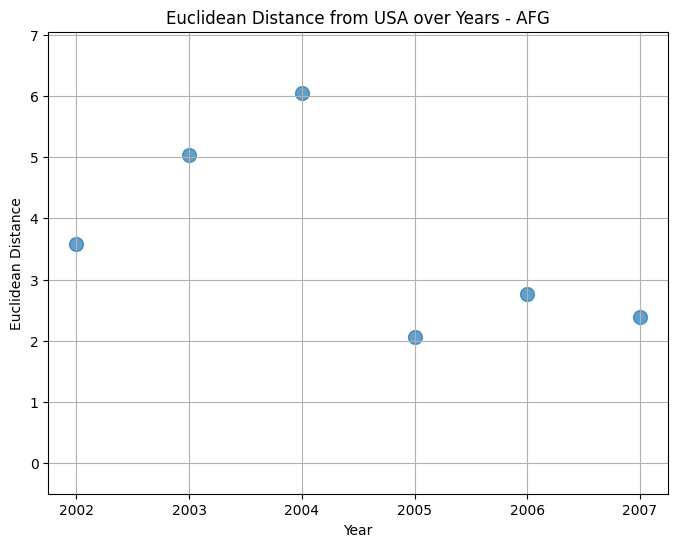

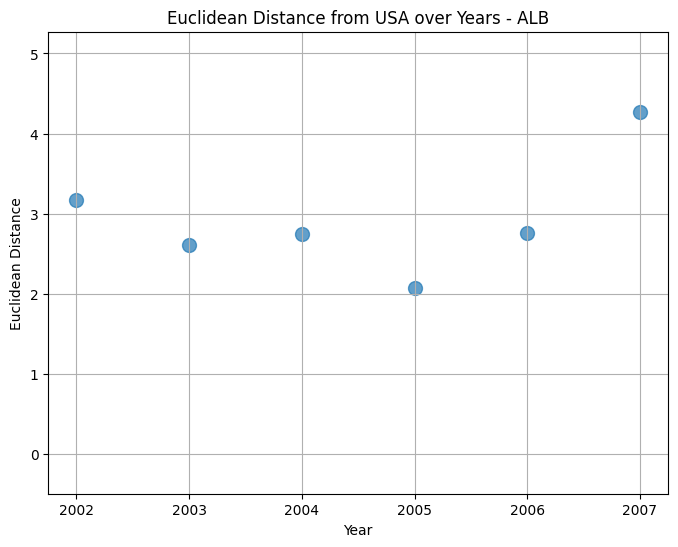

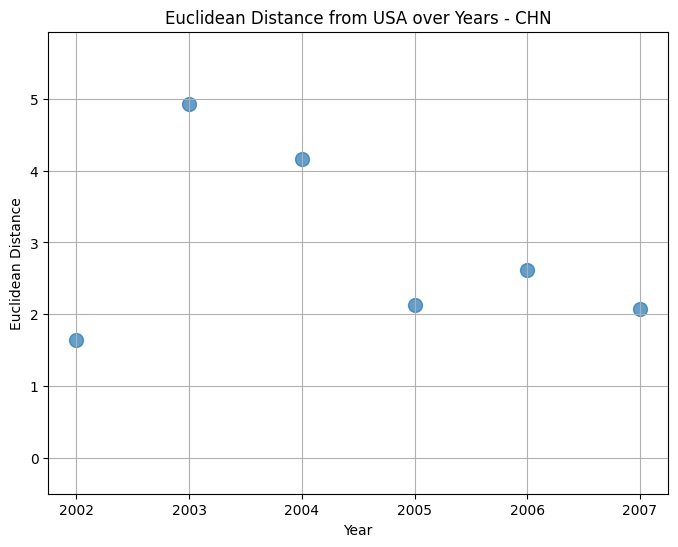

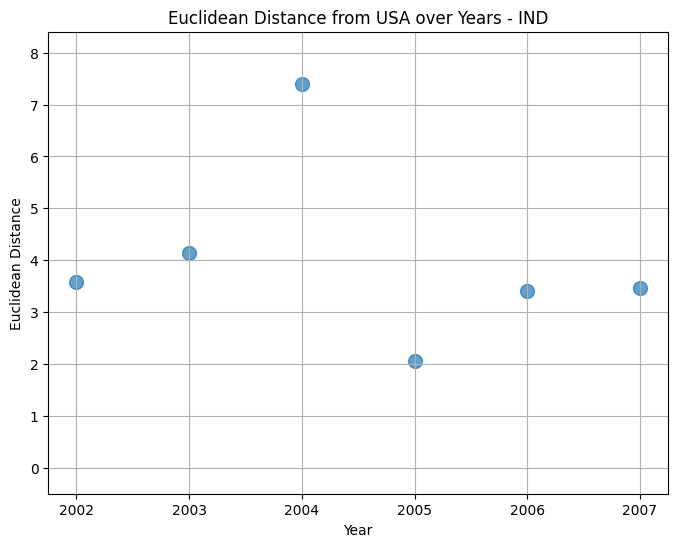

In [29]:
country_of_interest = ['AFG','ALB','CHN','IND']
for country in country_of_interest:
    # Filter the data for the current country
    country_data = df_vectors[df['country'] == country]
    
    # Create a new figure for each country
    plt.figure(figsize=(8, 6))
    
    # Create a scatter plot for the current country
    plt.scatter(country_data['year'], country_data['distance'], s=100, alpha=0.7)
    plt.xticks(ticks=country_data['year'].unique())
    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Euclidean Distance from USA over Years - {country}')
    plt.ylim(-0.5, max(country_data['distance']) + 1)
    plt.grid(True)
    
    # Show the plot for the current country
    plt.show()

In [131]:
countries_of_interest = ["United States",
    "Afghanistan", "Albania", "Australia", "Azerbaijan", "Bulgaria", "Colombia",
    "Czechia", "Denmark", "El Salvador", "Eritrea", "Estonia", "Ethiopia",
    "Georgia", "Hungary", "Iceland", "Italy", "Japan", "Korea, Republic of", "Latvia",
    "Lithuania", "North Macedonia", "Netherlands", "Nicaragua", "Philippines", "Poland",
    "Romania", "Slovakia", "Spain", "Türkiye", "United Kingdom", "Uzbekistan",
    "Costa Rica", "Dominican Republic", "Honduras", "Kuwait", "Marshall Islands",
    "Micronesia, Federated States of", "Mongolia", "Palau", "Portugal", "Rwanda", "Singapore",
    "Solomon Islands", "Uganda", "Panama", "Angola", "Tonga", "Ukraine"
]

#countries_of_not_interest = ["France","Germany","China","Russia","Canada","Mexico"]


In [135]:
import pycountry
#df_vectors_2003 = df_vectors[df_vectors['year'] == 2004]
top_30_countries = df_vectors.sort_values('distance').head(50)
country_names = {country.alpha_3: country.name for country in pycountry.countries}
top_30_countries['country'] = top_30_countries['country'].map(country_names)
top_30_countries['match'] = top_30_countries['country'].apply(lambda x: x in countries_of_interest)
#top_30_countries['not_match'] = top_30_countries['country'].apply(lambda x: x in countries_of_not_interest)
top_30_countries


0         1         2  year                           country  \
270  0.133810 -3.953417  1.035585  2003                     United States   
666  0.461430 -1.527739  1.316926  2007                     United States   
633  0.885258 -1.661723  1.128276  2006                     United States   
130  0.595243 -2.037198  0.489745  2002                     United States   
508  0.133812 -3.953416  1.035575  2004                     United States   
203  0.117353 -0.902817  0.078673  2005                     United States   
650  0.461430 -1.527739  1.316926  2007                           Romania   
649  0.461431 -1.527740  1.316926  2007                   North Macedonia   
660  0.461429 -1.527739  1.316929  2007                    United Kingdom   
384  0.133810 -3.953408  1.035583  2003                    United Kingdom   
622  0.885247 -1.661686  1.128303  2006                              Iraq   
634  0.885219 -1.661700  1.128299  2006                              Togo   
548  0.885185 -1.661682  1.128352  2006                    United Kingdom   
155  0.141058 -0.734527 -0.122187  2005                   North Macedonia   
146  0.496237 -1.039269 -0.160475  2005            Bosnia and Herzegovina   
207  0.240630 -0.730028 -0.348667  2005                       Timor-Leste   
617  0.461429 -1.527739  1.316927  2006                           Romania   
580  0.461429 -1.527738  1.316927  2006                   North Macedonia   
564  0.461428 -1.527738  1.316926  2006                           Denmark   
729  0.885268 -1.661709  1.128271  2007                              Iraq   
65   0.174434 -1.900766  0.747233  2002                       Philippines   
34   0.174435 -1.900764  0.747234  2002                            France   
73   0.174435 -1.900759  0.747234  2002                            Canada   
11   0.174434 -1.900761  0.747236  2002                    United Kingdom   
122  0.174434 -1.900764  0.747238  2002                            Greece   
91   0.174434 -1.900760  0.747238  2002                             Spain   
183 -0.103002 -1.156596 -0.409491  2005                Korea, Republic of   
195  0.538153 -0.828896 -0.554861  2005                          Bulgaria   
174  0.538153 -0.828895 -0.554861  2005                        Luxembourg   
192  0.419891 -0.972459 -0.721914  2005                            Jordan   
2    0.461430 -1.527740  1.316927  2002                       Netherlands   
112  0.461430 -1.527740  1.316927  2002                          Bulgaria   
68   0.461430 -1.527740  1.316927  2002                           Denmark   
188  0.718647  0.213262  0.112108  2005                            Greece   
175  0.718646  0.213263  0.112108  2005                           Comoros   
200  0.718646  0.213263  0.112108  2005                             Egypt   
186  0.718646  0.213263  0.112109  2005                            Guinea   
184  0.718646  0.213263  0.112109  2005                           Tunisia   
132  0.793047  0.096784  0.524546  2005                          Portugal   
208  0.793048  0.096784  0.524546  2005                         Mauritius   
150  0.793047  0.096785  0.524546  2005                             Japan   
211  0.793048  0.096785  0.524546  2005                           Estonia   
187  0.793048  0.096785  0.524545  2005                            Gambia   
136  0.595242 -2.037162  0.489762  2005                            France   
35  -0.329448 -1.773612  1.365980  2002                           Germany   
9   -0.329440 -1.773599  1.365992  2002                             Samoa   
60  -0.329442 -1.773598  1.365993  2002  Saint Vincent and the Grenadines   
7   -0.329441 -1.773595  1.365994  2002                       New Zealand   
107 -0.329438 -1.773590  1.365998  2002                           Ireland   
90  -0.329437 -1.773589  1.366000  2002                            Kuwait   

         distance  match  
270  0.0000000000   True  
666  0.0000000000   True  
633

In [108]:
#sort from largest to smallest distance
top_30_countries = df_vectors.sort_values('distance', ascending=False).head(10)
# Create a dictionary mapping country codes in top_30_countries to country names
country_names = {country.alpha_3: country.name for country in pycountry.countries}

# Map the country codes to country names in the 'country' column
top_30_countries['country'] = top_30_countries['country'].map(country_names)

#Diplay match if the country is in the countries of not interest
top_30_countries['not_match'] = top_30_countries['country'].apply(lambda x: x in countries_of_interest)

top_30_countries

0         1         2  year                          country  \
819 -4.775661 -1.230636 -4.277239  2006  Bolivia, Plurinational State of   
504 -0.878210  4.076025 -1.052622  2003                          Nigeria   
72  -3.363791  4.197336  3.071864  2002                            Sudan   
507 -0.216768  3.081389 -0.795078  2003                        Guatemala   
437 -0.216766  3.081392 -0.795075  2003                      Switzerland   
595 -0.216769  3.081390 -0.795078  2004                      Saint Lucia   
684 -0.216768  3.081390 -0.795078  2004                         Cambodia   
743 -0.216765  3.081393 -0.795074  2004                            India   
238 -3.363791  4.197337  3.071865  2005                       Bangladesh   
254  7.980135  1.335354  1.045768  2005        Iran, Islamic Republic of   

     distance  not_match  
819  8.685830      False  
504  8.471907      False  
72   8.419835      False  
507  7.404720      False  
437  7.404719      False  
595  7.404717      False  
684  7.404717      False  
743  7.404716      False  
238  7.357604      False  
254  7.173352      False

In [71]:
missing_countries = [
    "Afghanistan", "Australia", "Colombia", "Czech Republic", "El Salvador", "Eritrea",
    "Ethiopia", "Georgia", "Iceland", "South Korea", "Lithuania", "Macedonia",
    "Nicaragua", "Philippines", "Uzbekistan", "Honduras", "Marshall Islands", 
    "Micronesia", "Palau", "Rwanda", "Singapore", "Solomon Islands", "Uganda", "Tonga"
]

# Filter the data for the missing countries
country_names = {country.alpha_3: country.name for country in pycountry.countries}

# Map the country codes to country names in the 'country' column
df_vectors['country'] = df_vectors['country'].map(country_names)

missing_country_data = df_vectors[df_vectors['country'].isin(missing_countries)]
#print full list of missing country data without truncation
pd.set_option('display.max_rows', None)
missing_country_data

0         1         2  year           country  distance
11   -1.125080 -0.996482  0.463255  2002         Nicaragua  3.488767
14   -0.307020  0.533282 -0.911136  2002          Colombia  3.574439
29   -0.307043  0.533278 -0.911131  2002          Ethiopia  3.574453
30   -0.307039  0.533277 -0.911133  2002  Marshall Islands  3.574449
44    1.089277 -0.767675 -0.490111  2002             Palau  1.712731
56   -3.109856 -2.691415  3.022670  2002        Uzbekistan  6.142093
57   -0.735224 -0.571670  0.032618  2002           Georgia  3.220619
60   -0.307022  0.533285 -0.911135  2002       El Salvador  3.574442
62   -0.531937 -1.597775 -0.914468  2002         Singapore  3.193185
77   -0.307020  0.533281 -0.911137  2002       Afghanistan  3.574439
87   -0.224484 -1.324039  2.341236  2002         Australia  3.168578
97   -0.307012  0.533274 -0.911140  2002             Tonga  3.574431
98    1.762128 -1.811271  0.627611  2002       Philippines  0.704997
128  -0.307001  0.533276 -0.911143  2002   Solomon Islands  3.574425
130  -0.735212 -0.571685  0.032632  2002            Rwanda  3.220601
141  -3.109857 -2.691415  3.022670  2002         Lithuania  6.142093
147  -0.401006  0.611106  1.824026  2002           Iceland  3.670609
157  -0.307047  0.533278 -0.911130  2002           Eritrea  3.574454
164  -0.735214 -0.571679  0.032626  2002            Uganda  3.220606
166  -0.307031  0.533278 -0.911134  2002          Honduras  3.574445
195  -0.307046  0.533278 -0.911129  2005             Tonga  2.064753
209  -0.307046  0.533279 -0.911130  2005          Ethiopia  2.064754
228  -0.307040  0.533277 -0.911131  2005       Afghanistan  2.064749
229  -0.307041  0.533278 -0.911132  2005         Lithuania  2.064751
233  -0.735220 -0.571680  0.032625  2005        Uzbekistan  1.921651
239  -1.935743 -1.613696 -1.863085  2005            Uganda  3.711013
256  -0.307047  0.533278 -0.911130  2005         Singapore  2.064754
257  -0.307041  0.533285 -0.911129  2005   Solomon Islands  2.064753
265  -0.307042  0.533278 -0.911132  2005  Marshall Islands  2.064751
274   0.656028 -0.903042  2.091213  2005         Australia  2.264869
275  -0.307040  0.533278 -0.911132  2005          Colombia  2.064750
294  -0.306977  0.533283 -0.911146  2005           Eritrea  2.064713
301   1.186621 -0.254399 -0.557173  2005       El Salvador  0.603329
303  -0.307045  0.533279 -0.911130  2005             Palau  2.064753
310  -0.307046  0.533279 -0.911130  2005       Philippines  2.064754
344  -0.307045  0.533278 -0.911130  2005         Nicaragua  2.064752
347  -0.307046  0.533278 -0.911130  2005           Iceland  2.064754
368  -0.306982  0.533290 -0.911142  2005           Georgia  2.064719
372  -0.307031  0.533280 -0.911134  2005            Rwanda  2.064745
386   0.855833 -0.638595 -0.297121  2003        Uzbekistan  4.743612
392  -0.307044  0.533279 -0.911131  2003            Rwanda  6.048434
394   1.932001  1.191641 -0.540382  2003         Lithuania  5.696193
412   1.454322 -0.481961 -0.170361  2003           Iceland  4.593827
416   1.186621 -0.254399 -0.557173  2003       Philippines  5.060314
419  -0.306940  0.533293 -0.911148  2003           Eritrea  6.048418
434  -0.818583  0.361218  1.740514  2003             Tonga  4.295248
436   0.961545 -0.213737 -0.808221  2003             Palau  5.338123
450  -0.307032  0.533276 -0.911135  2003  Marshall Islands  6.048431
479  -0.307008  0.533281 -0.911139  2003          Ethiopia  6.048429
498  -0.914468  0.775754  1.594485  2003         Nicaragua  4.676260
499  -1.125002 -0.996559  0.463331  2003            Uganda  4.806591
500   1.180692 -0.644311 -0.096804  2003          Honduras  4.499819
503  -0.735213 -0.571684  0.032632  2003           Georgia  5.041161
506   1.471521 -1.045184 -0.253822  2003         Singapore  4.510123
508   1.296083 -0.881835 -0.087910  2003         Australia  4.407098
531   1.089277 -0.767675 -0.490111  2003       El Salvador  4.848524
537  -0.914469  0.775752  1.594485  2003   Solomon Islands  4.676260
553  -0.307

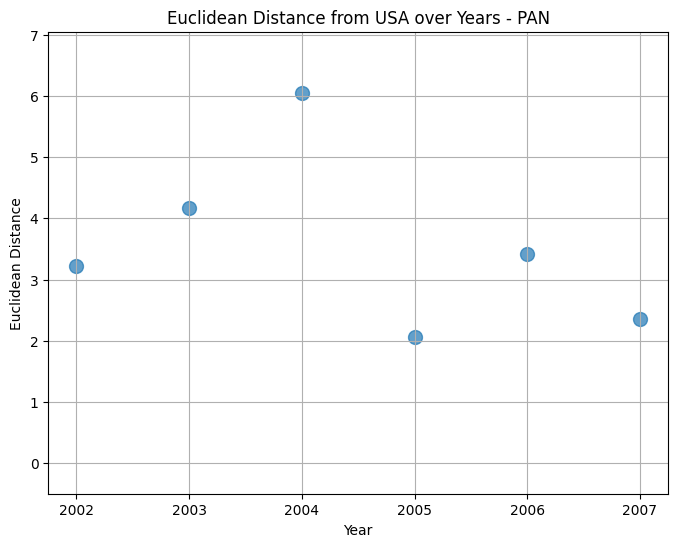

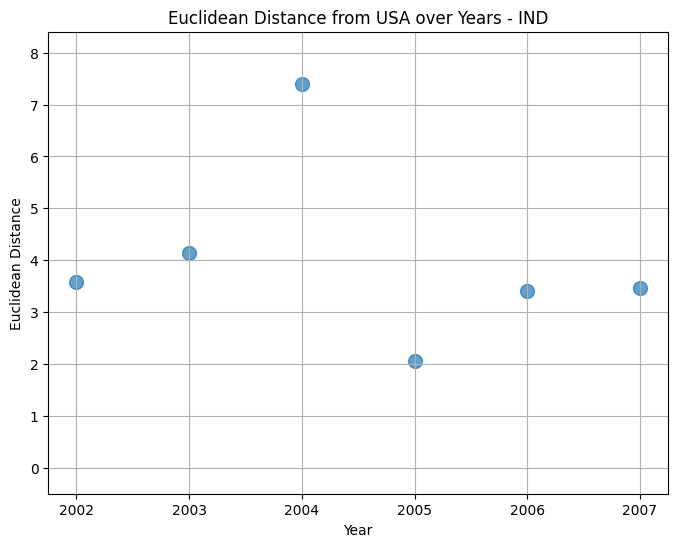

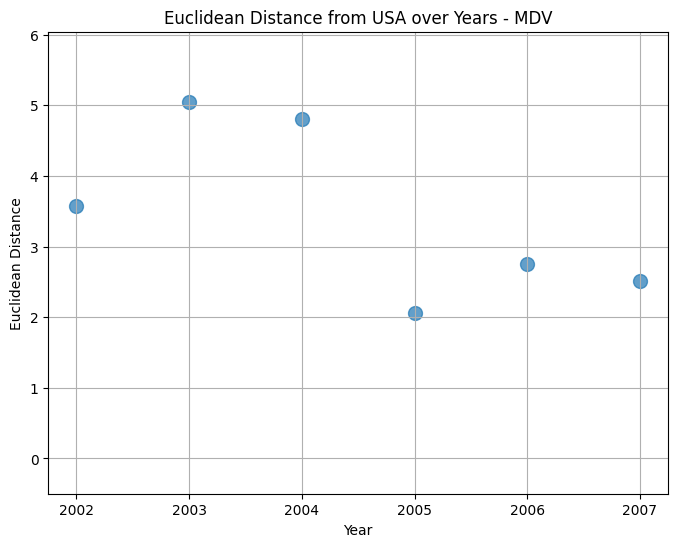

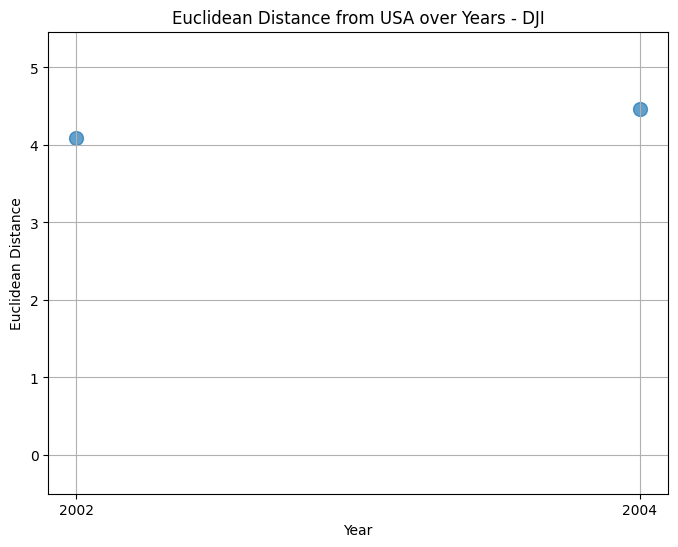

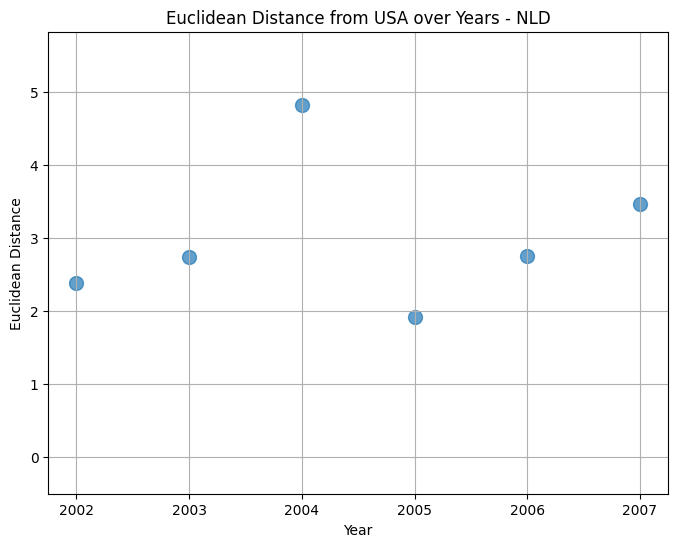

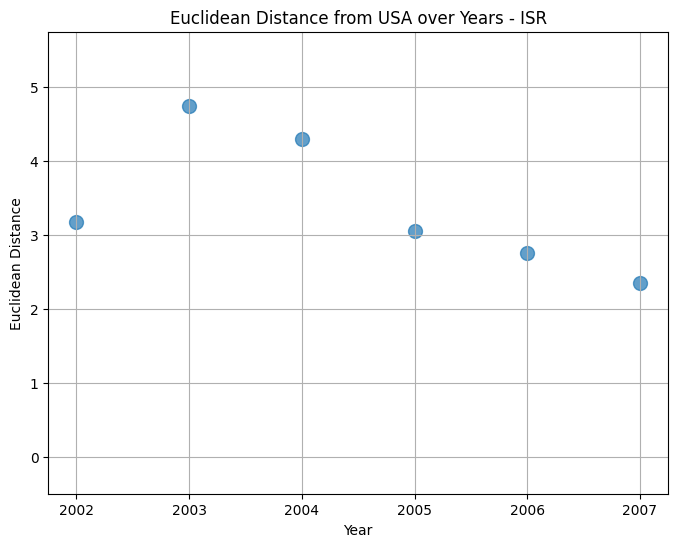

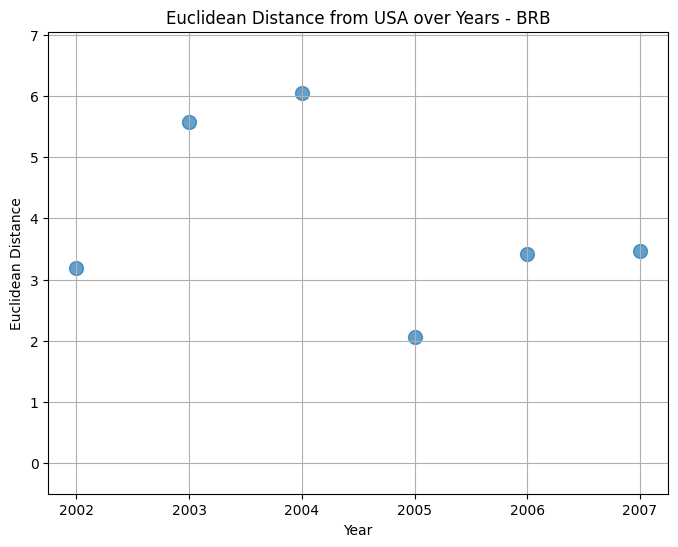

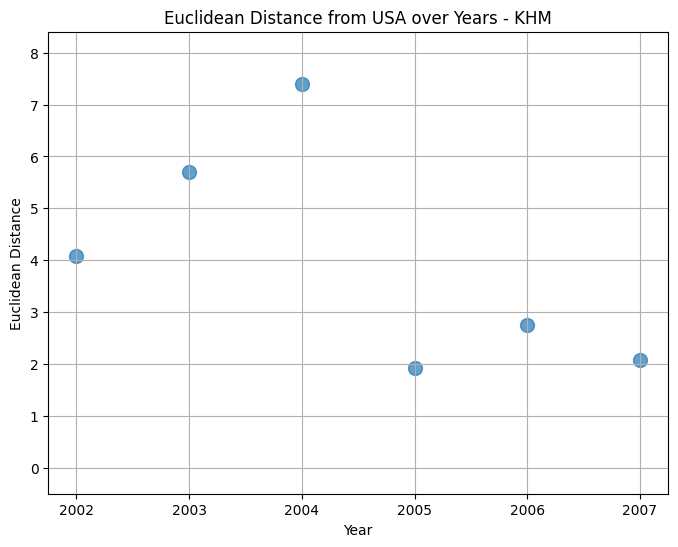

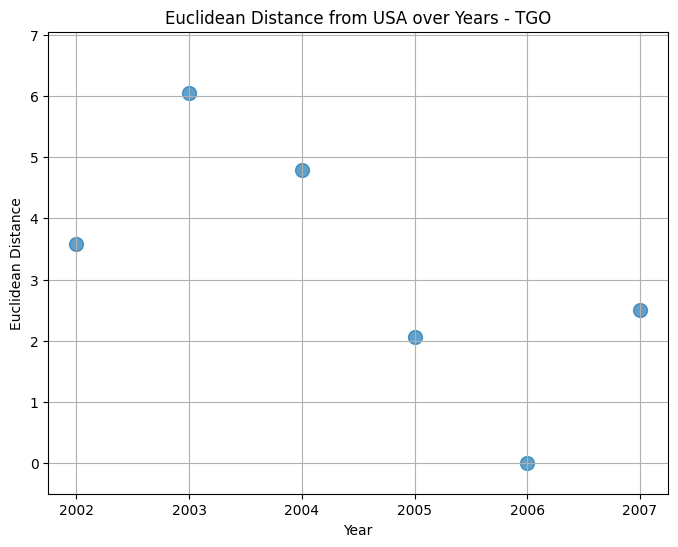

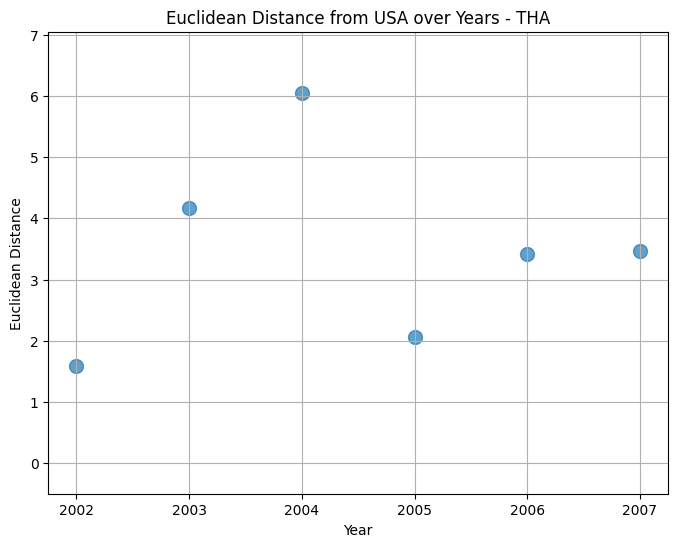

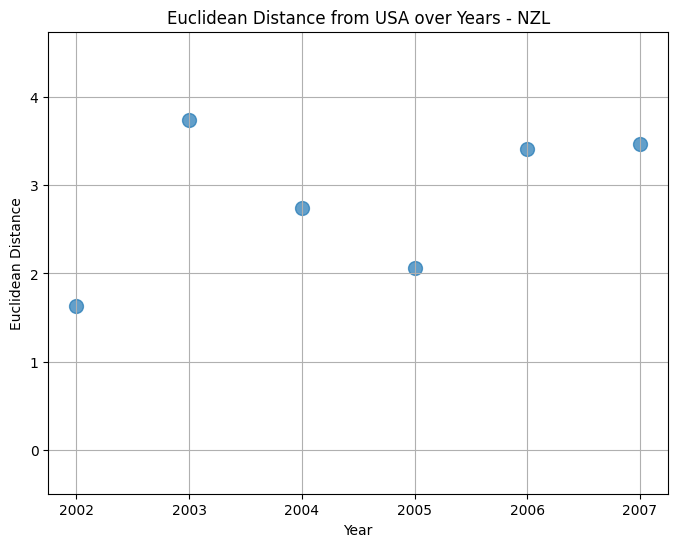

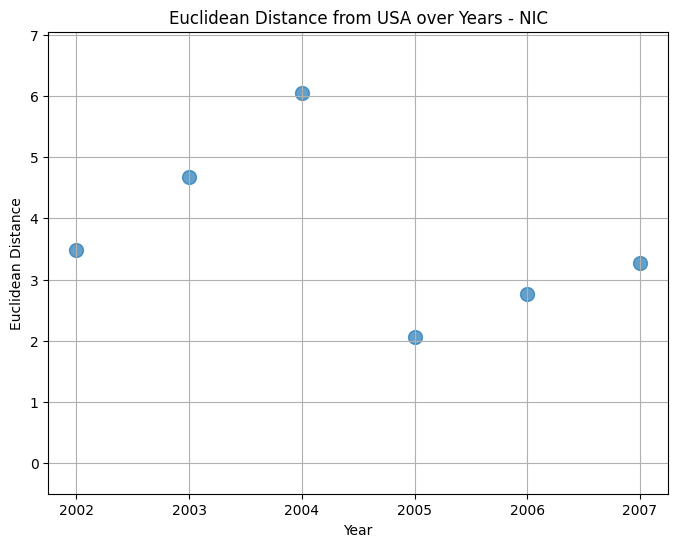

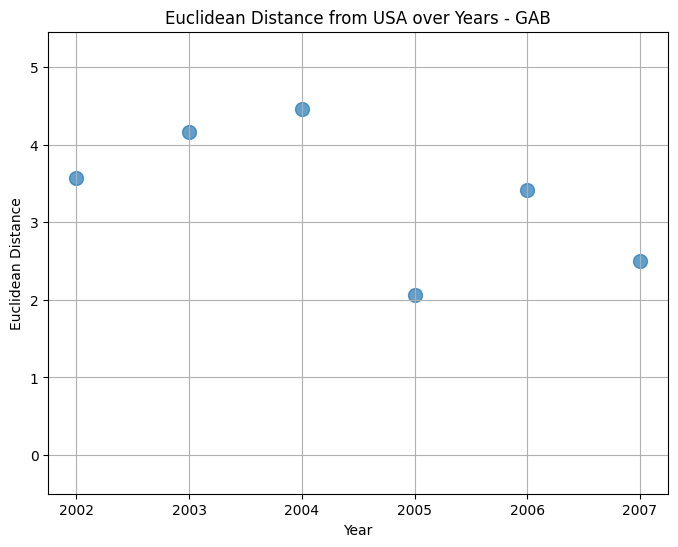

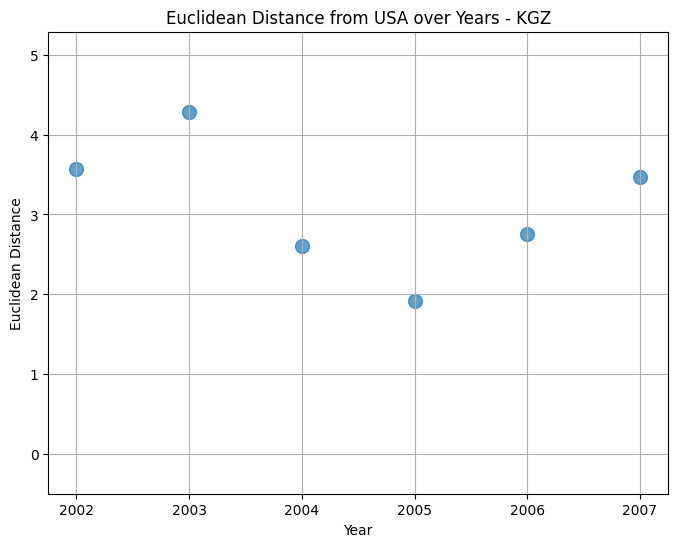

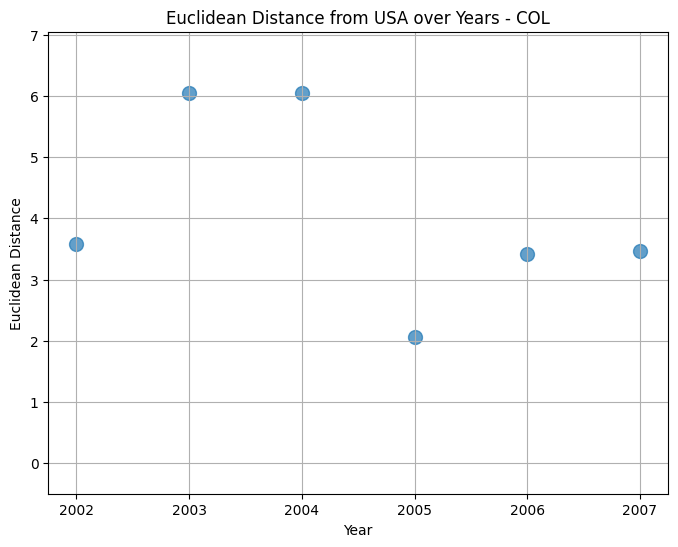

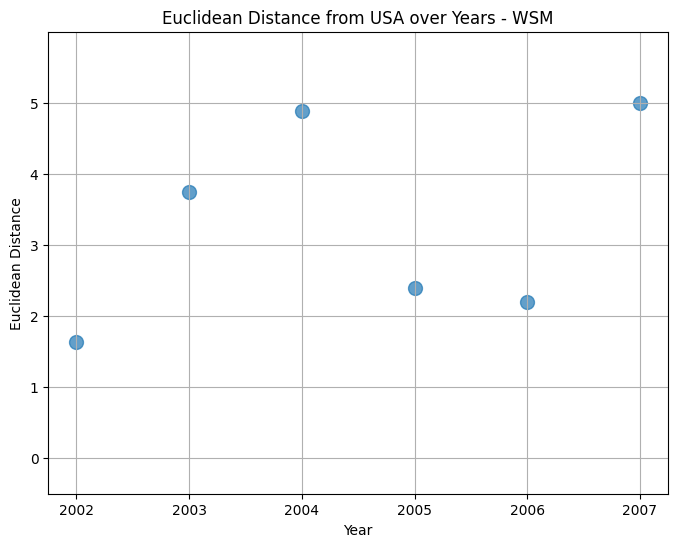

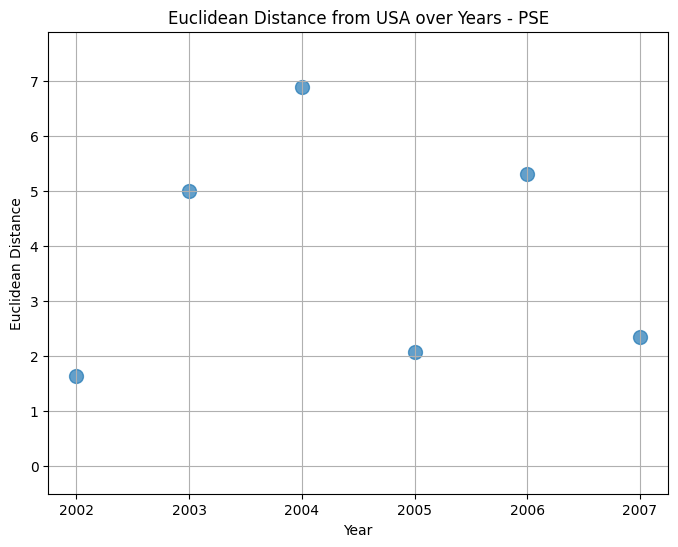

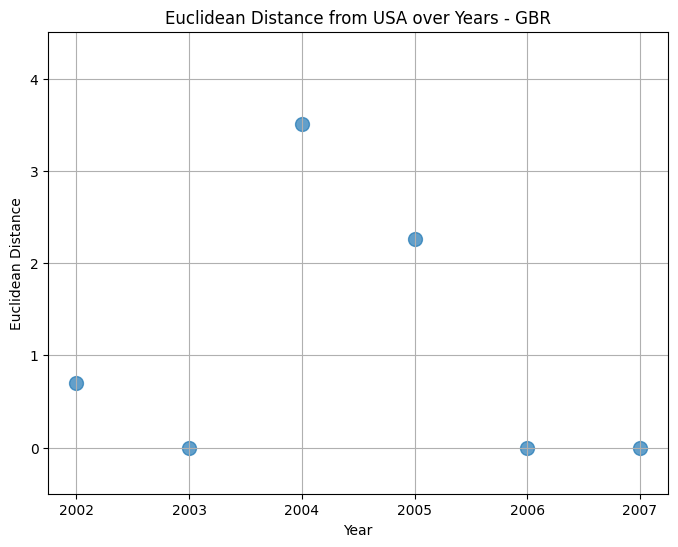

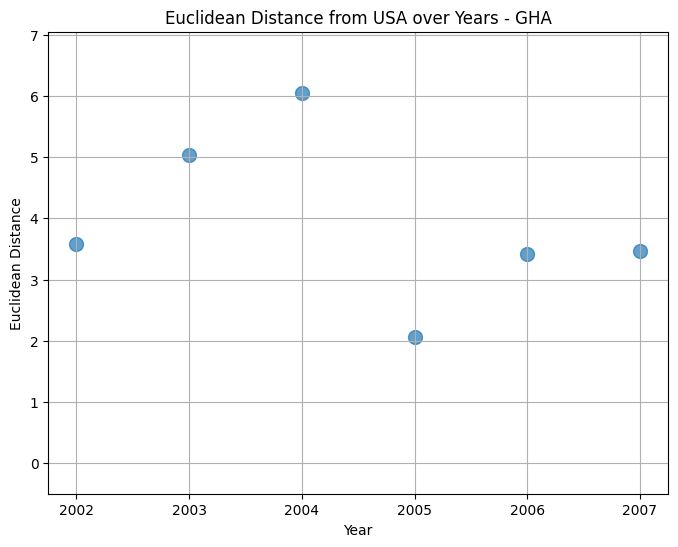

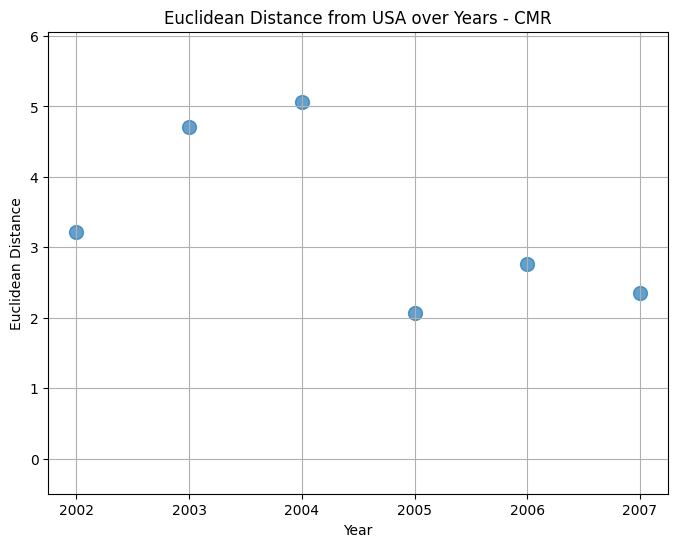

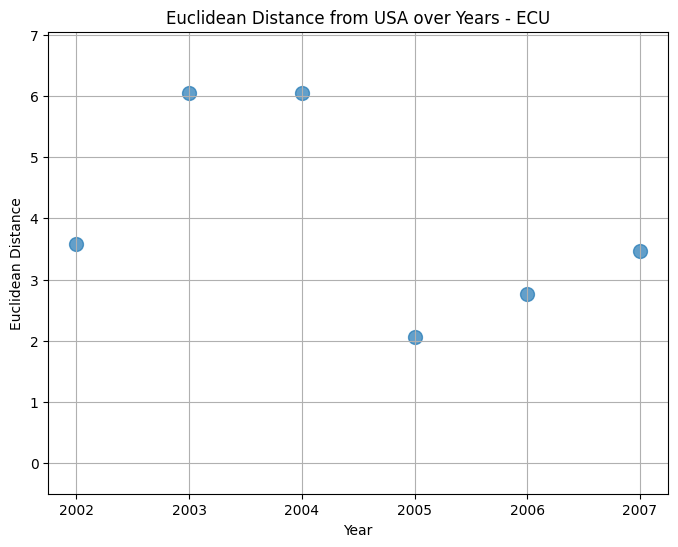

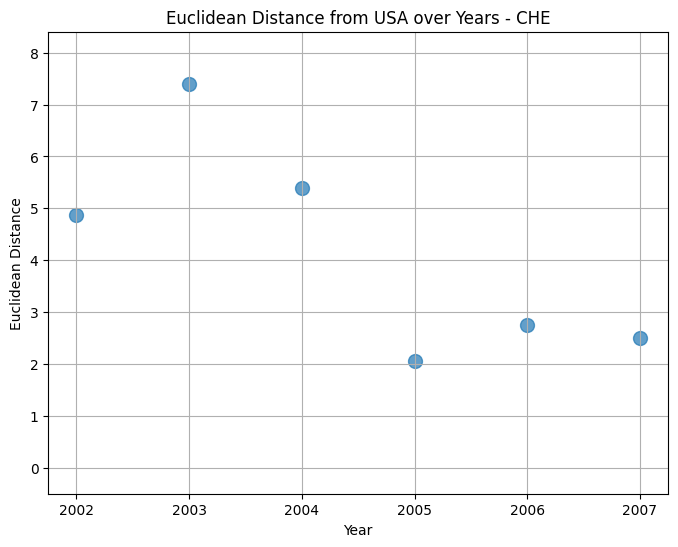

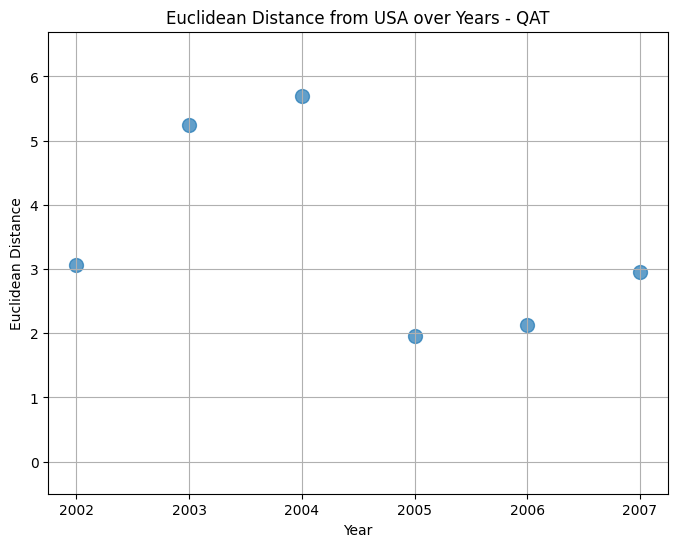

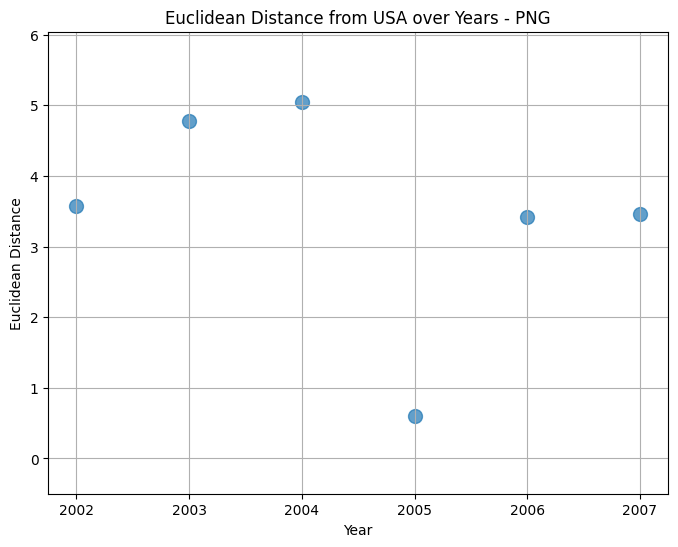

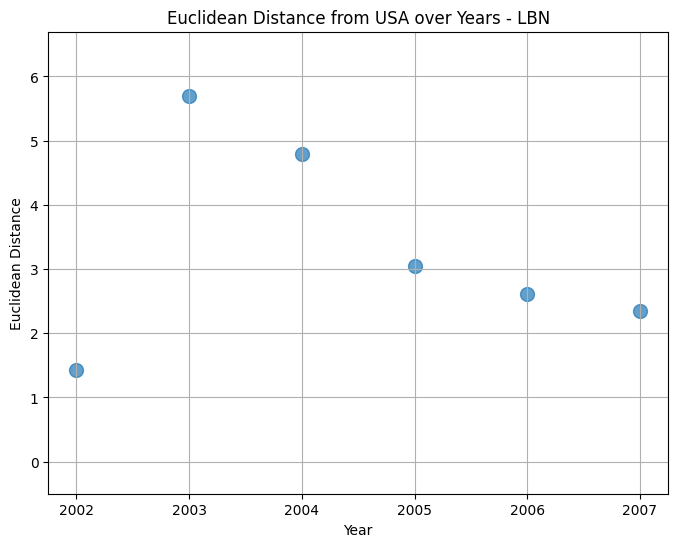

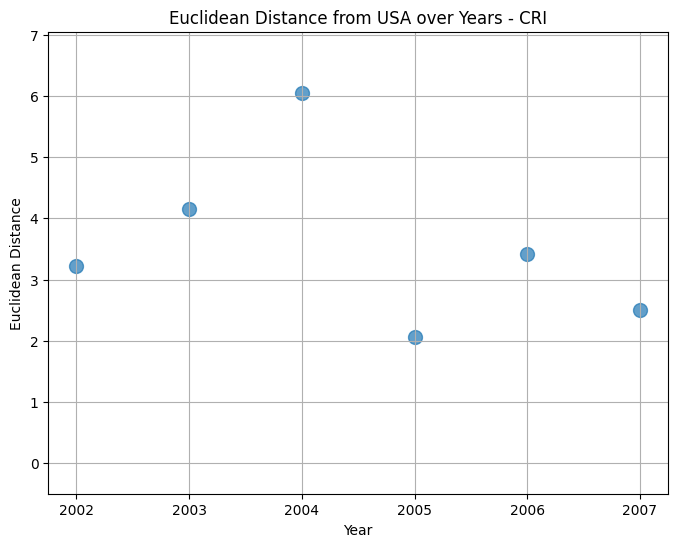

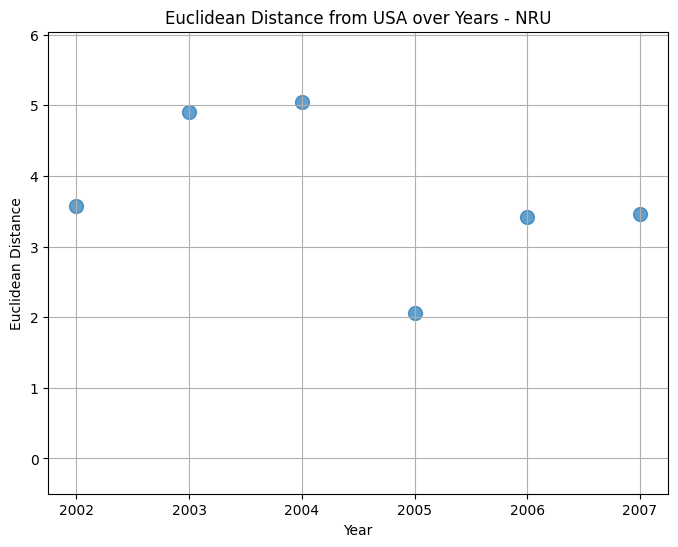

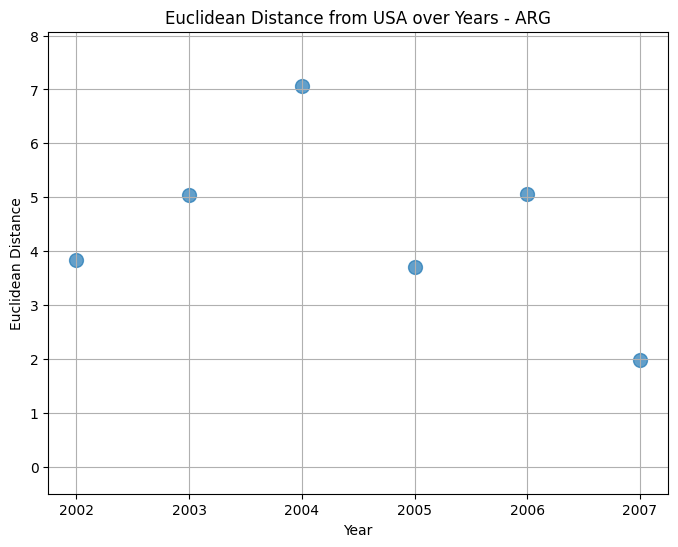

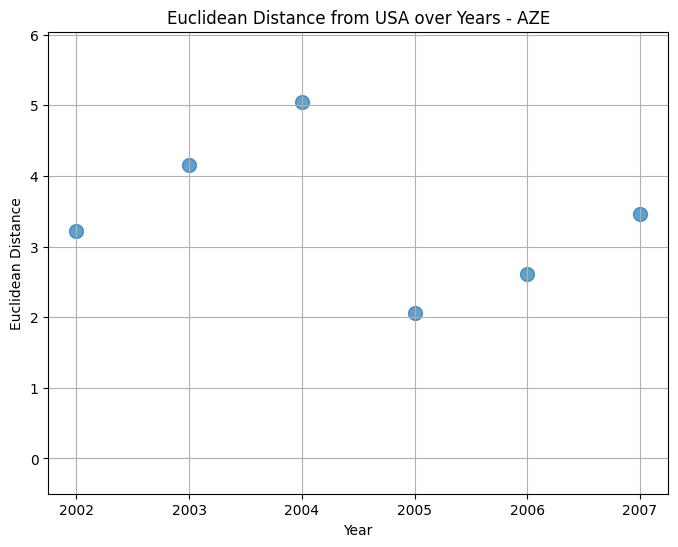

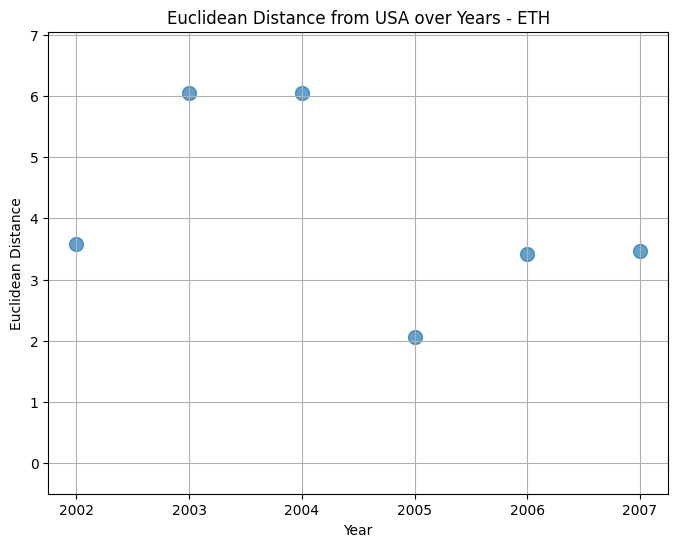

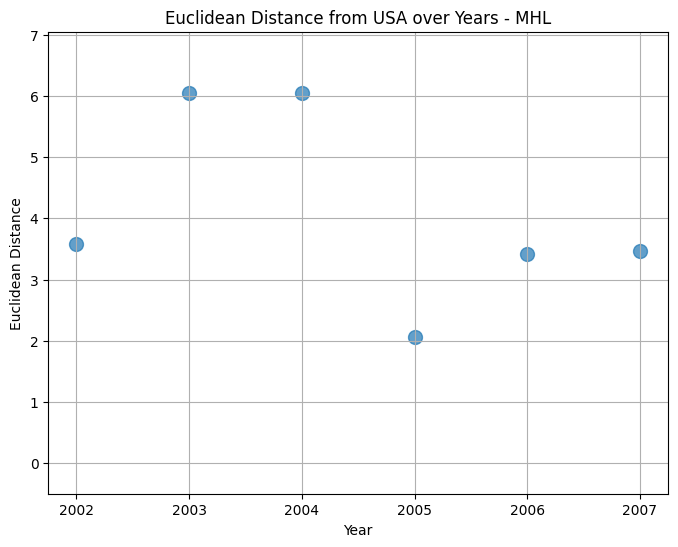

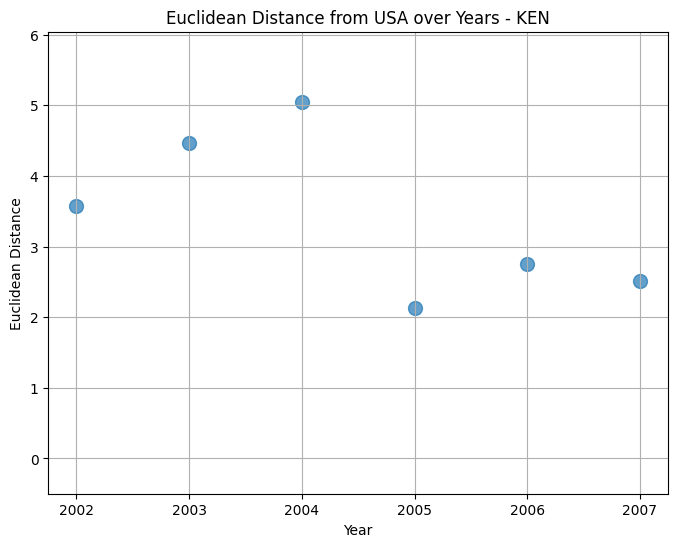

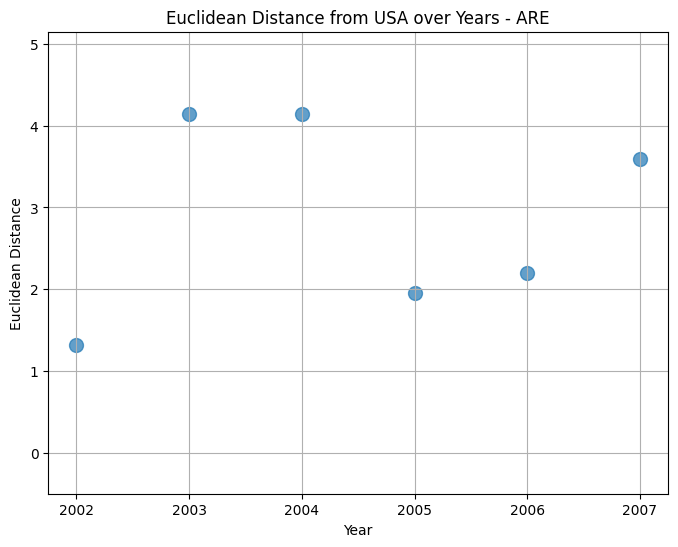

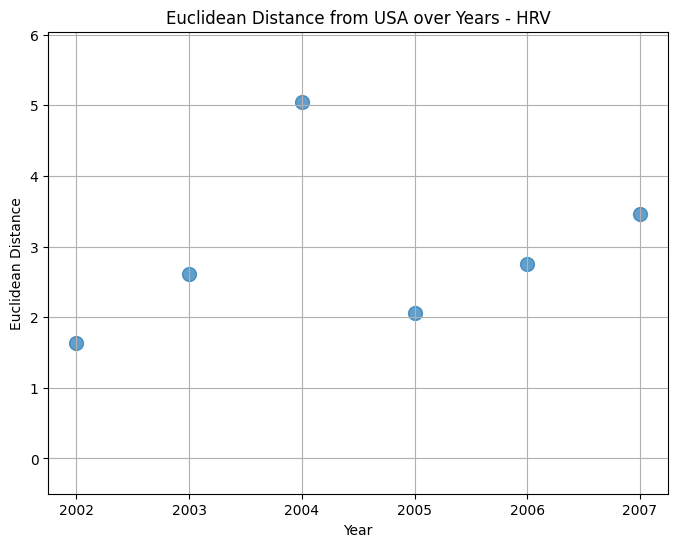

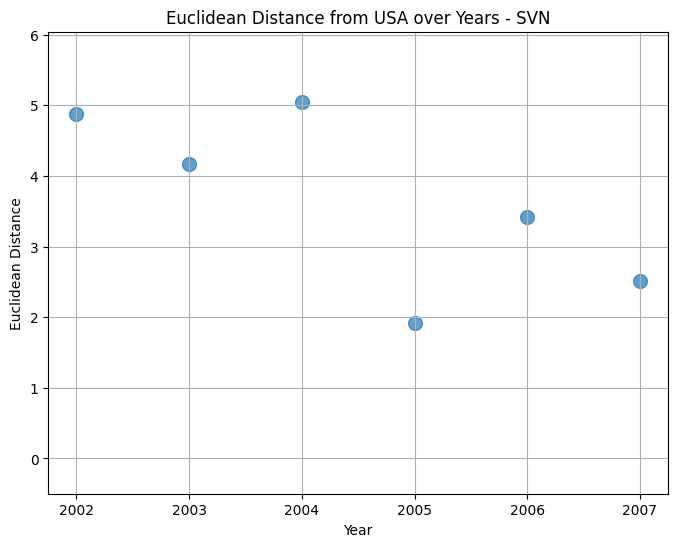

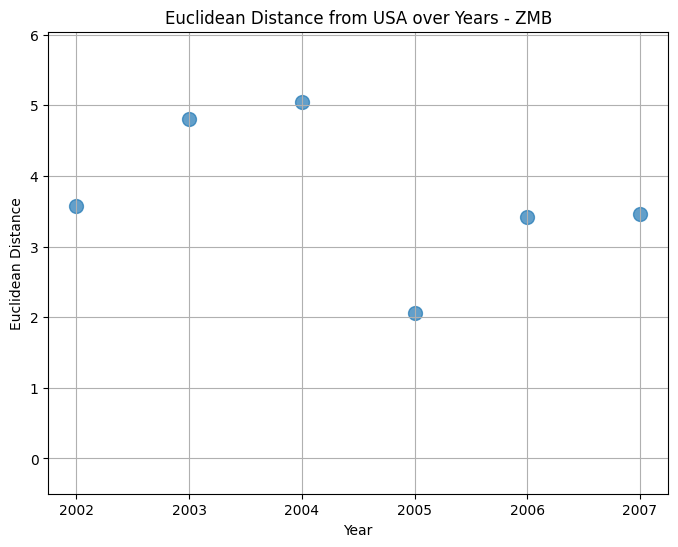

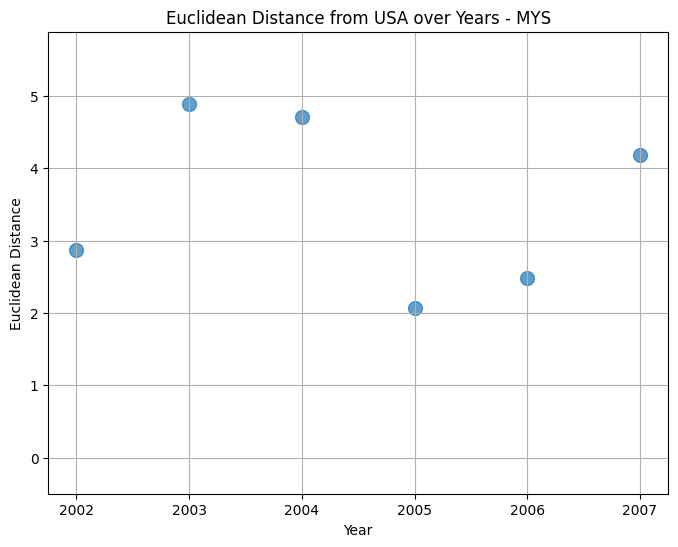

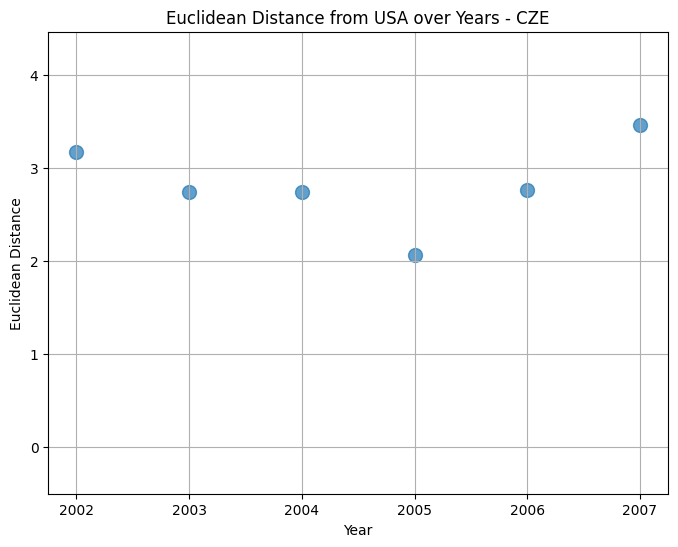

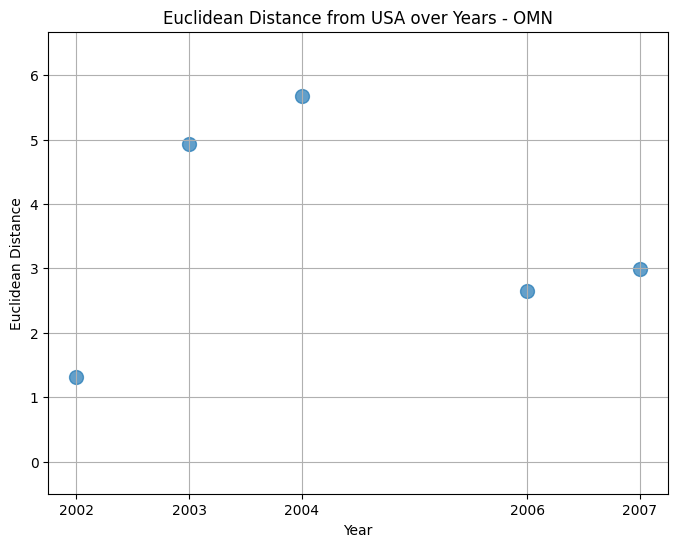

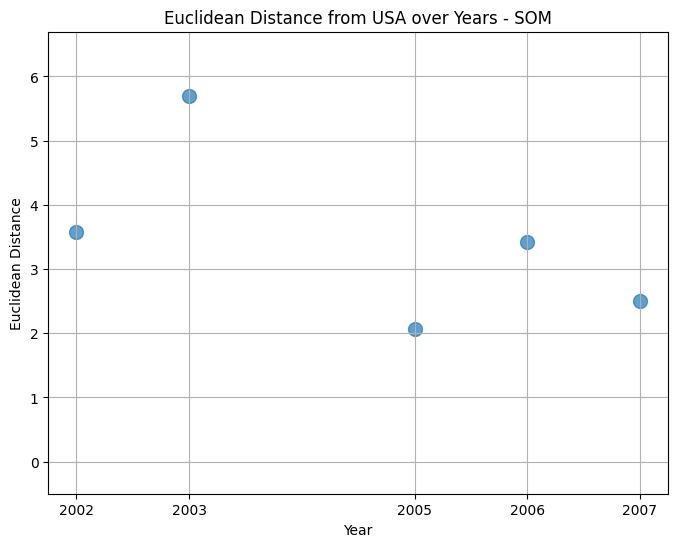

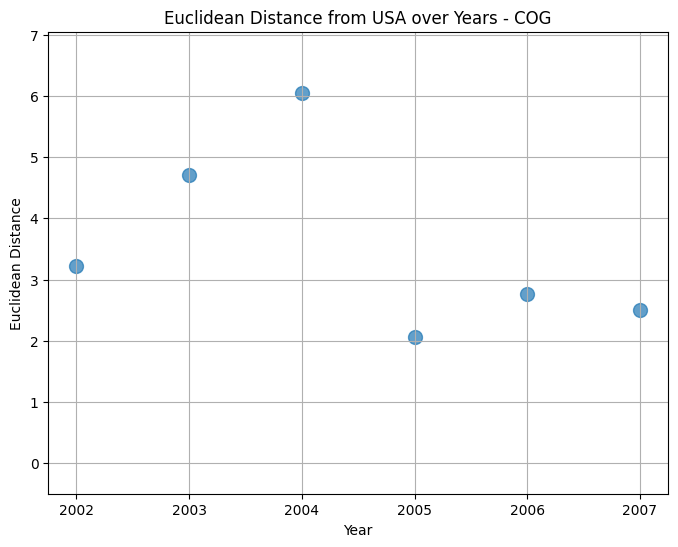

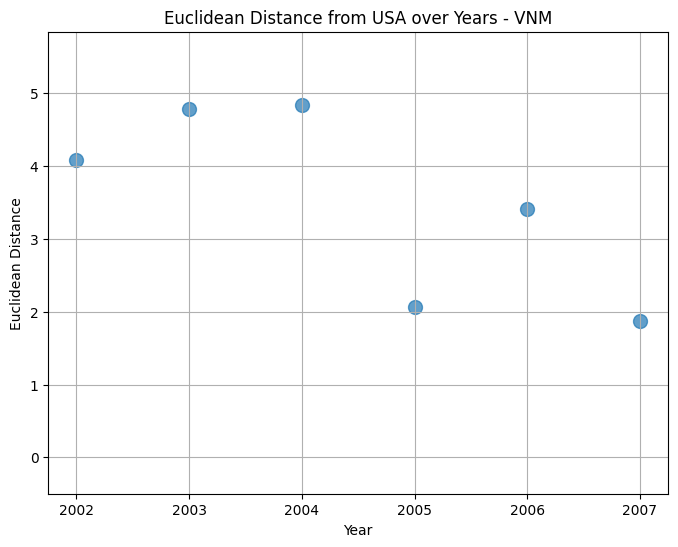

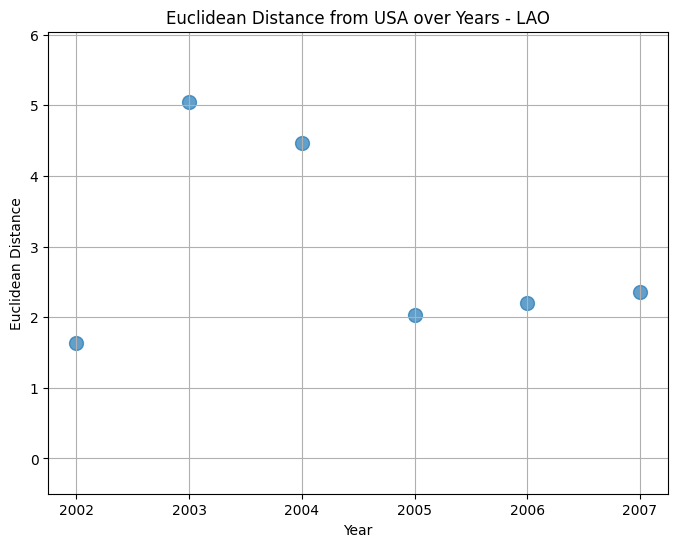

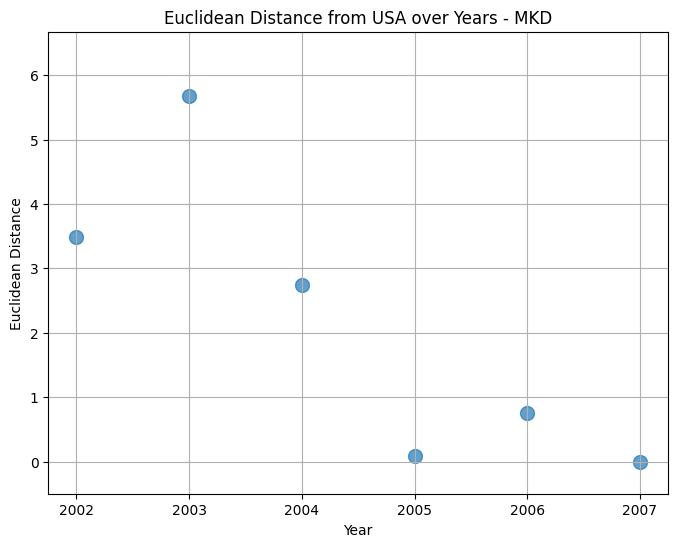

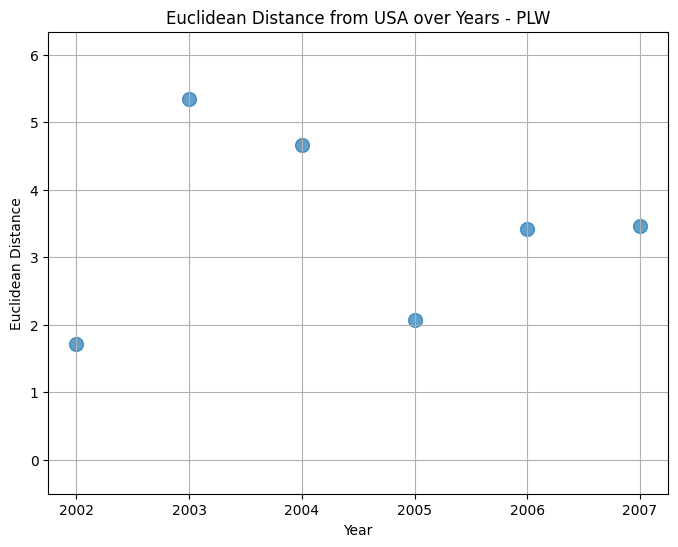

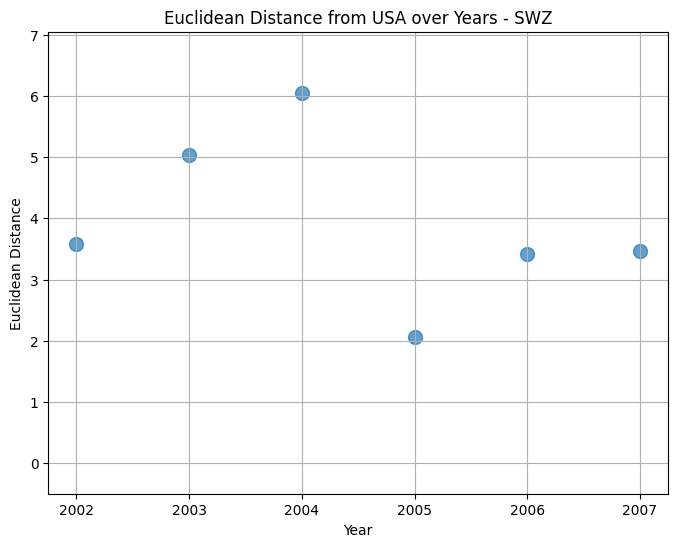

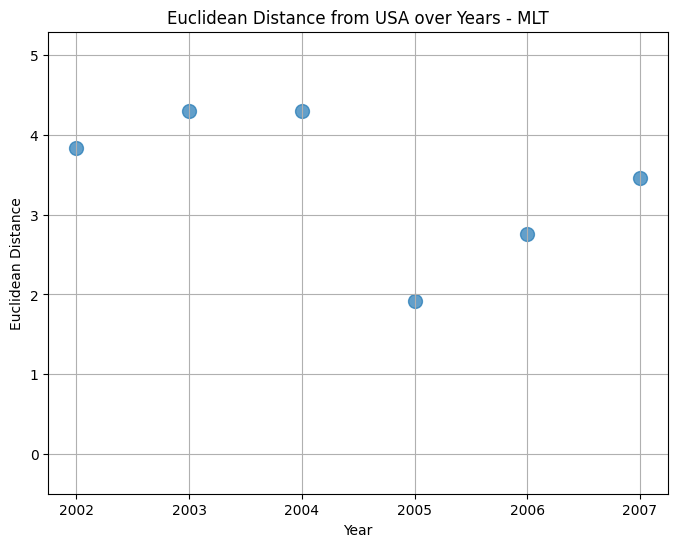

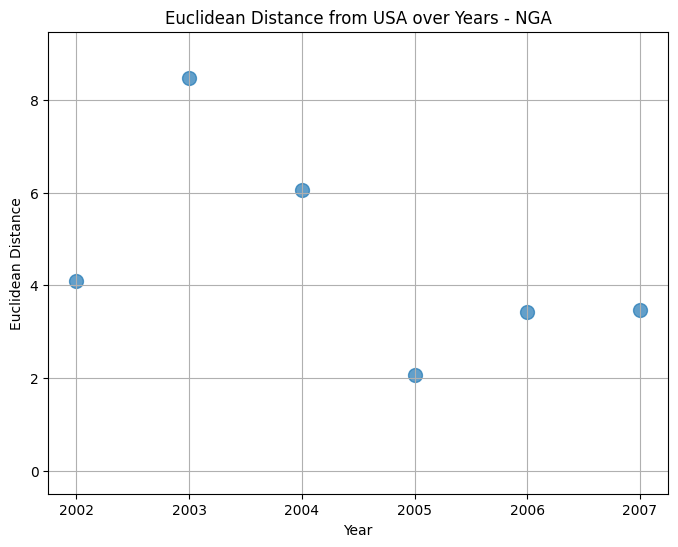

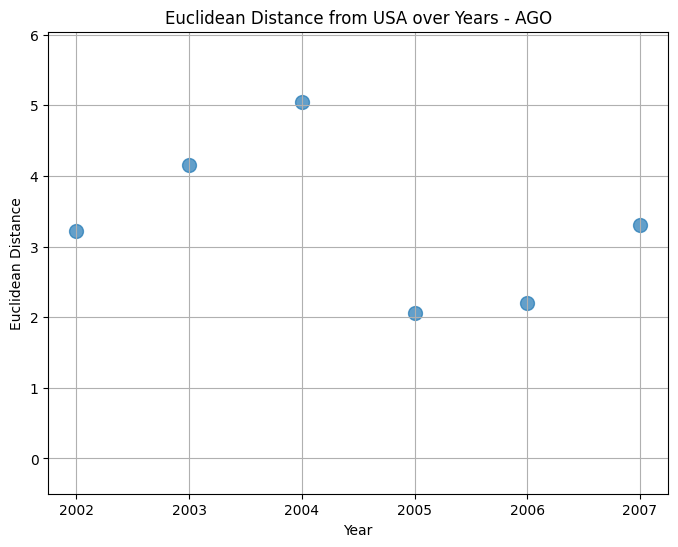

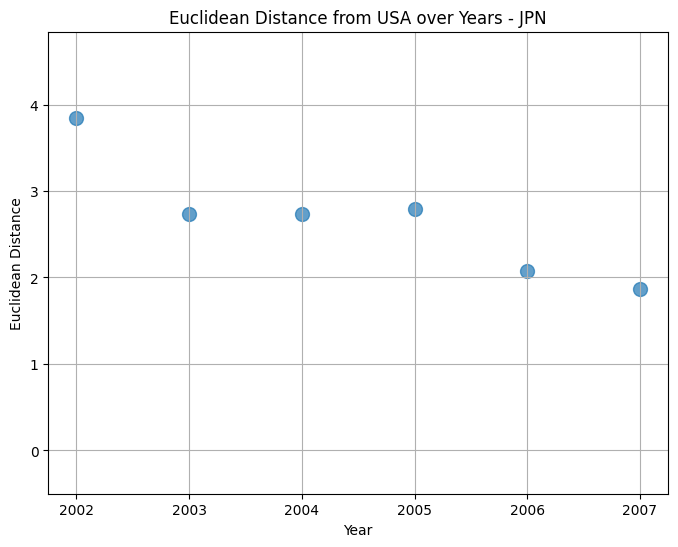

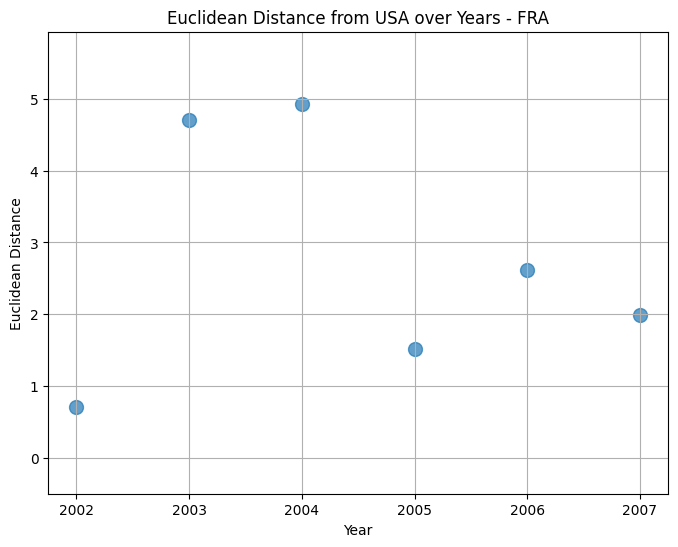

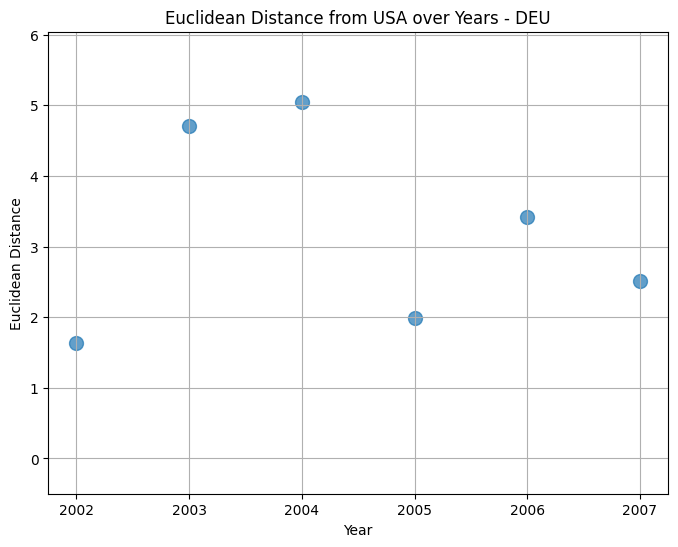

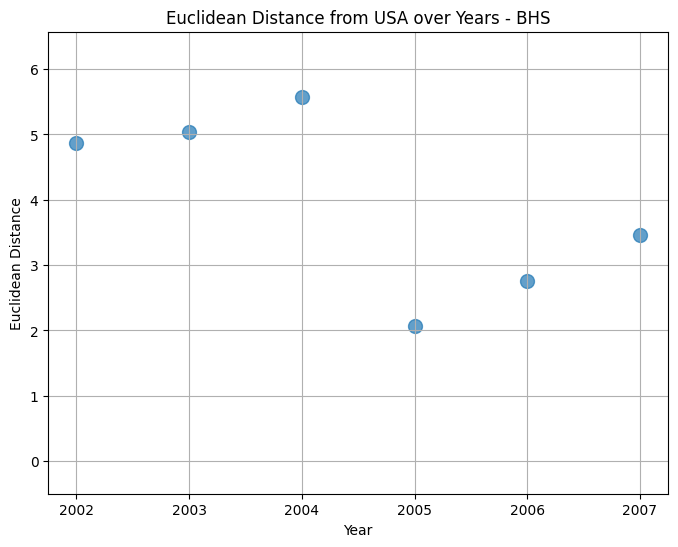

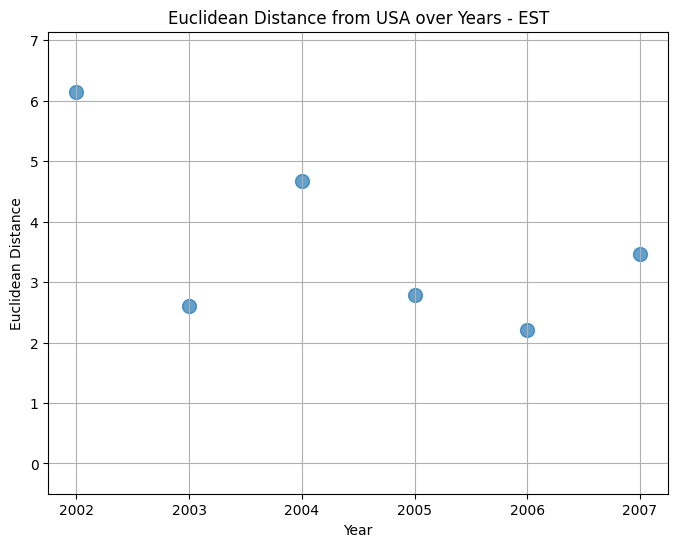

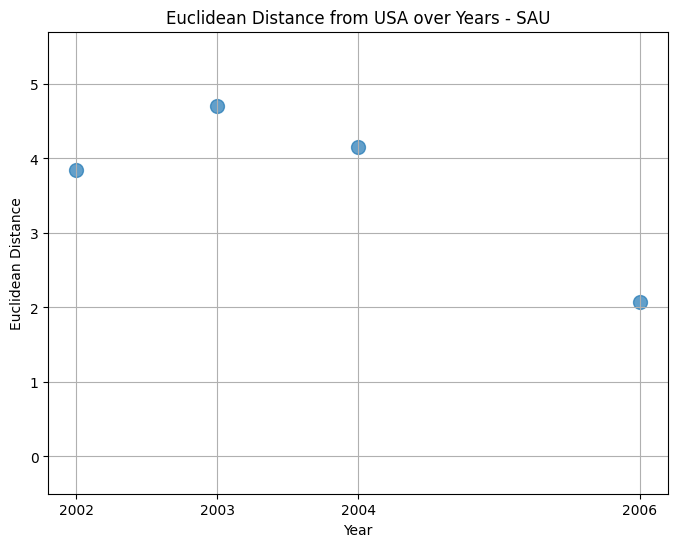

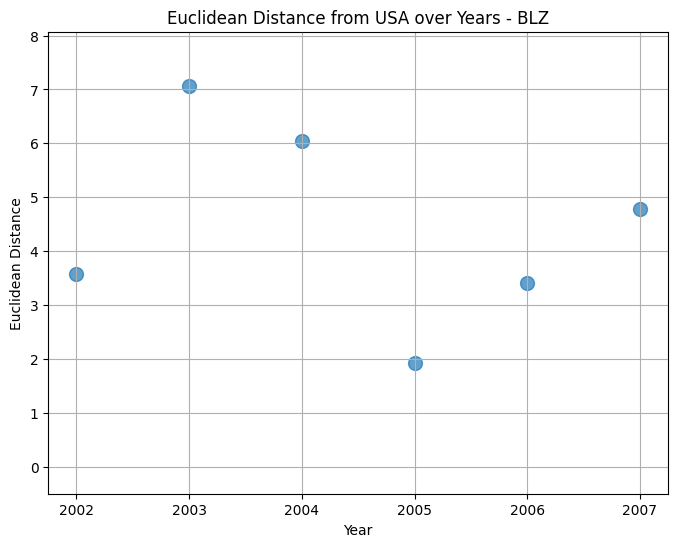

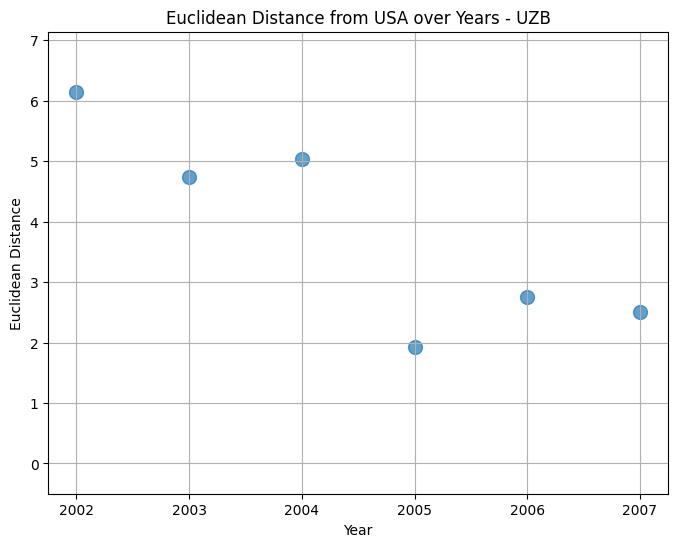

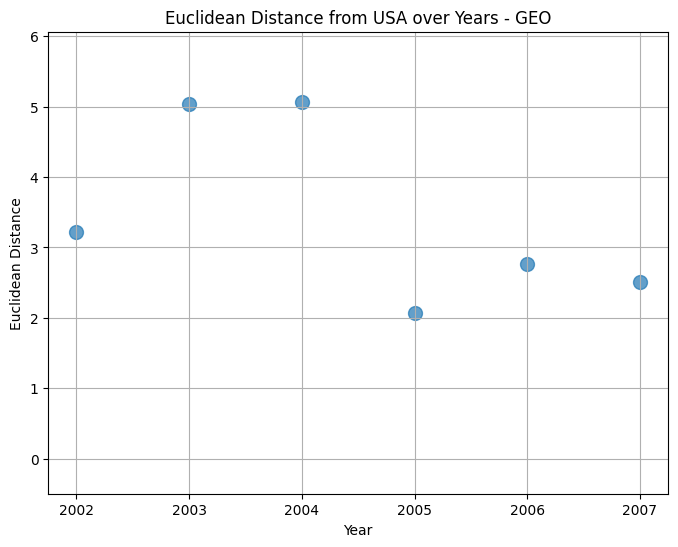

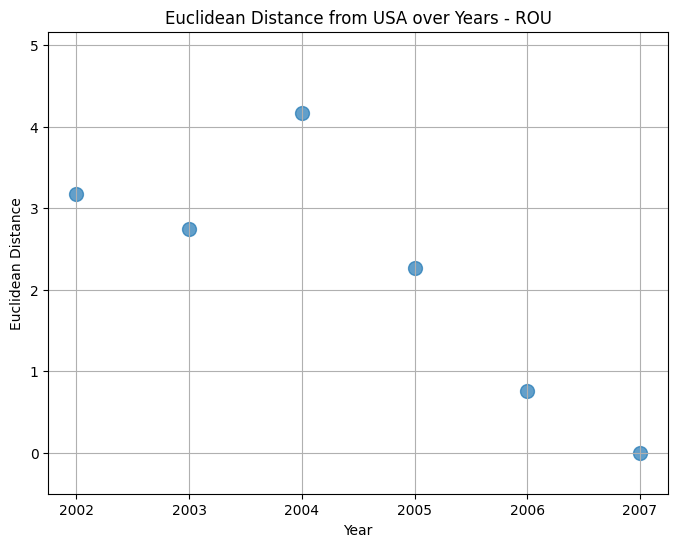

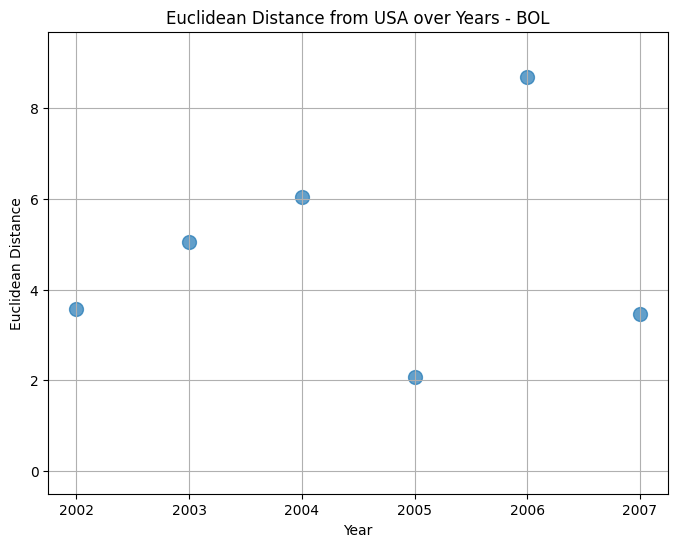

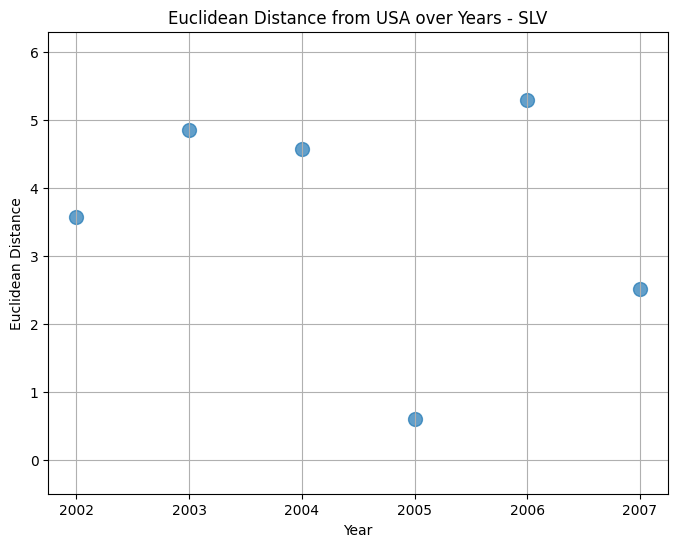

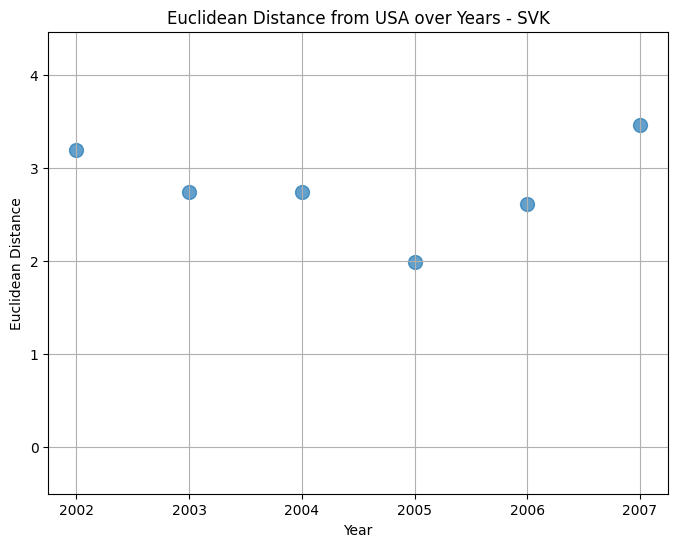

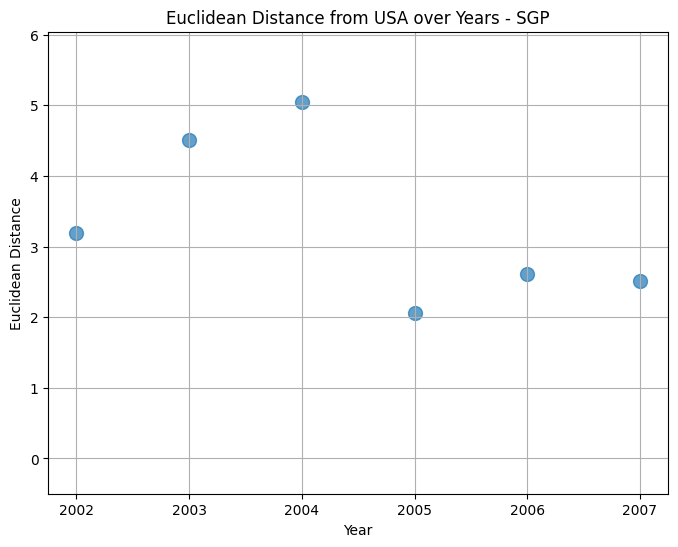

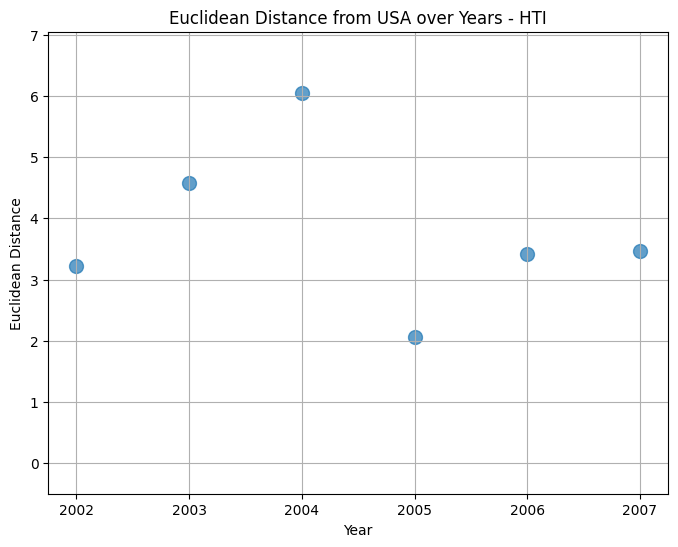

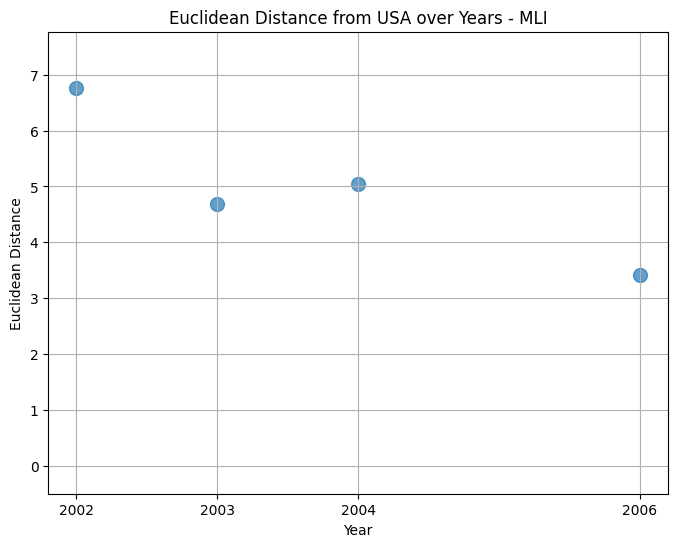

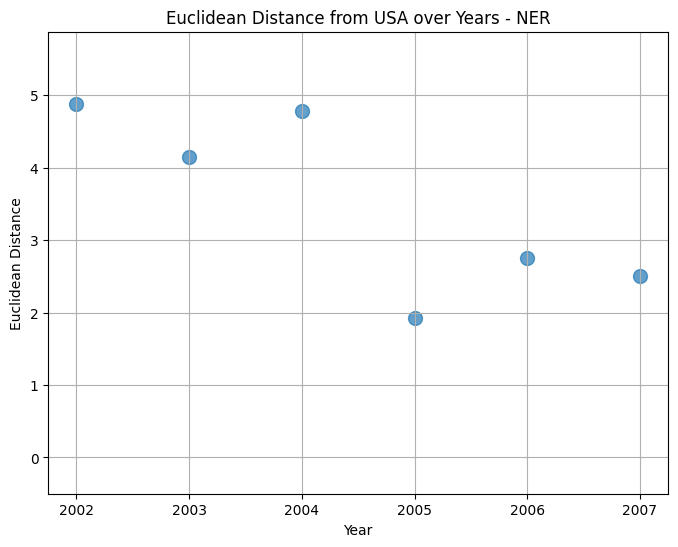

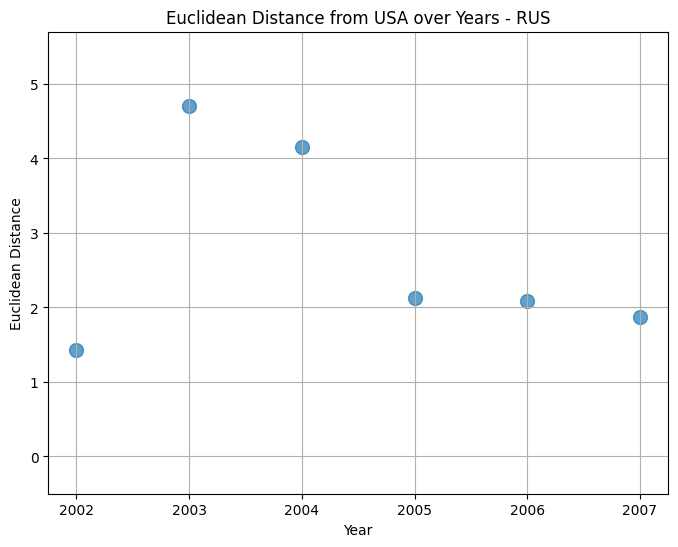

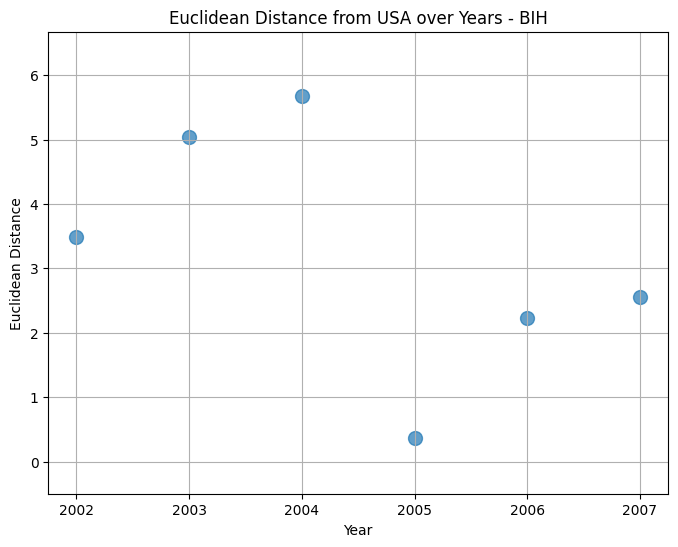

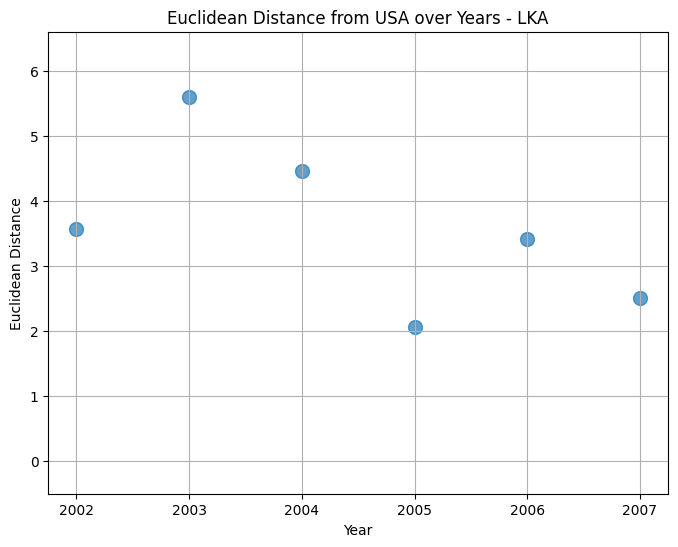

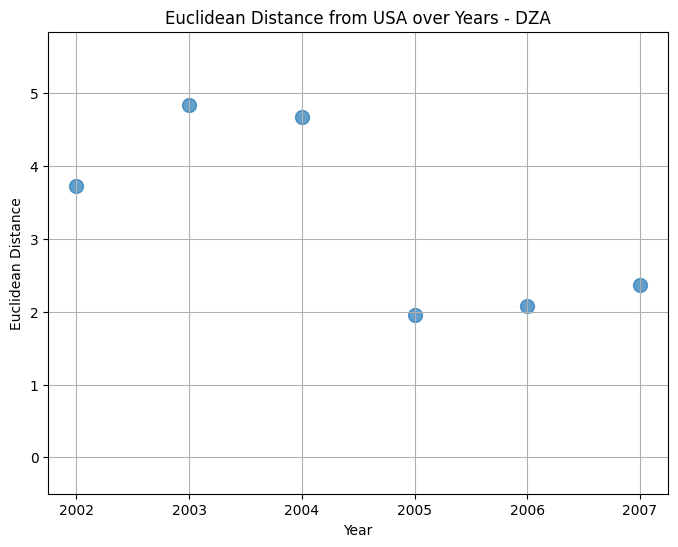

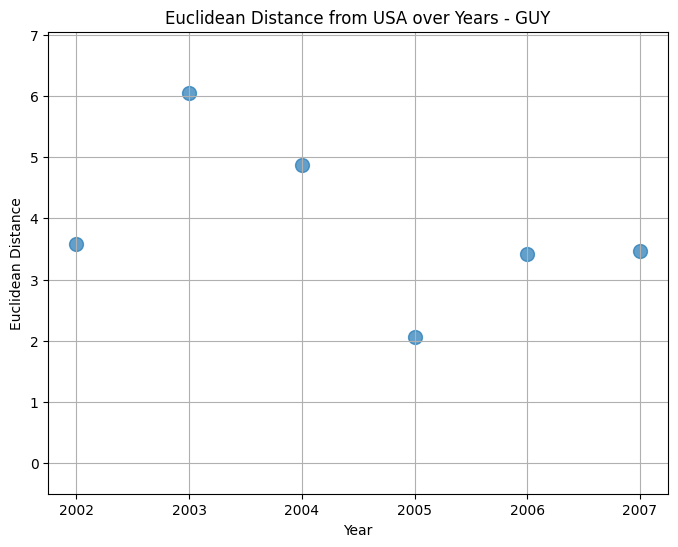

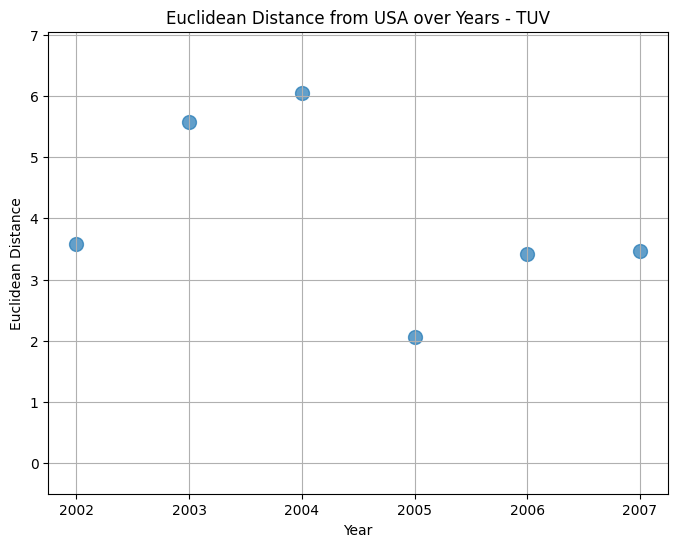

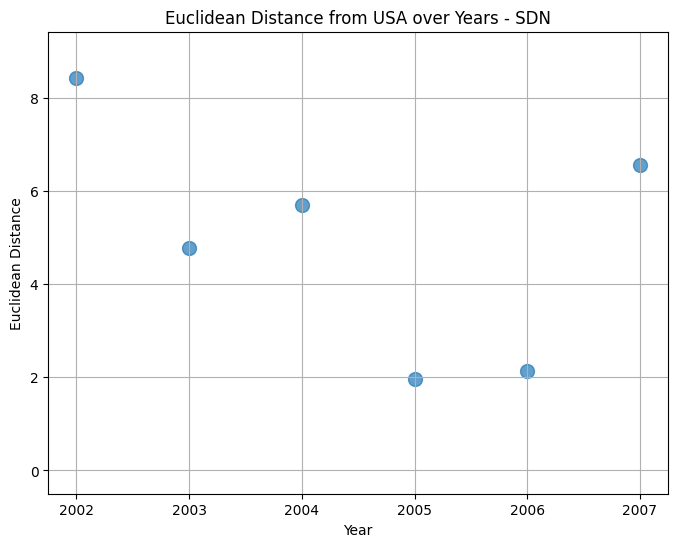

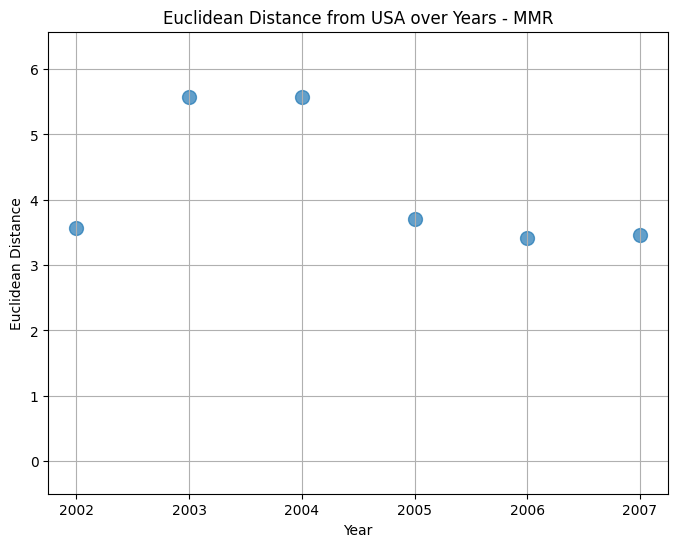

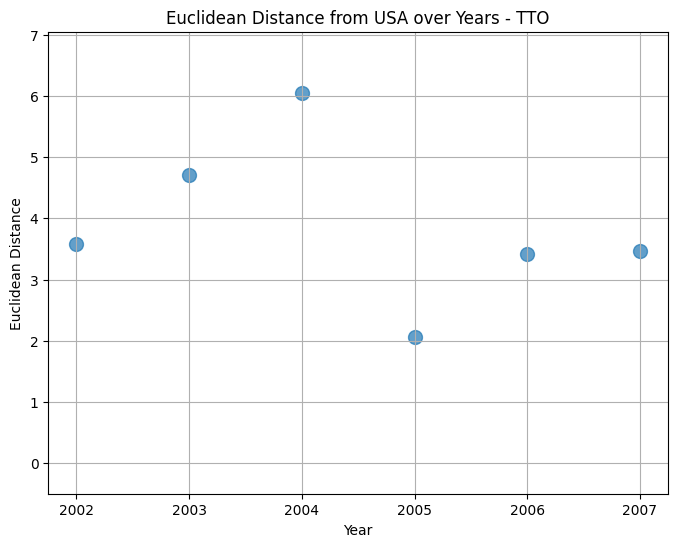

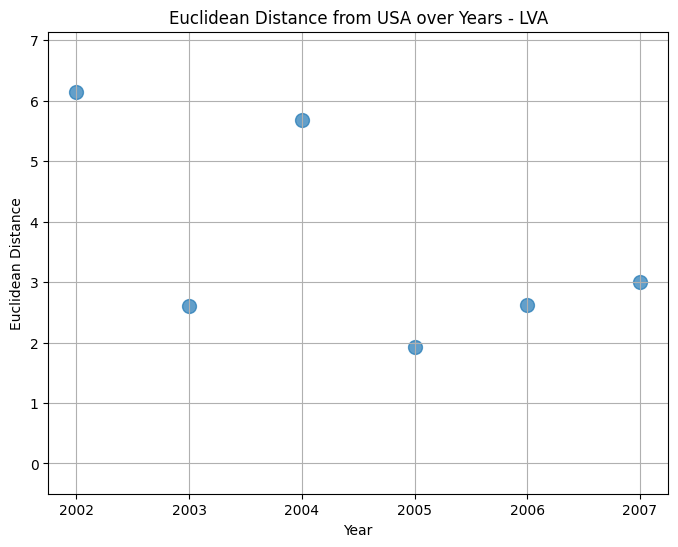

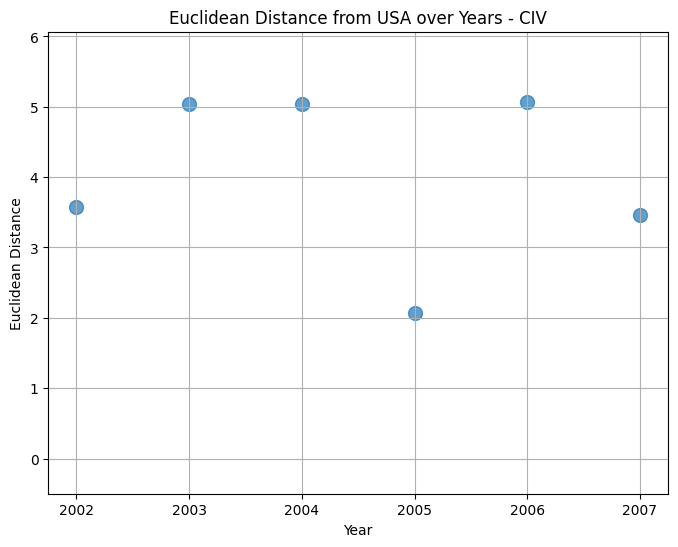

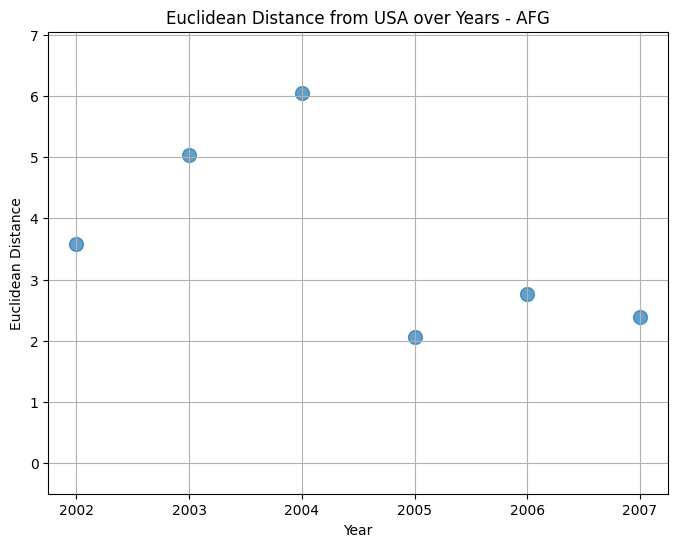

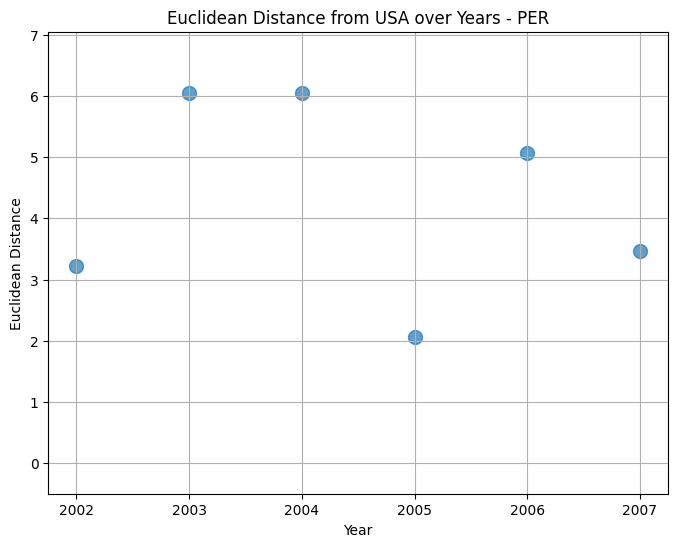

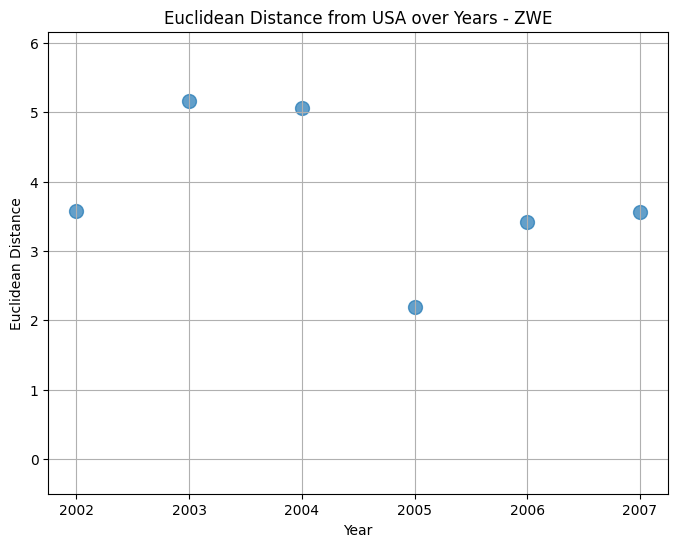

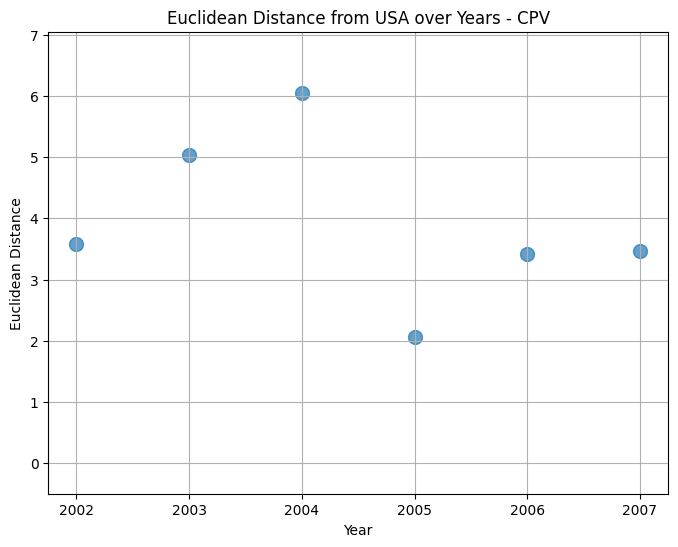

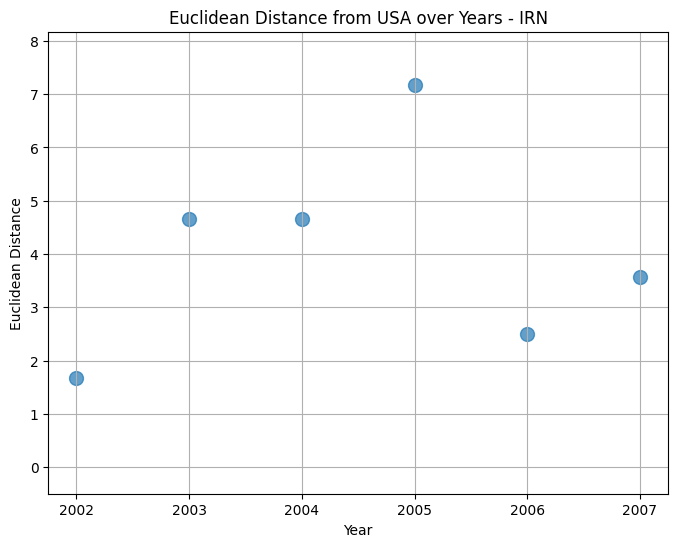

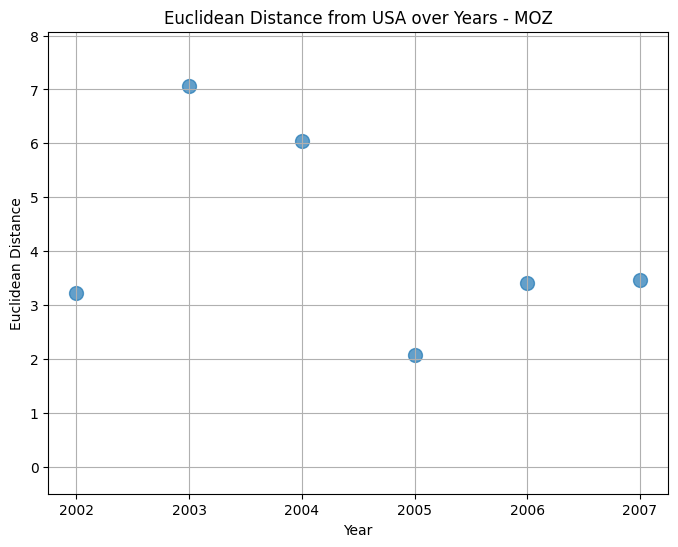

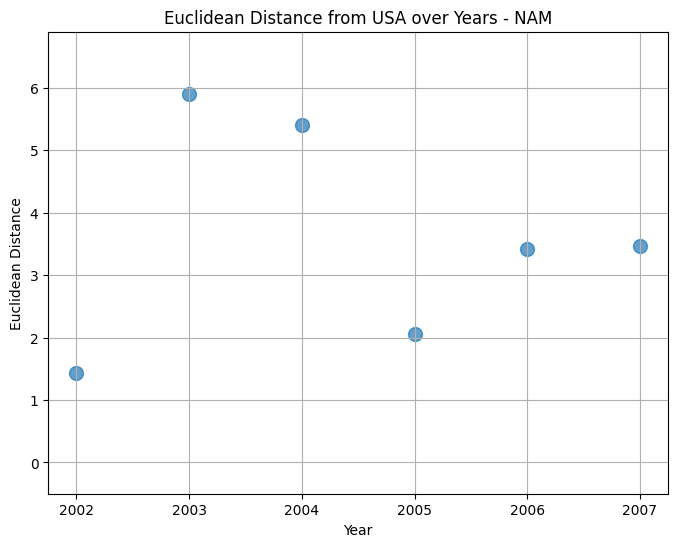

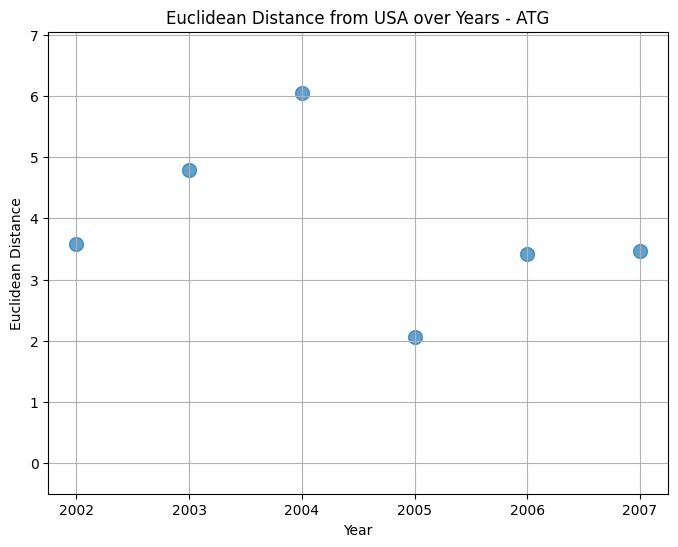

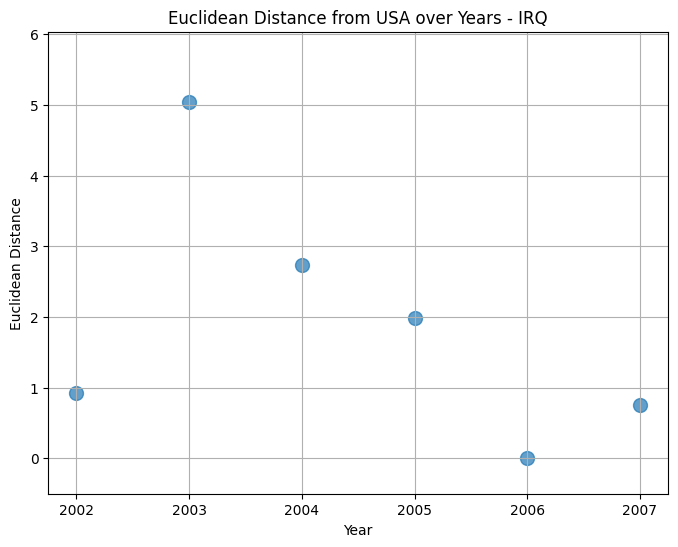

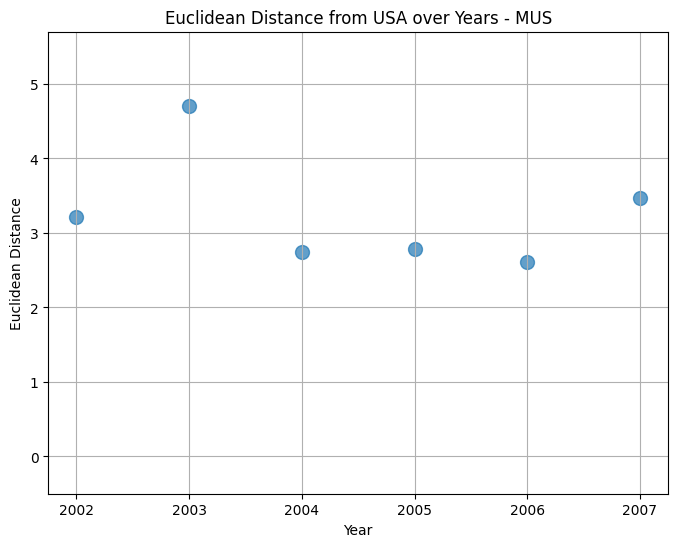

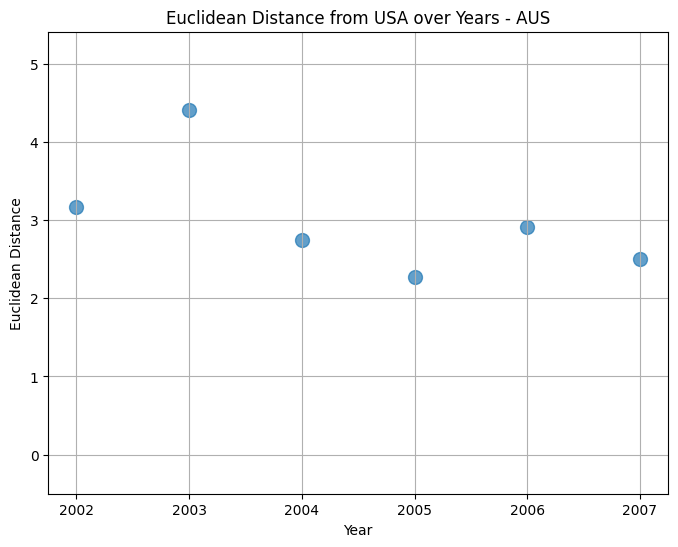

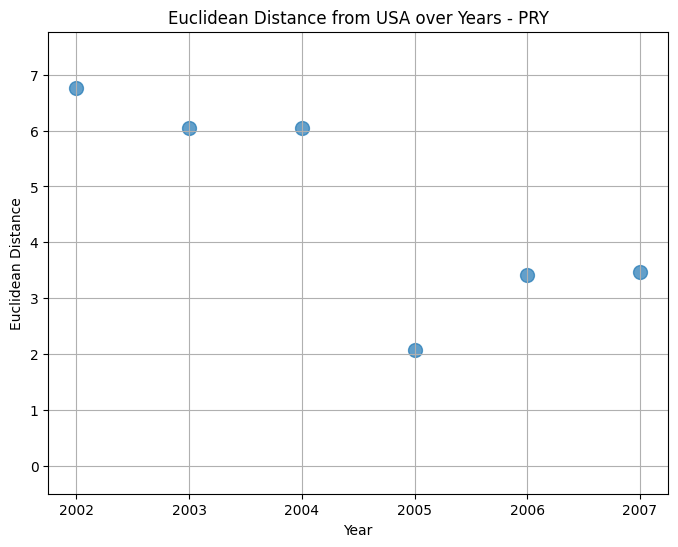

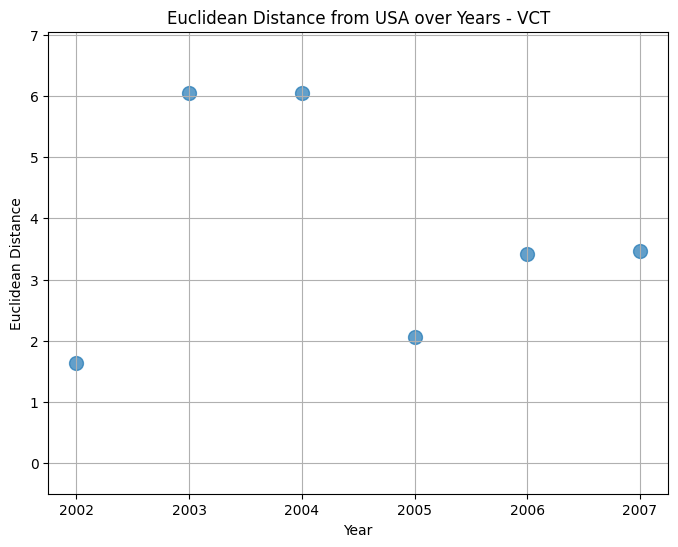

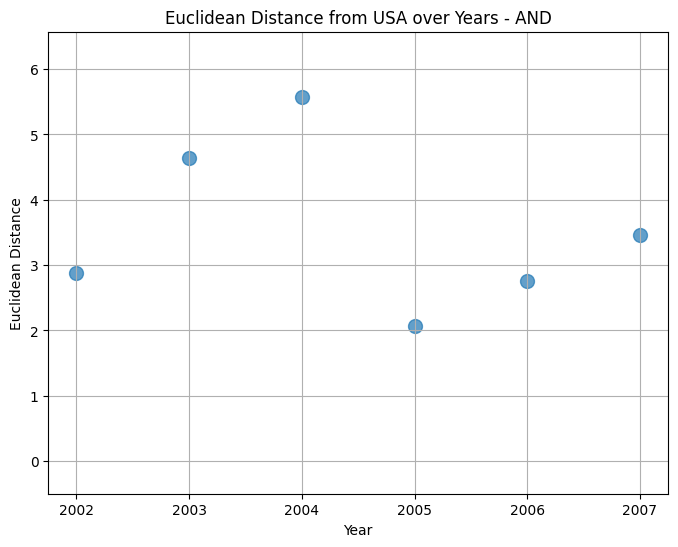

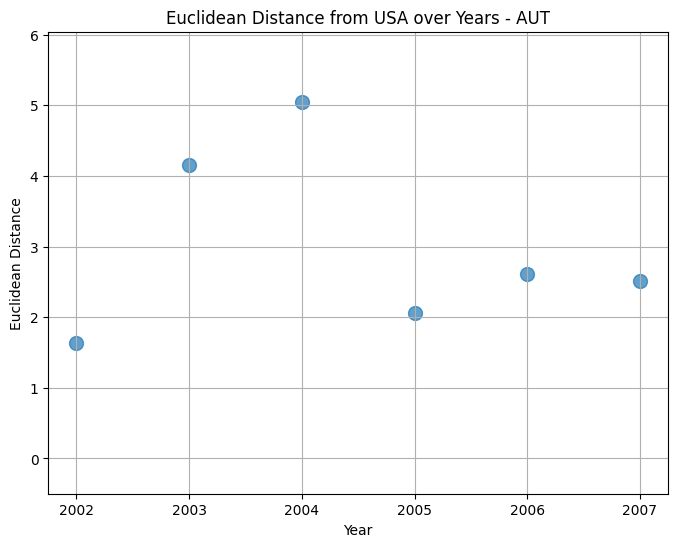

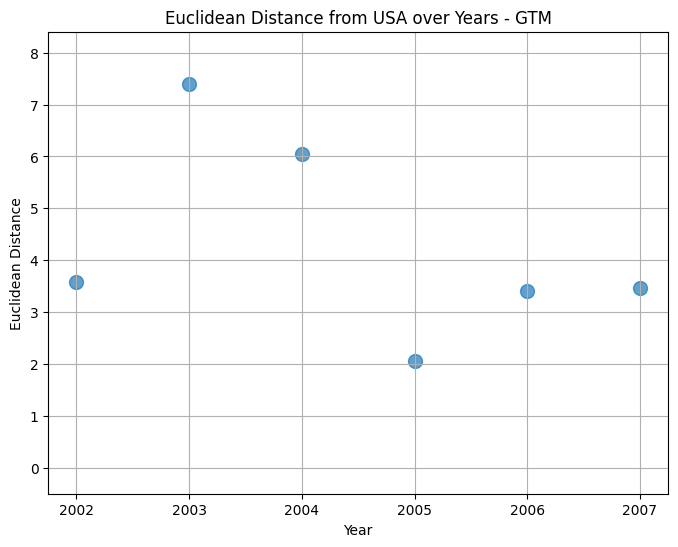

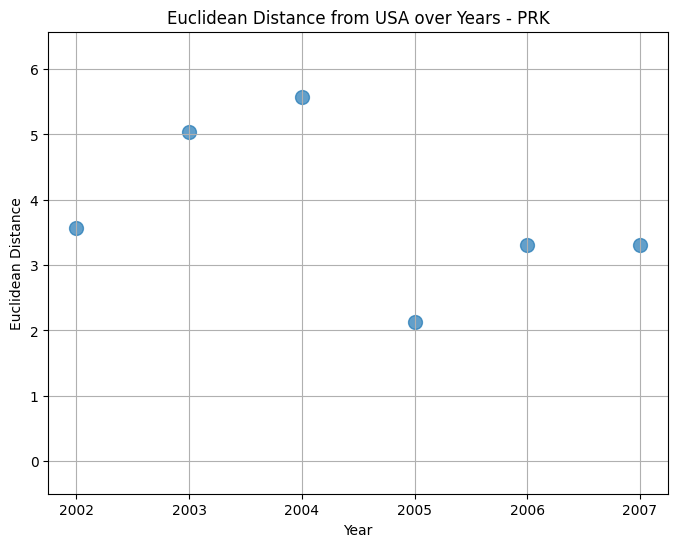

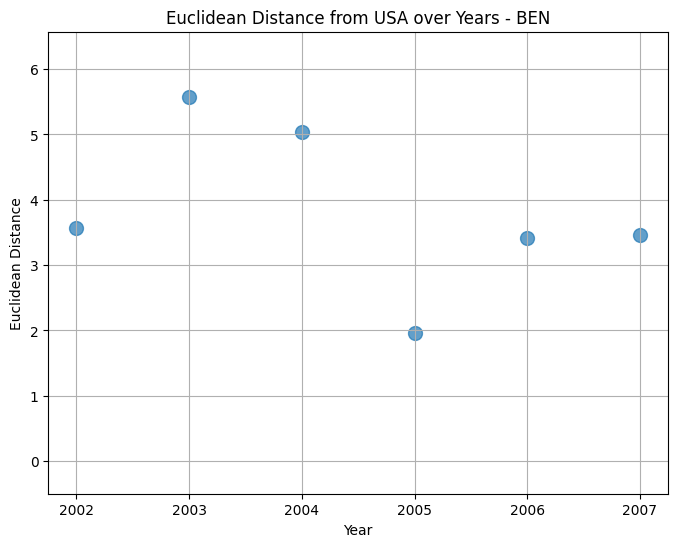

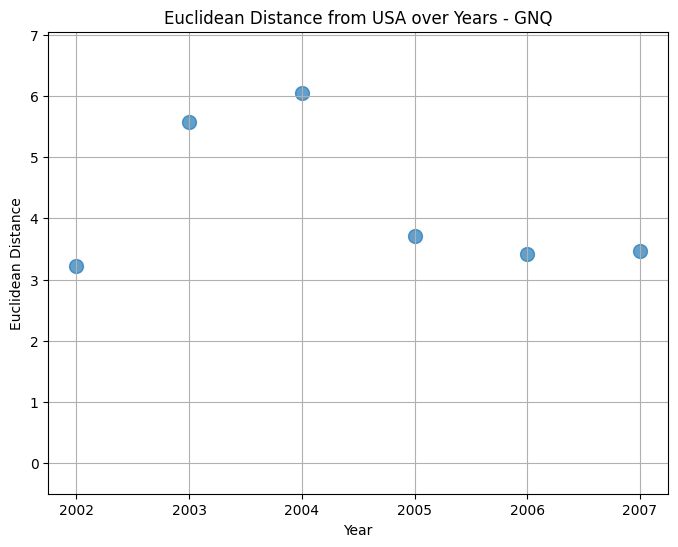

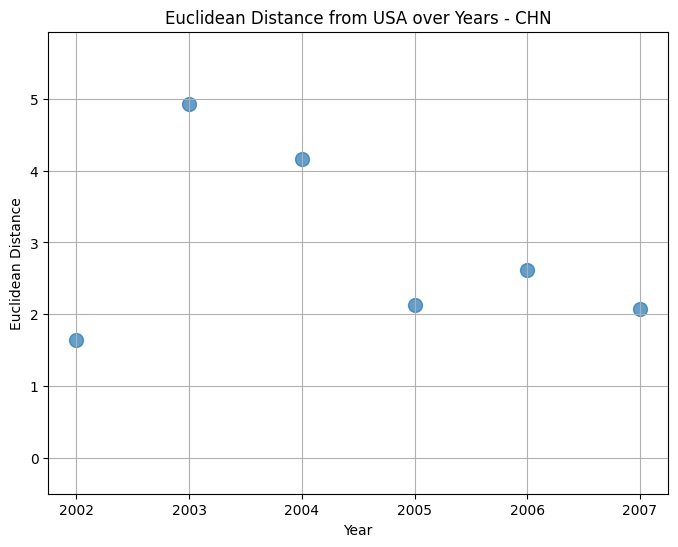

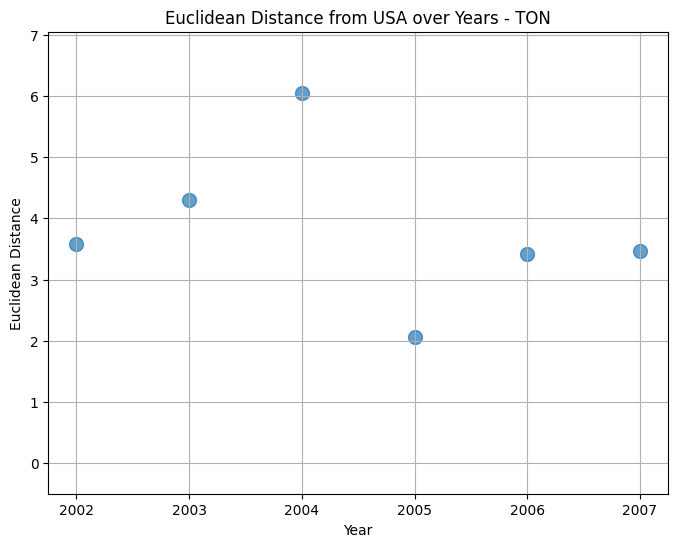

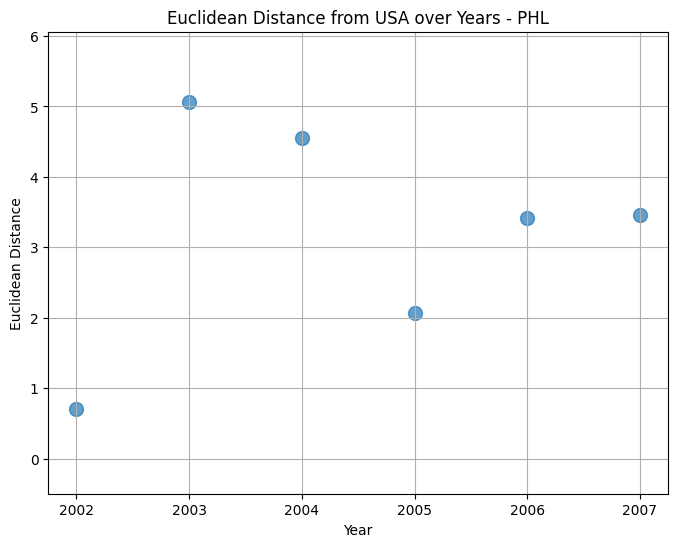

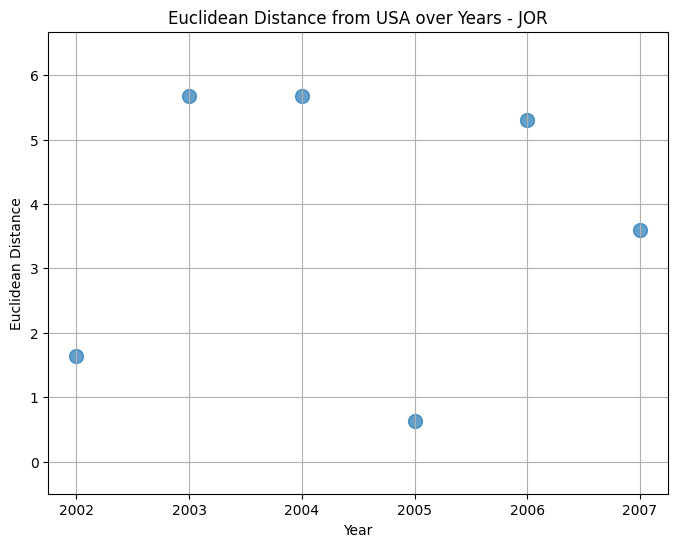

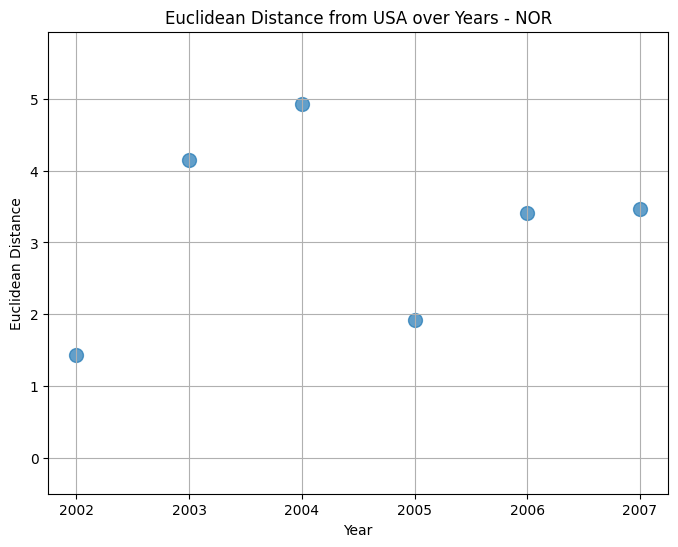

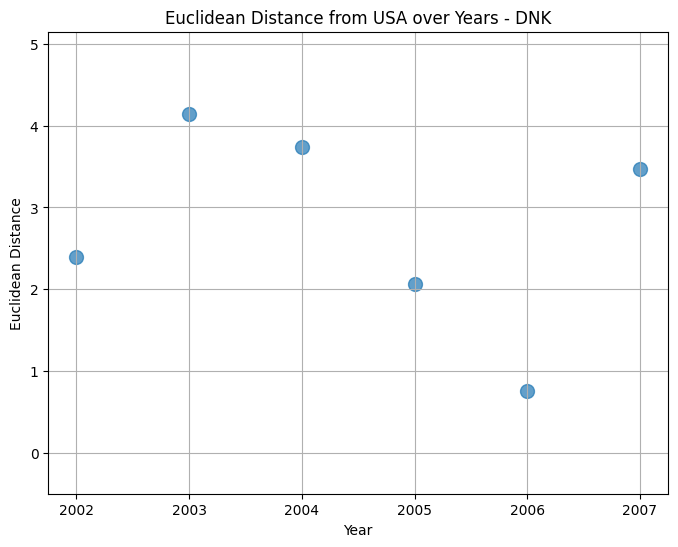

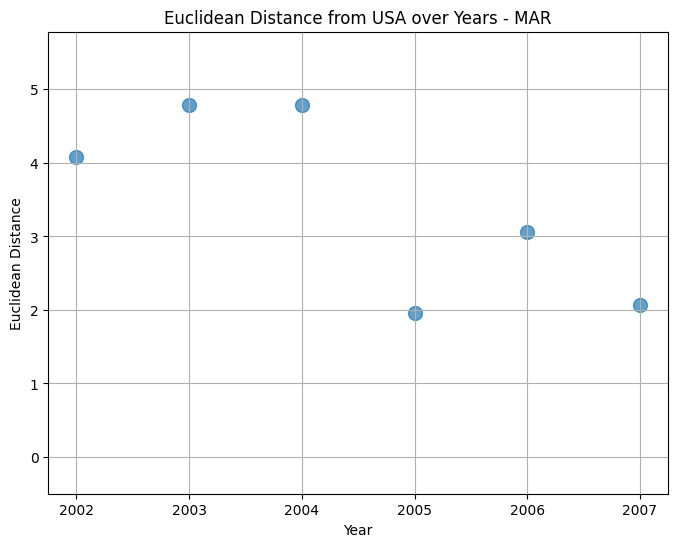

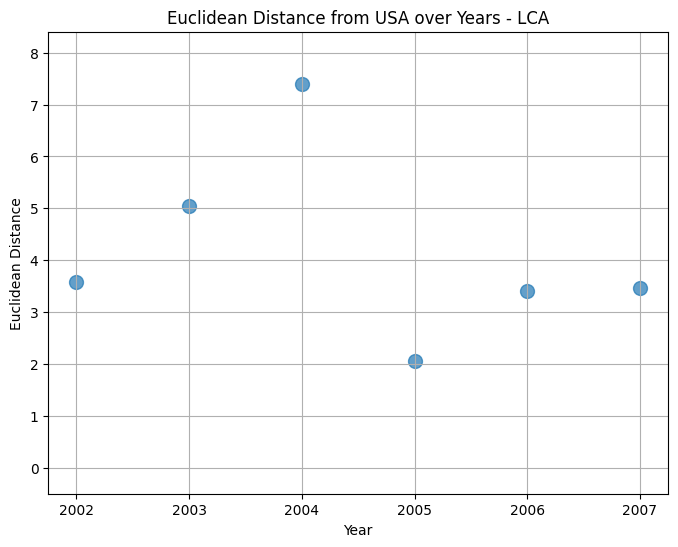

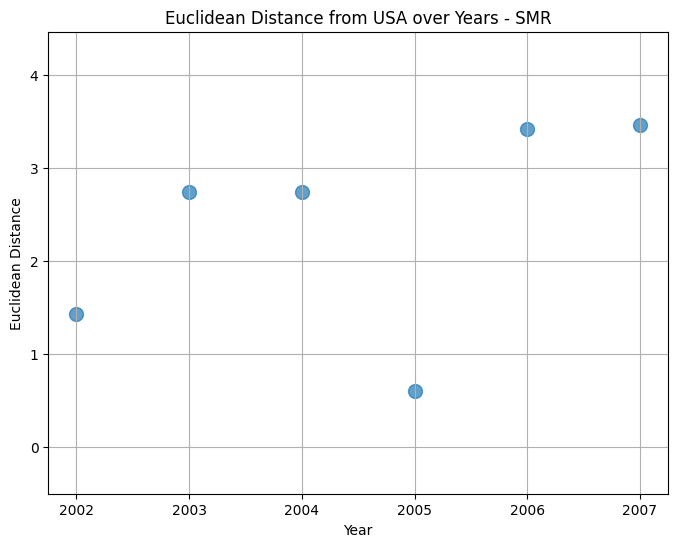

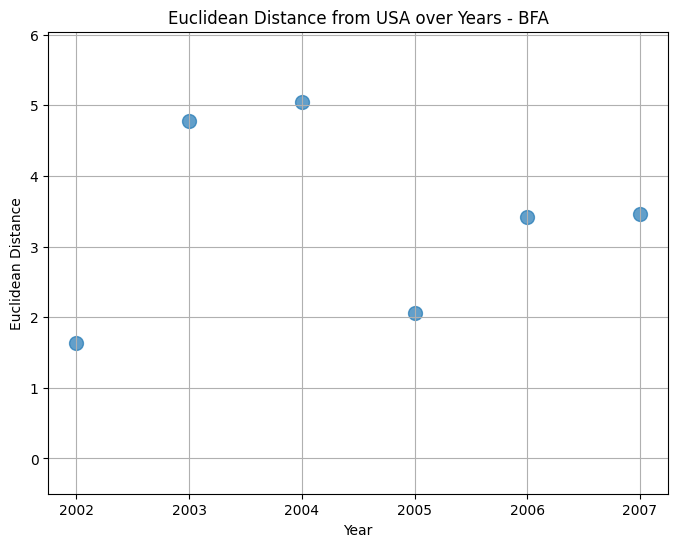

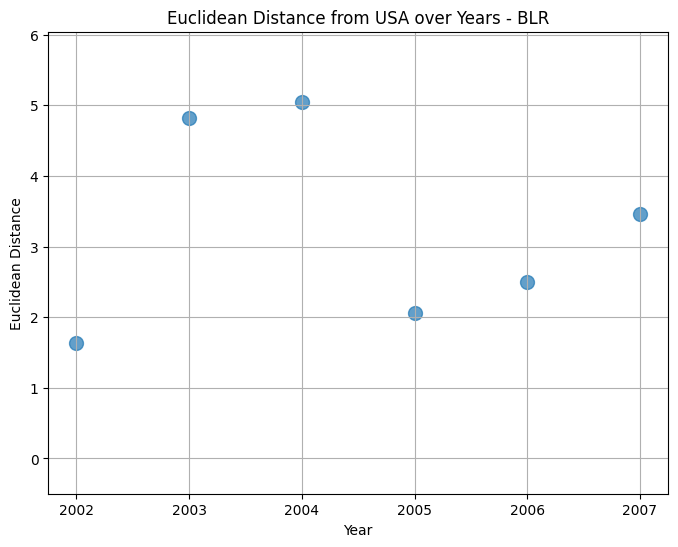

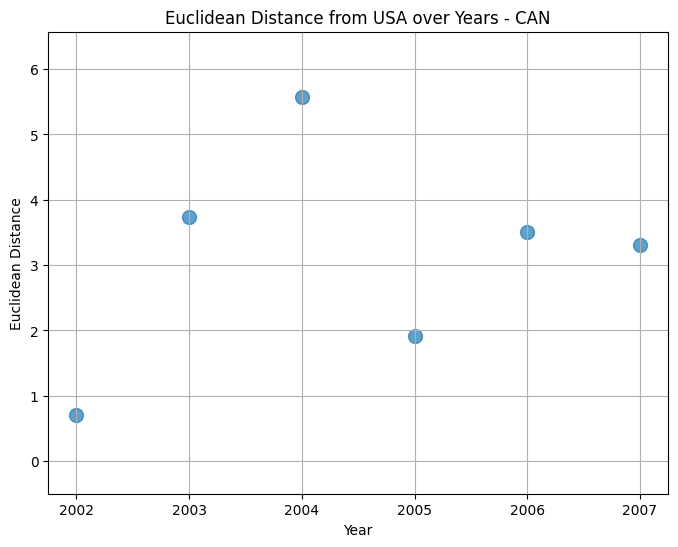

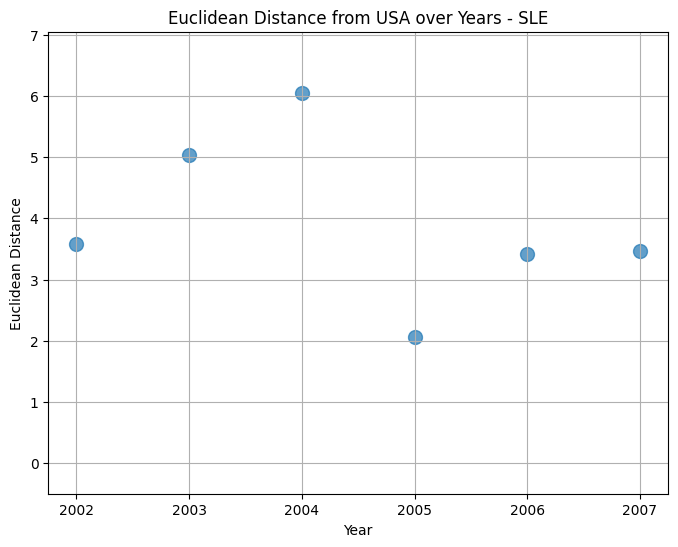

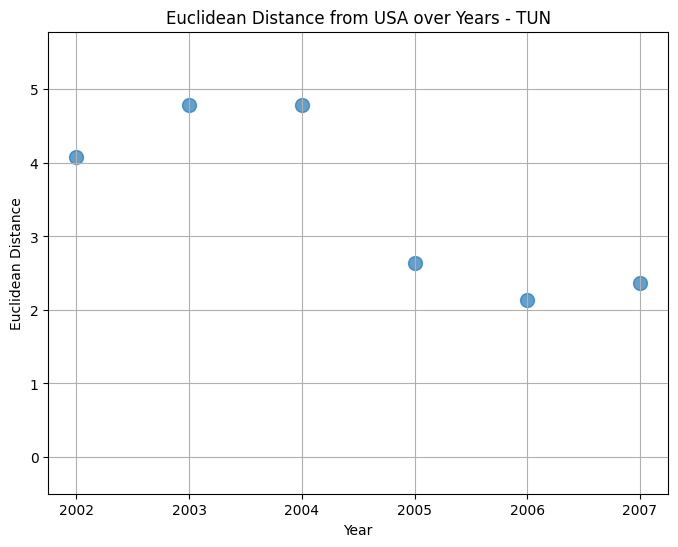

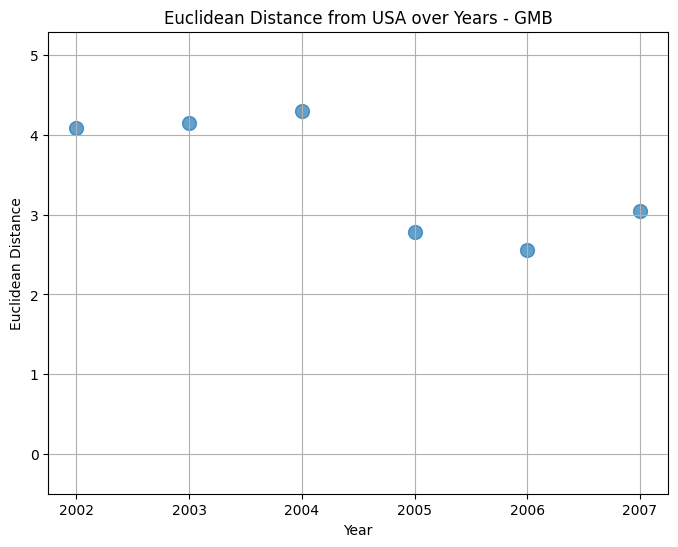

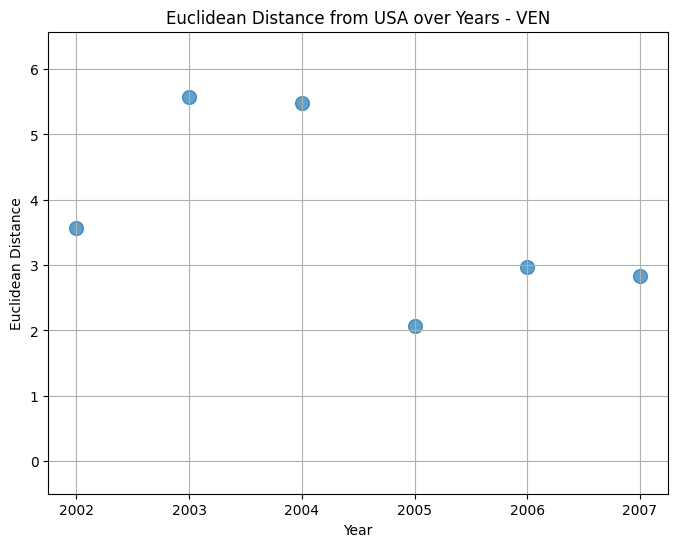

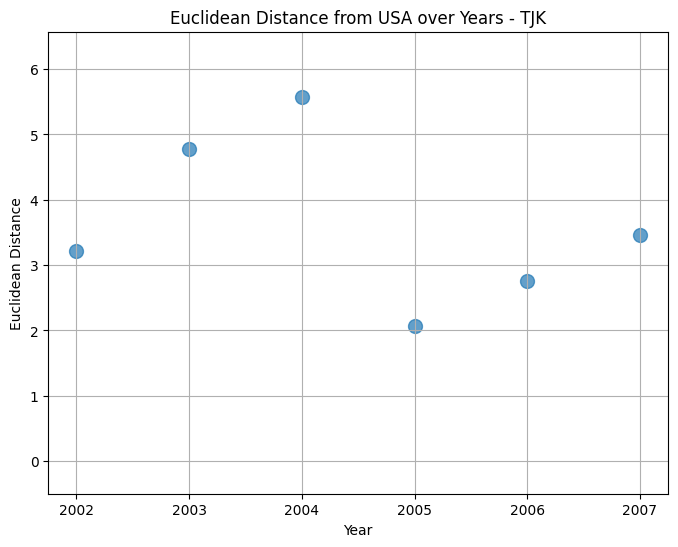

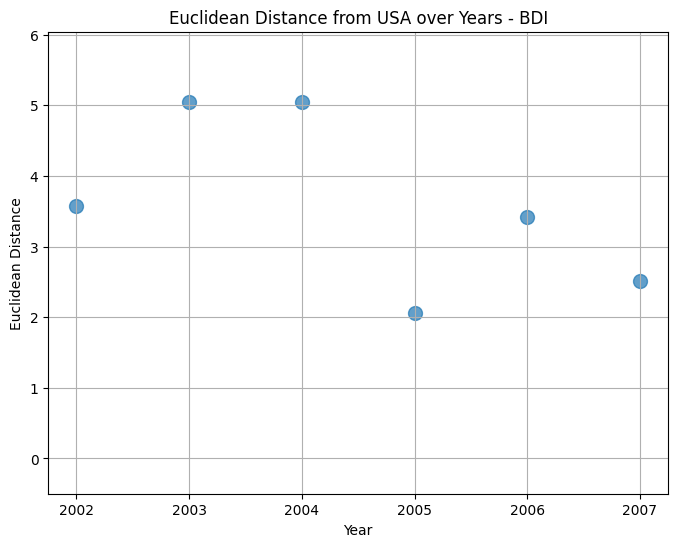

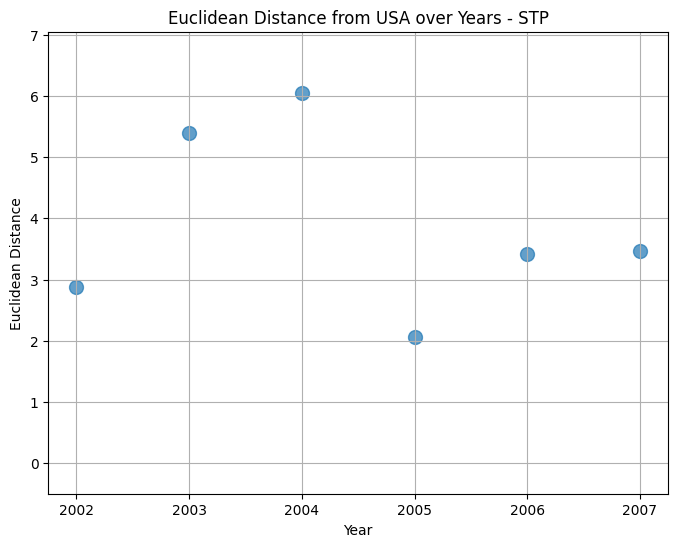

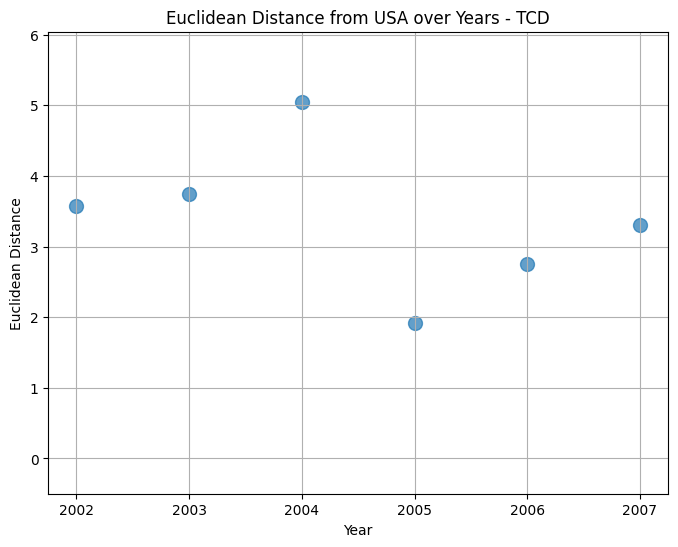

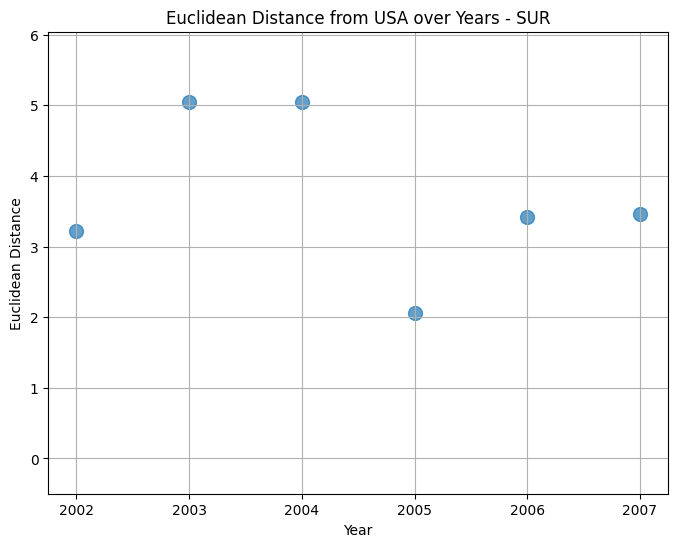

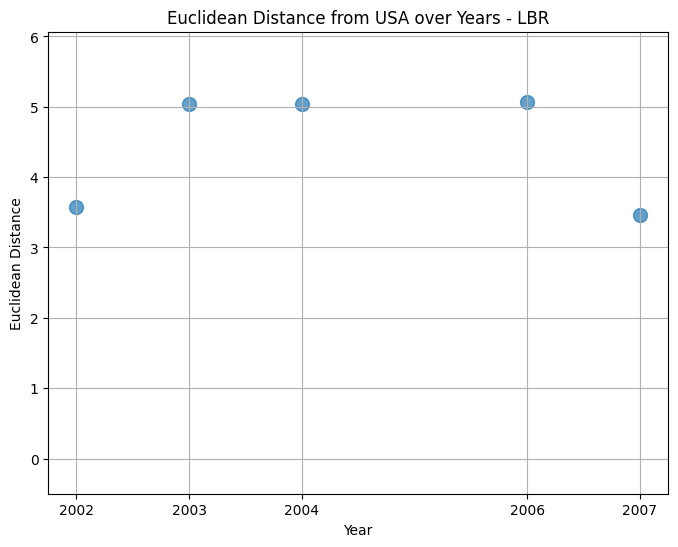

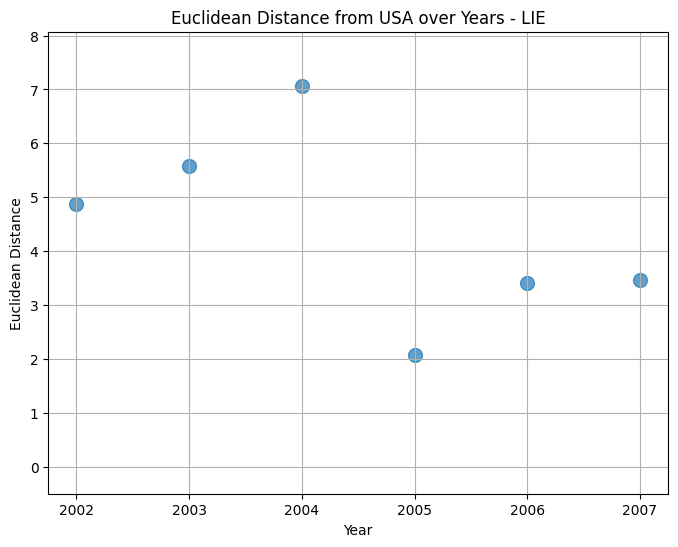

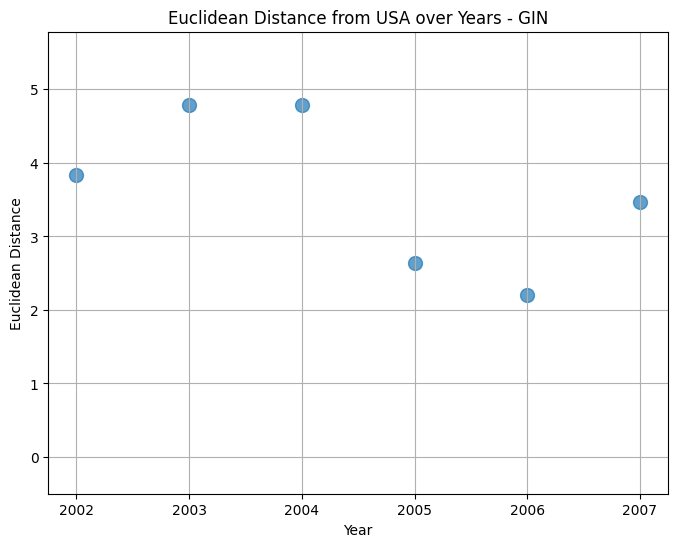

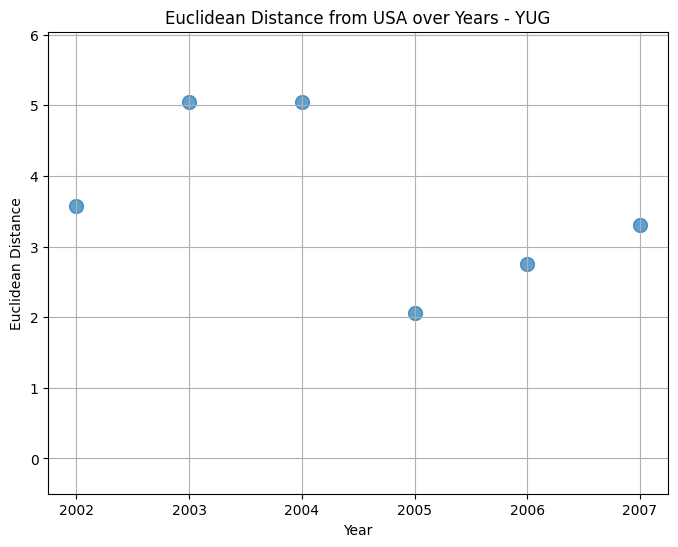

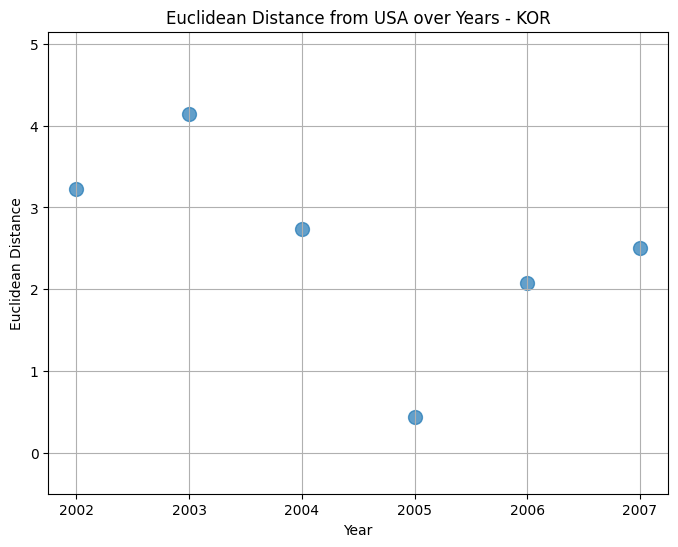

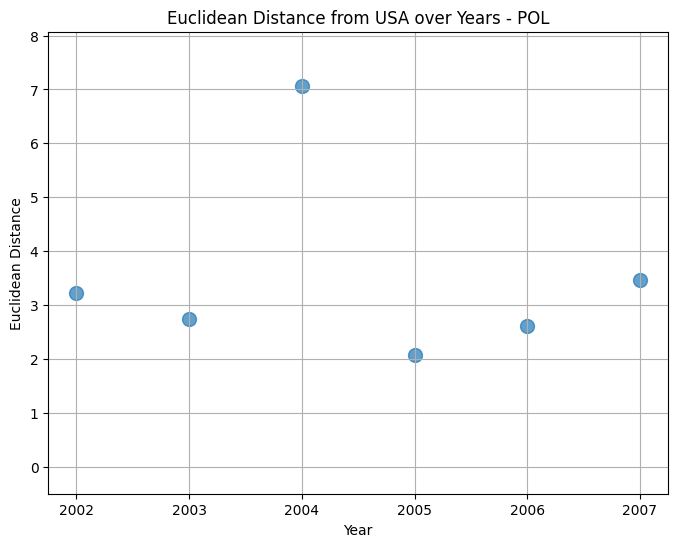

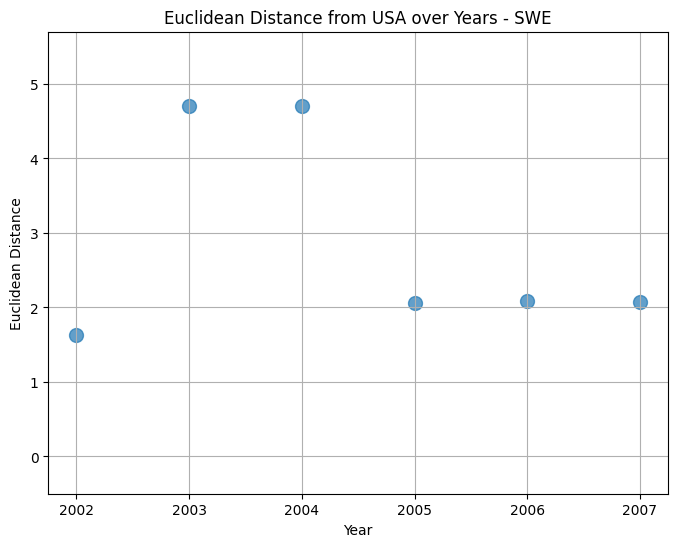

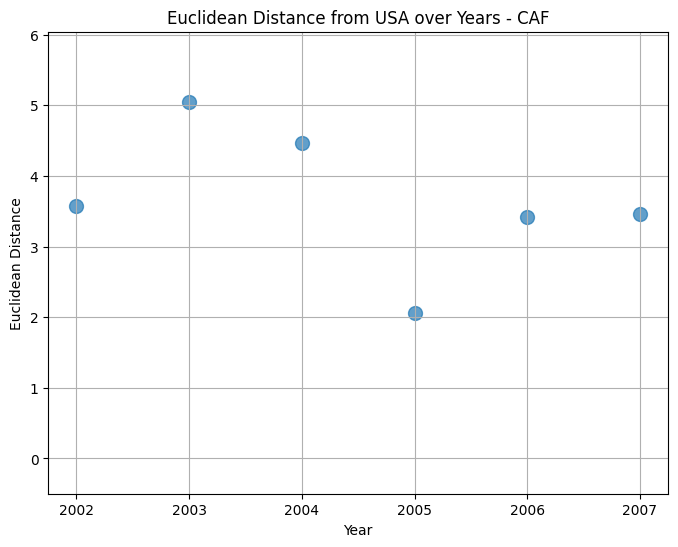

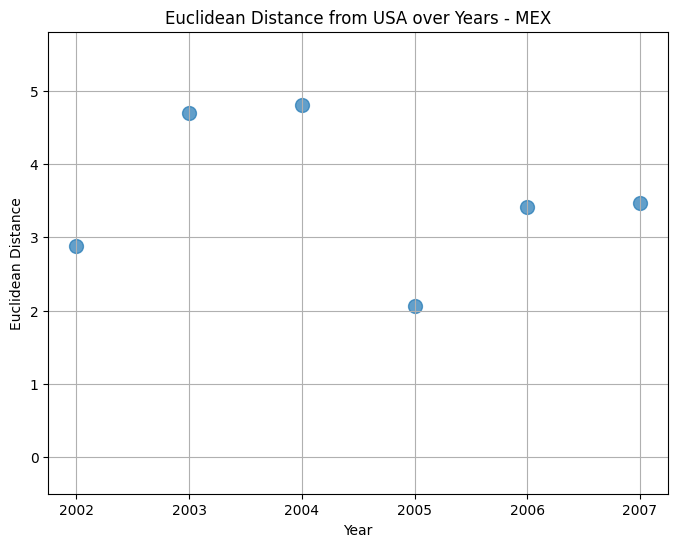

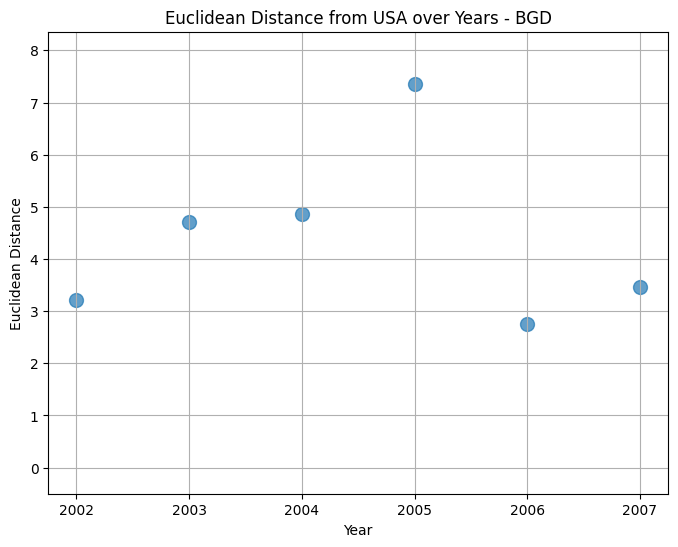

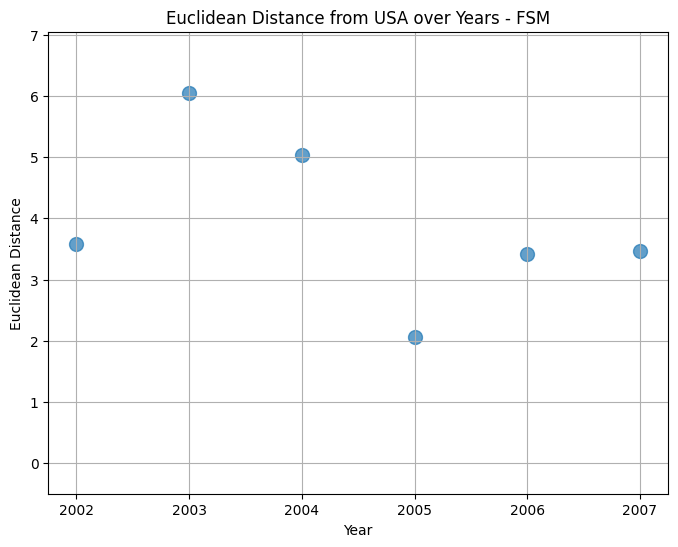

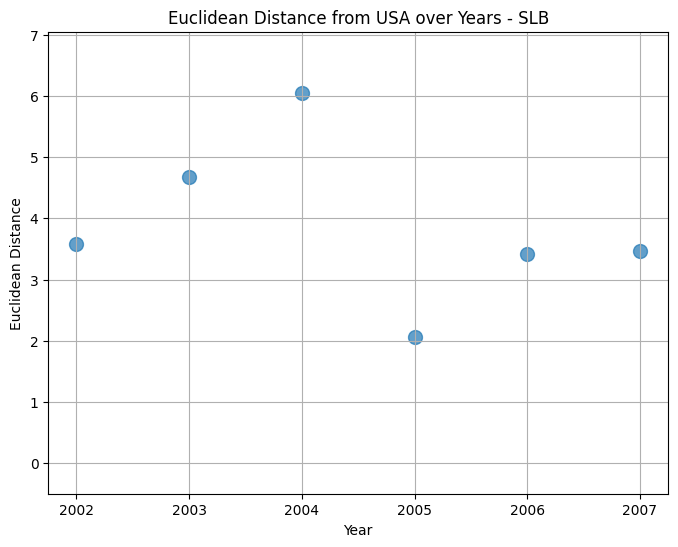

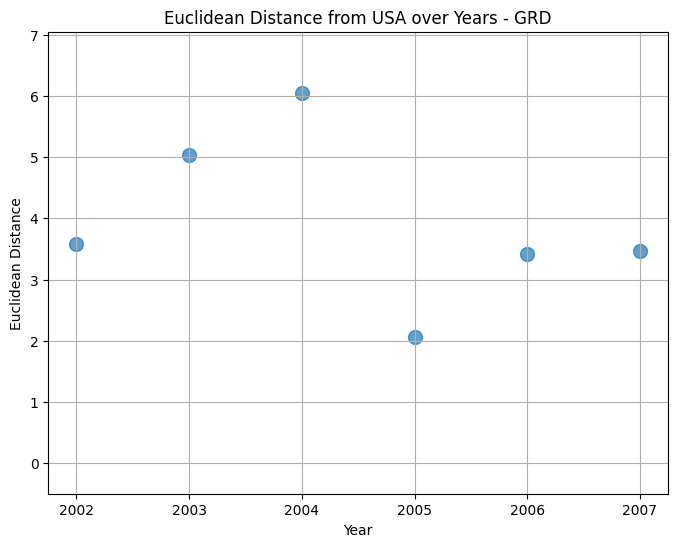

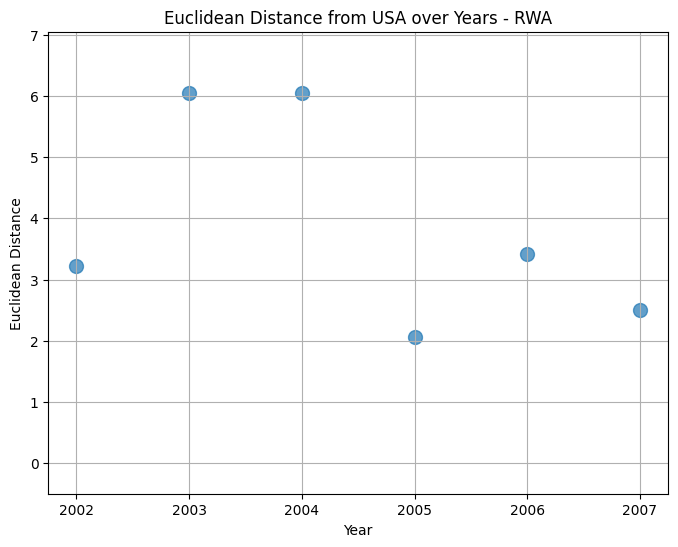

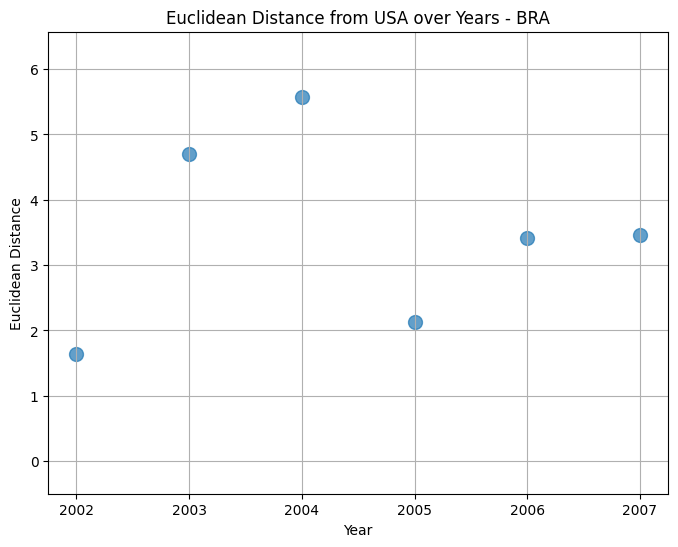

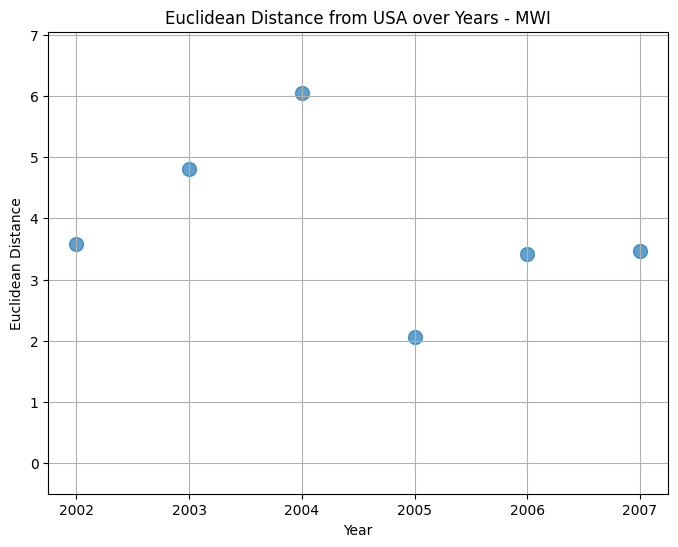

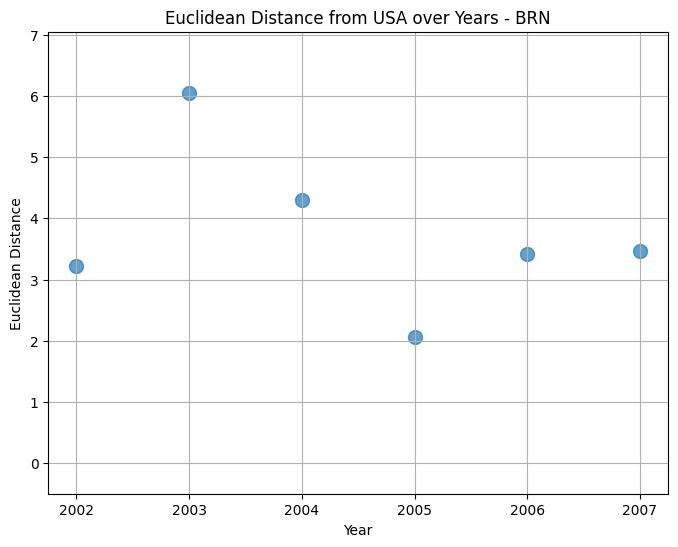

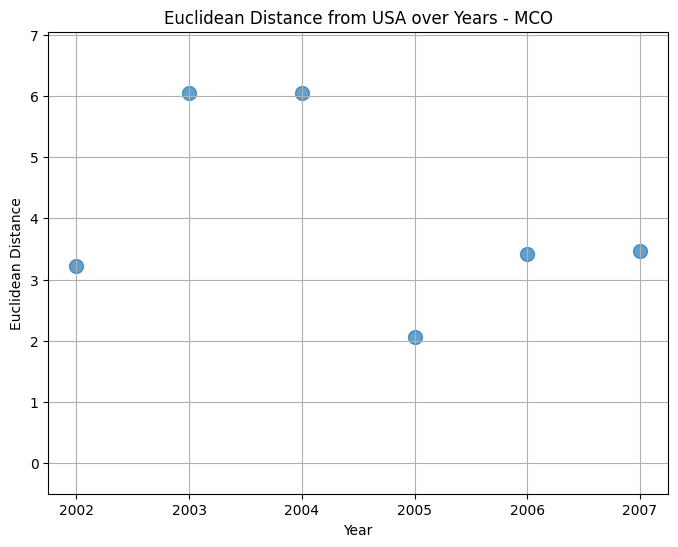

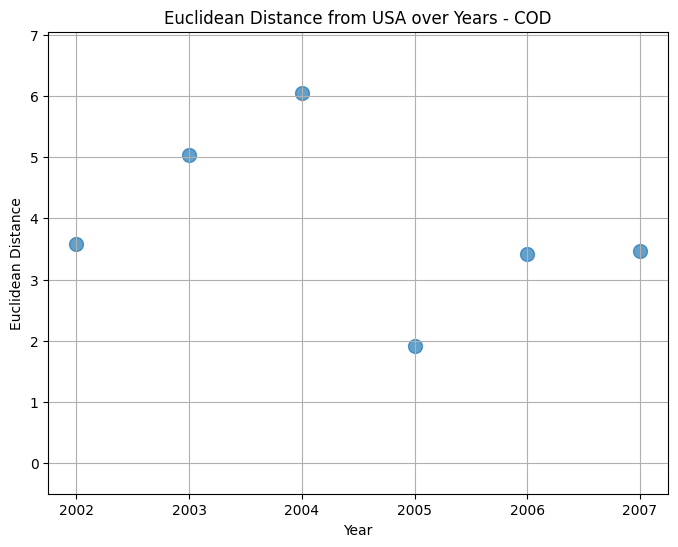

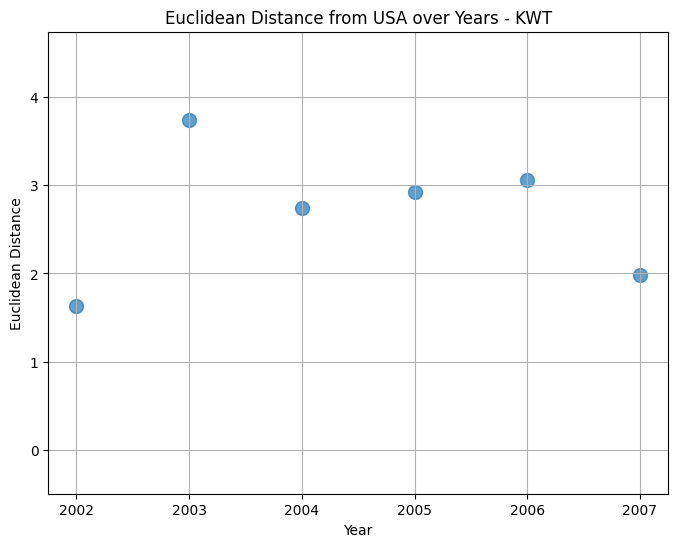

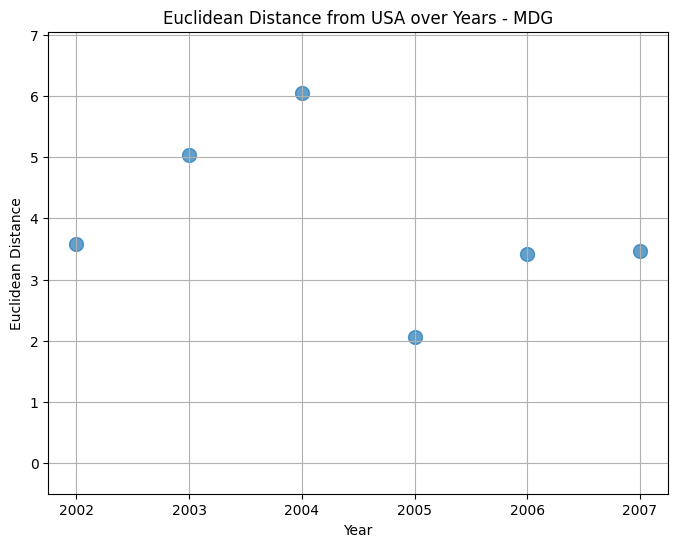

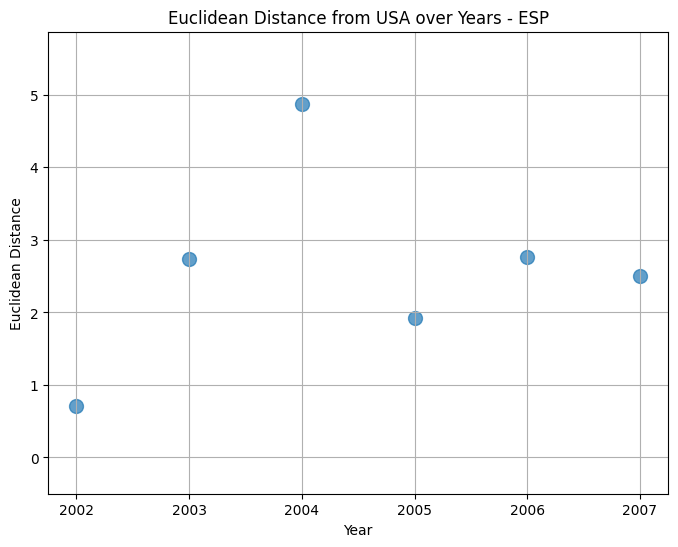

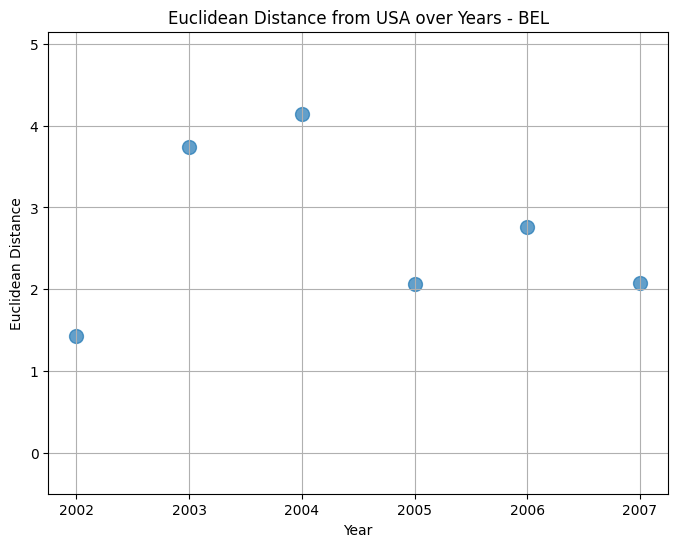

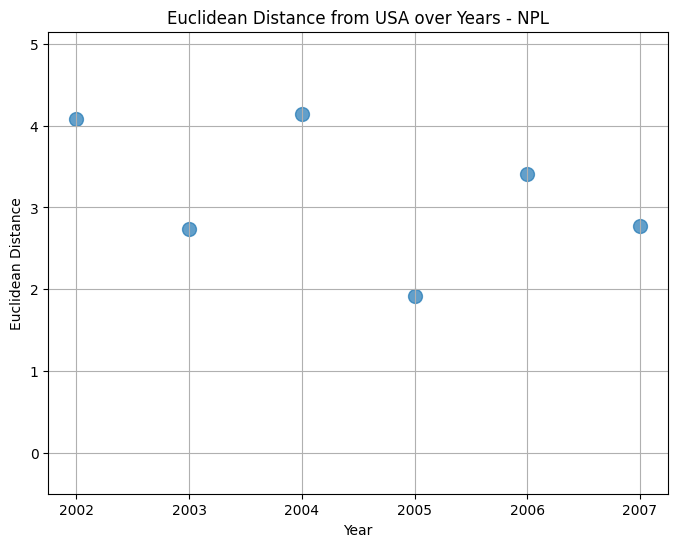

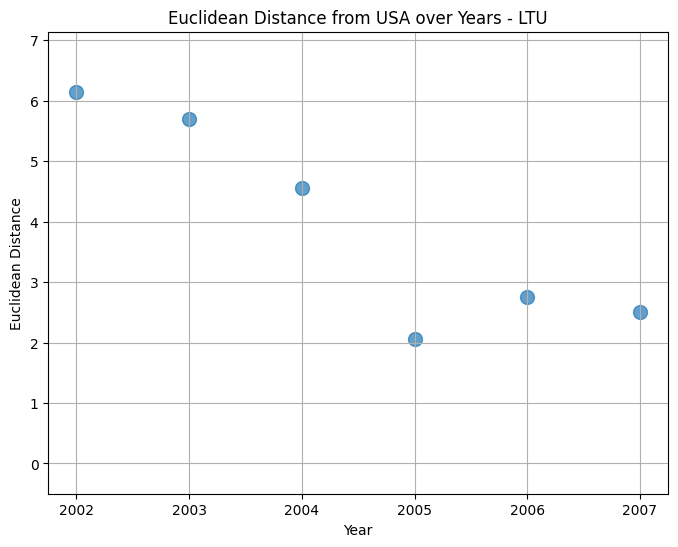

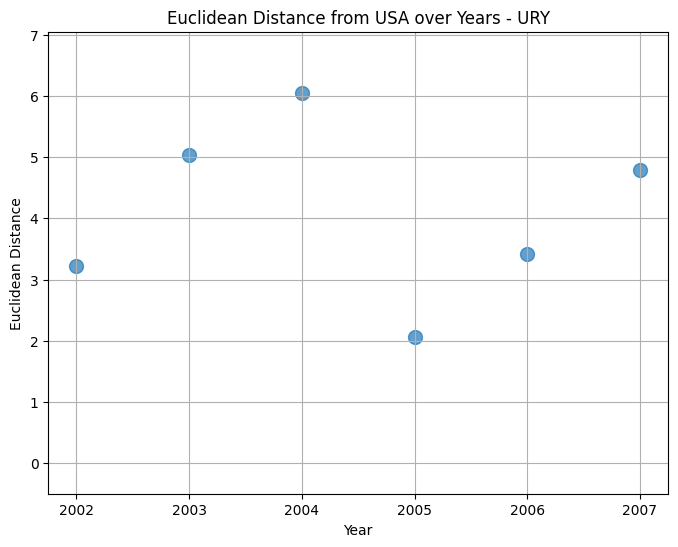

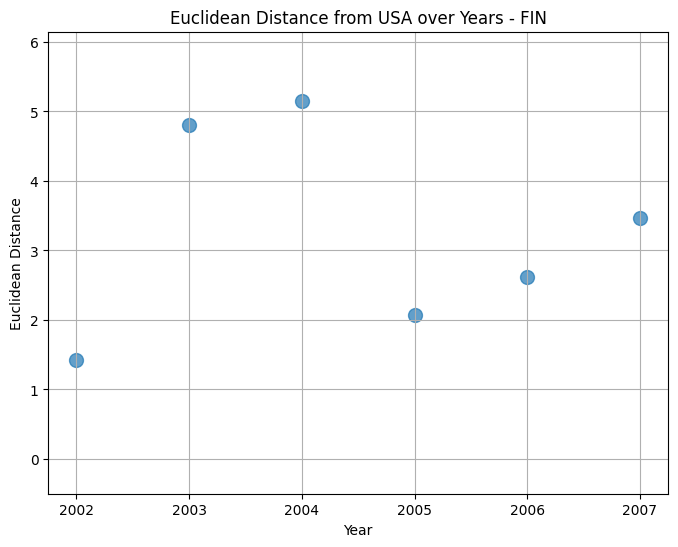

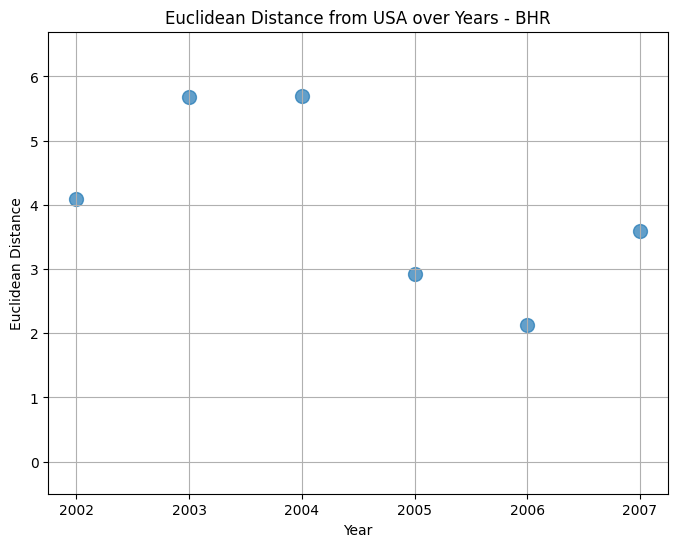

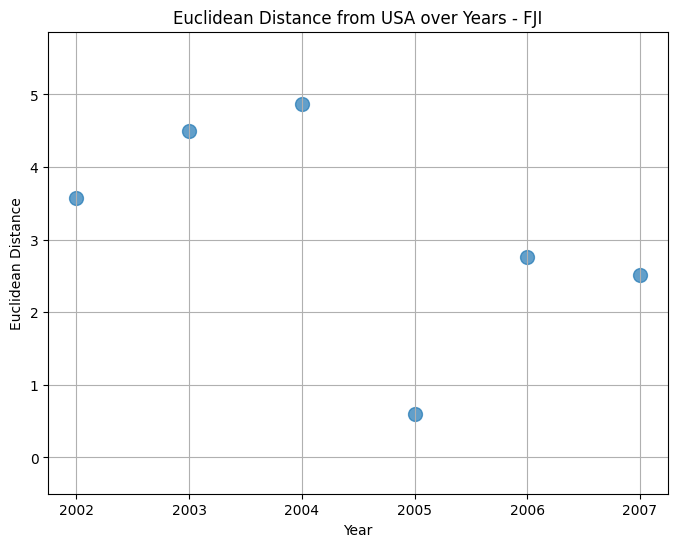

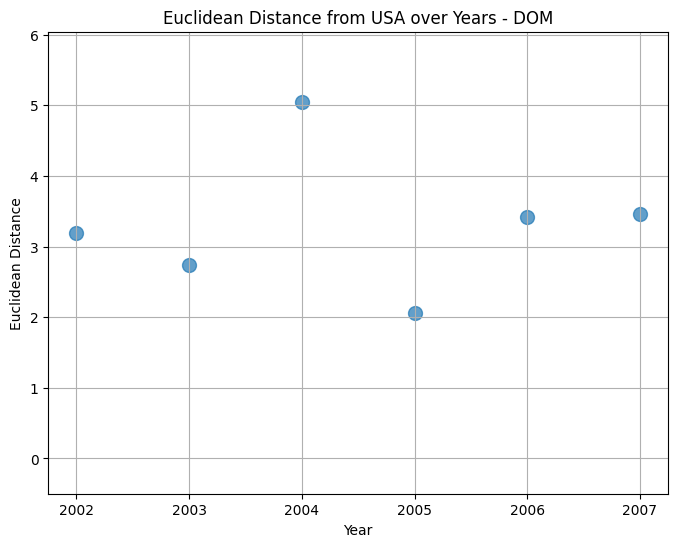

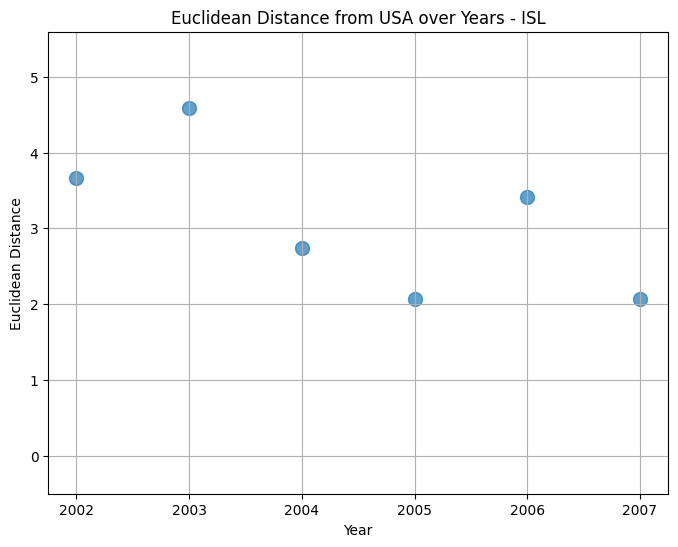

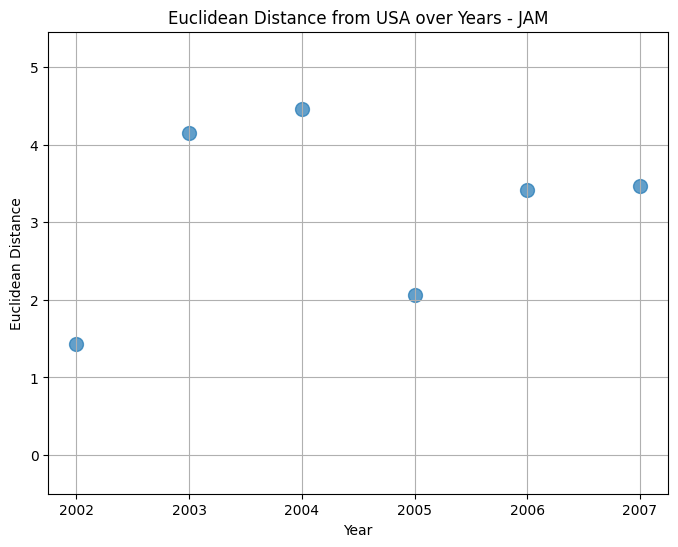

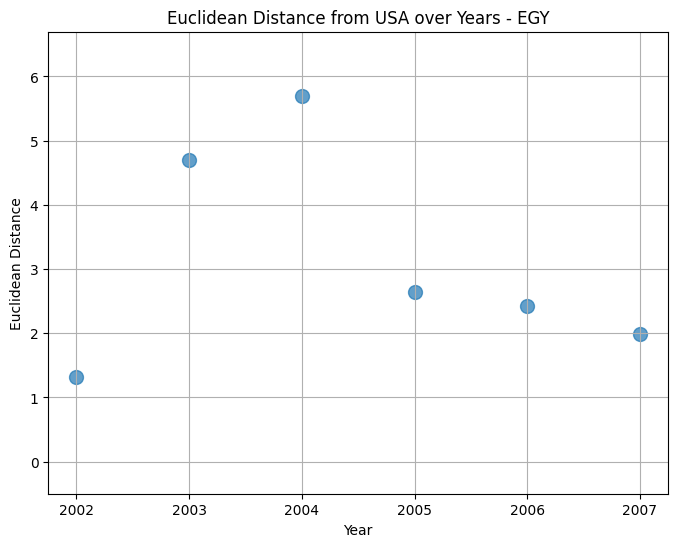

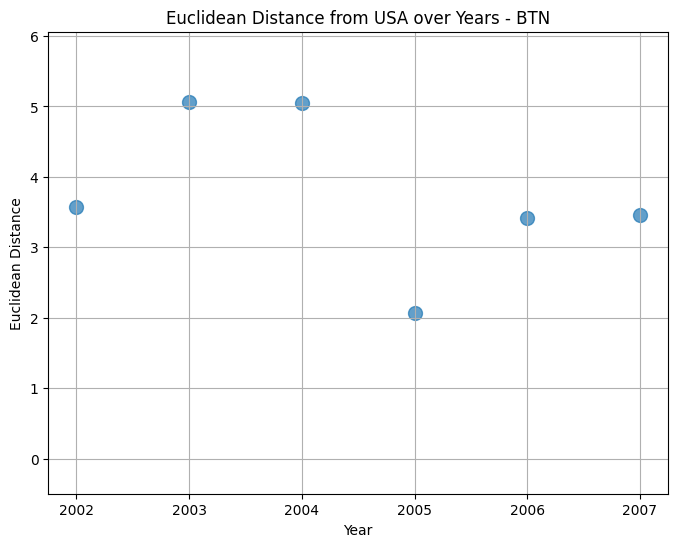

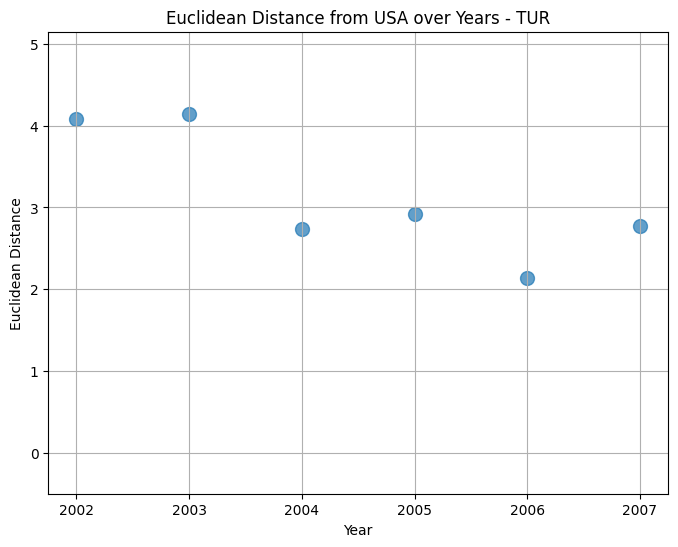

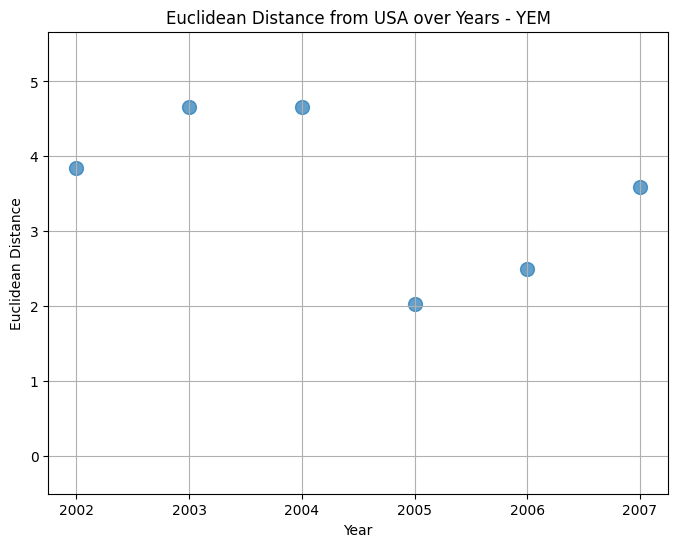

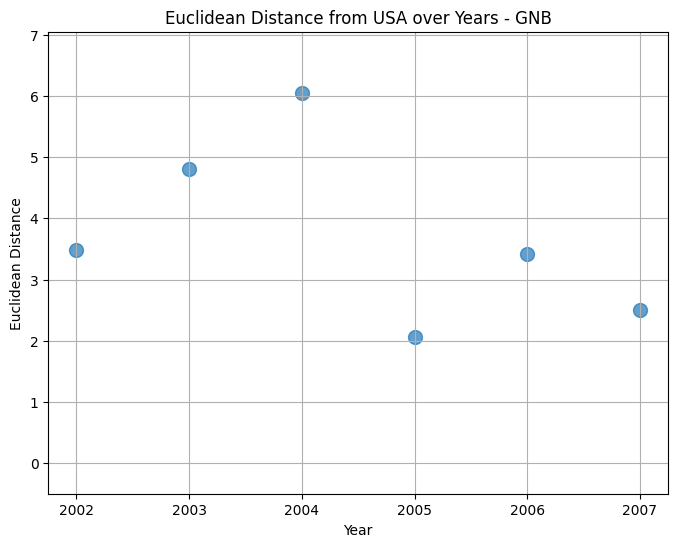

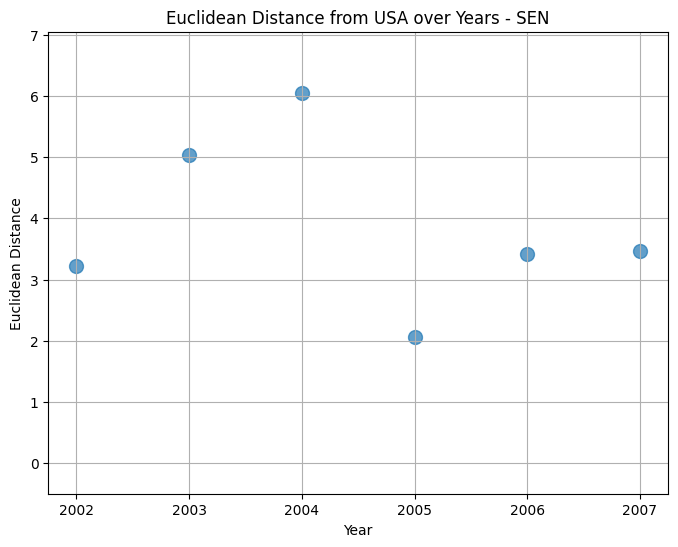

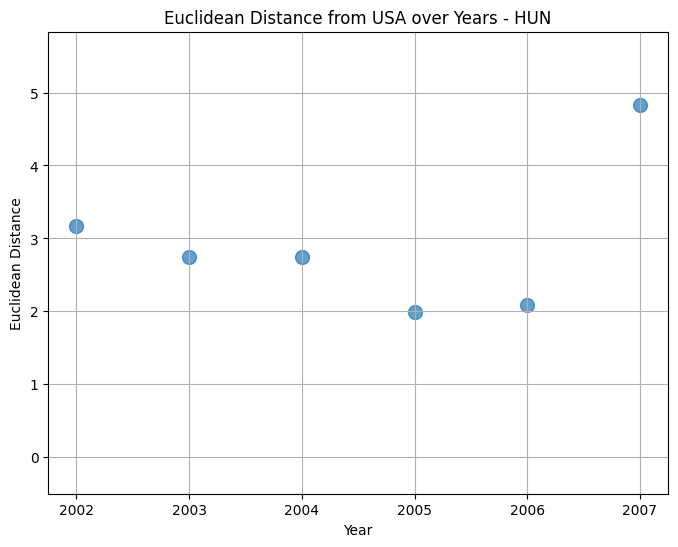

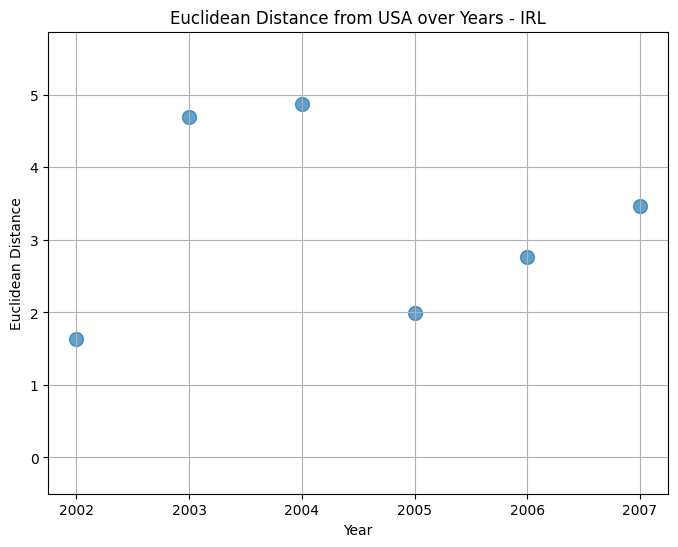

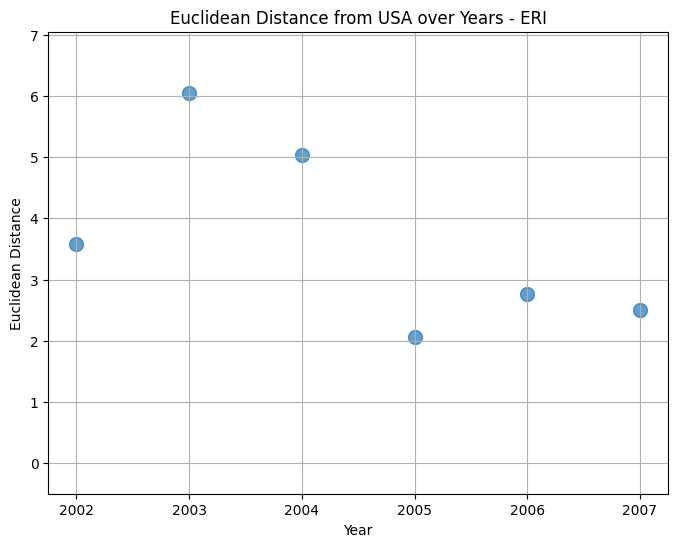

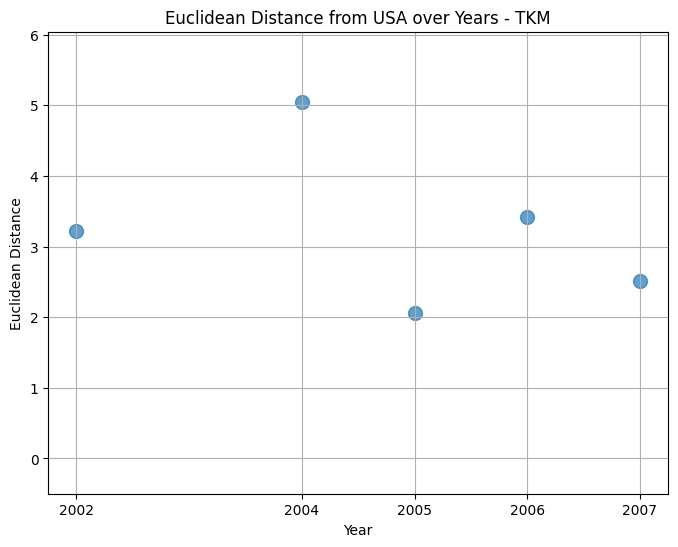

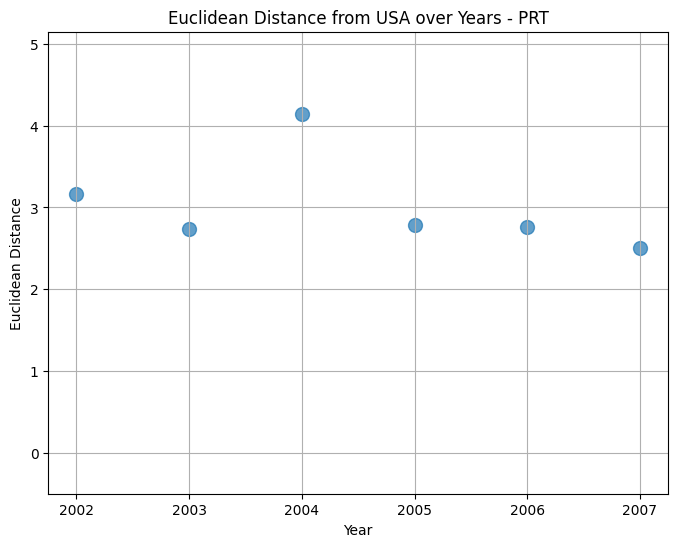

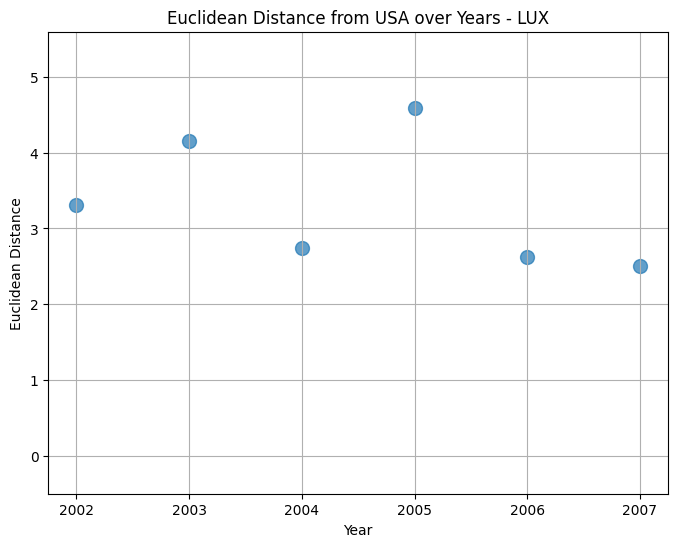

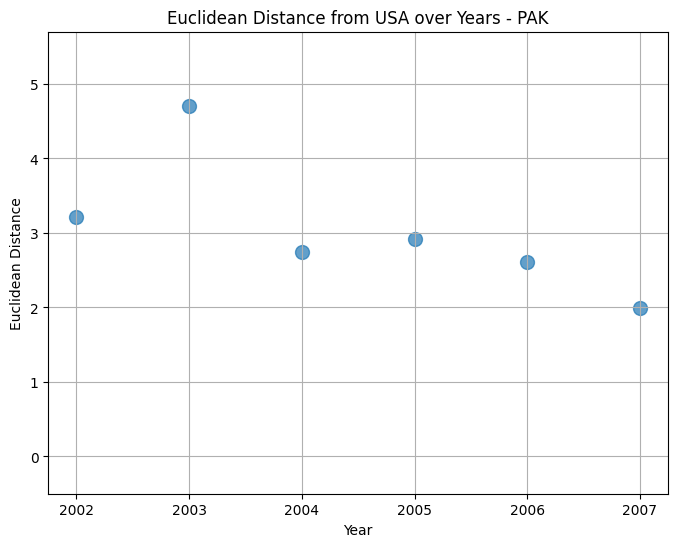

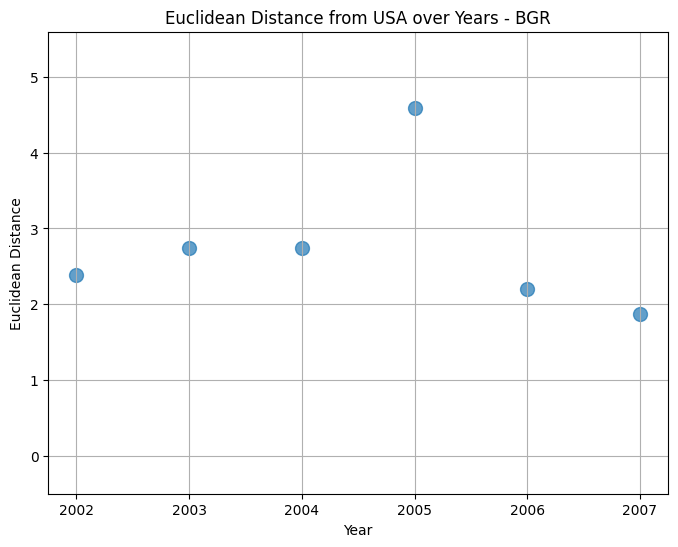

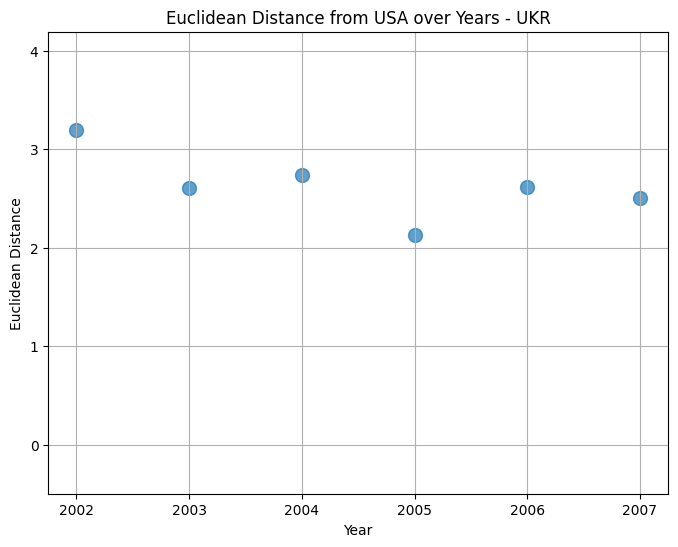

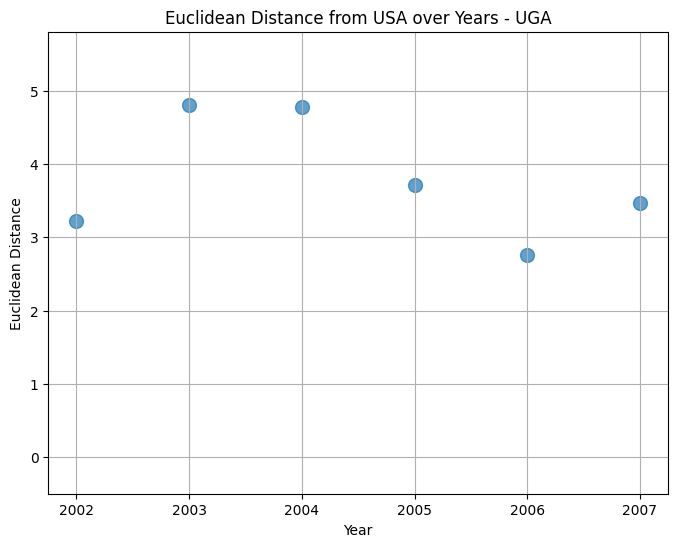

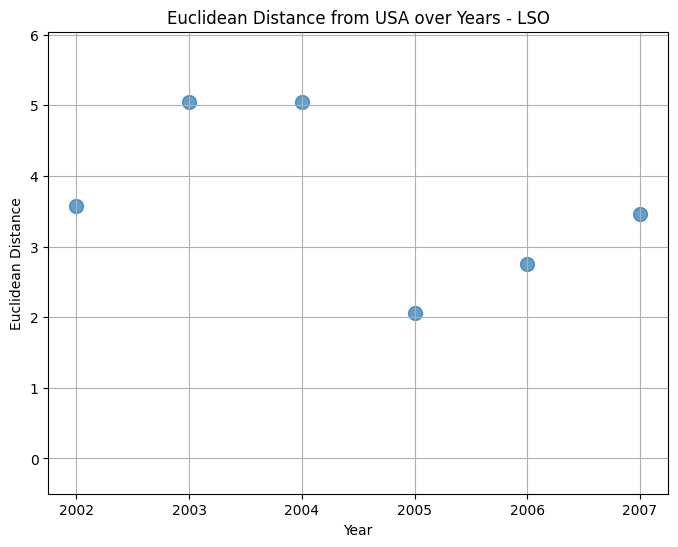

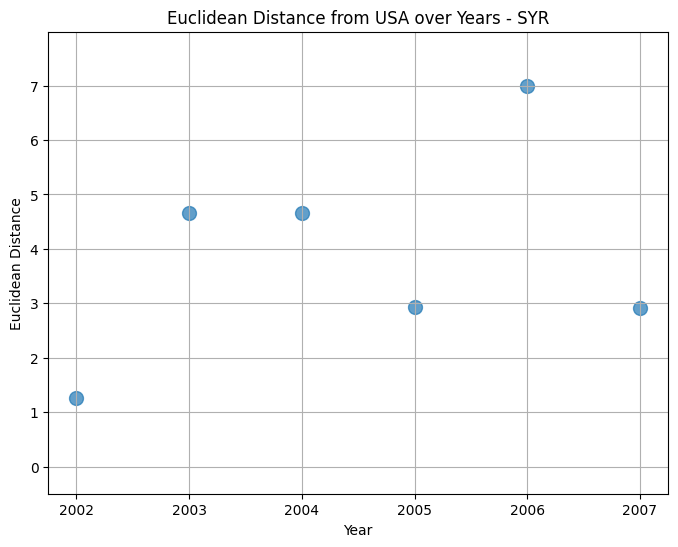

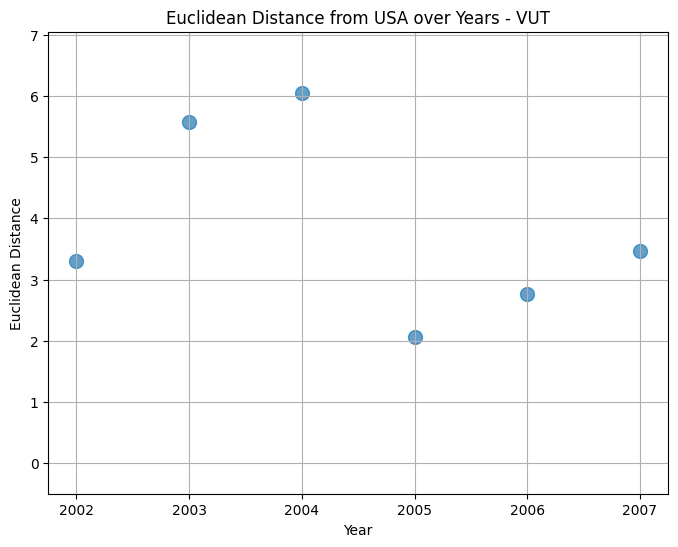

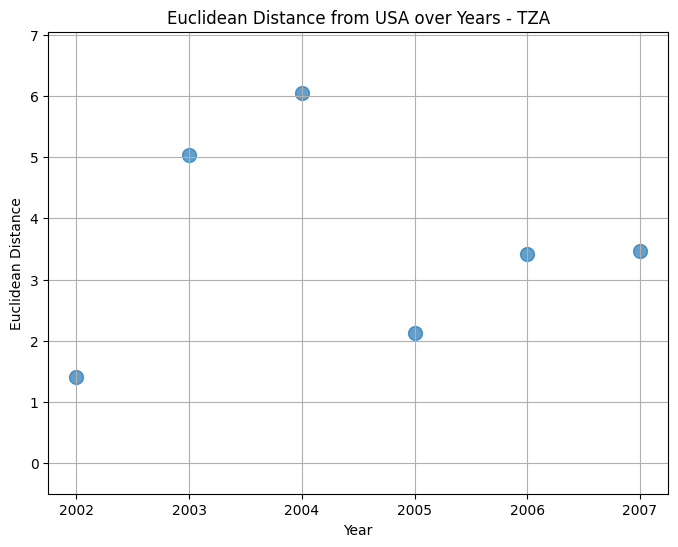

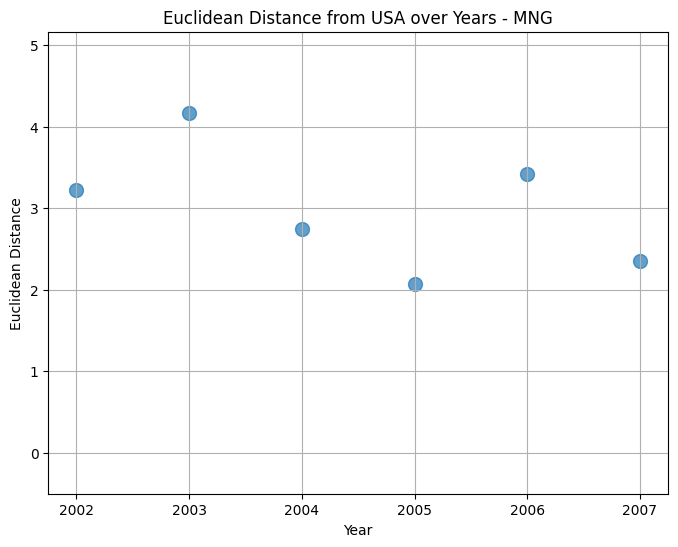

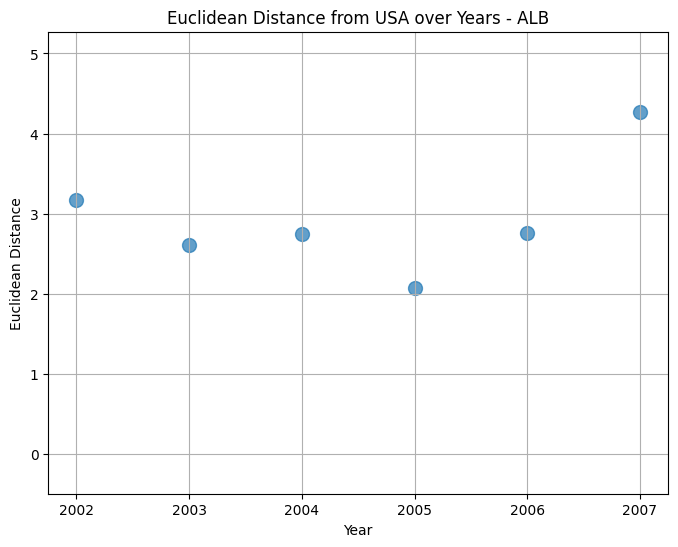

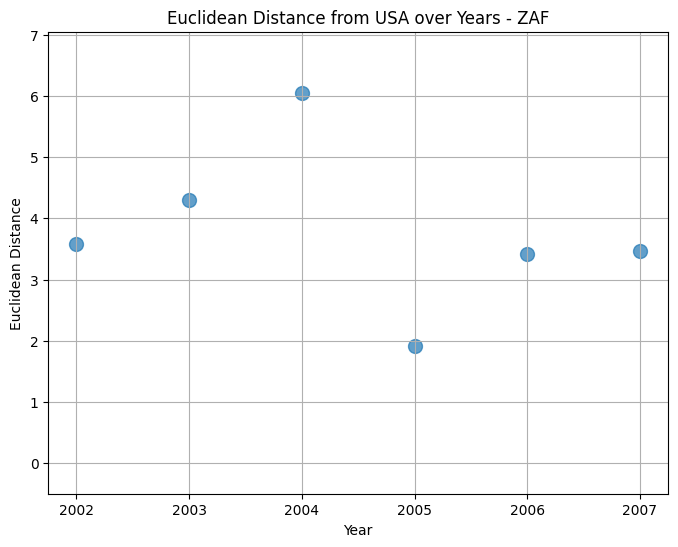

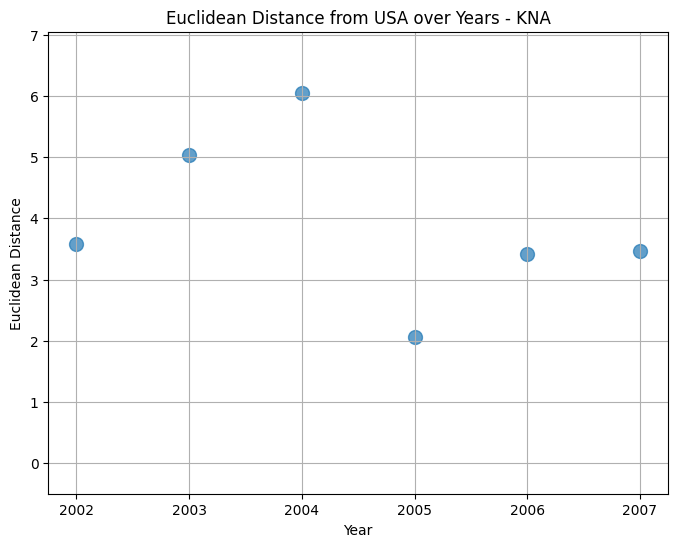

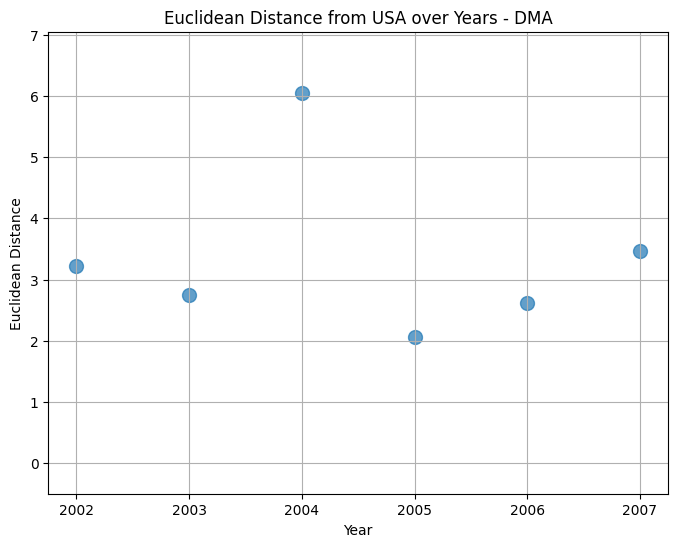

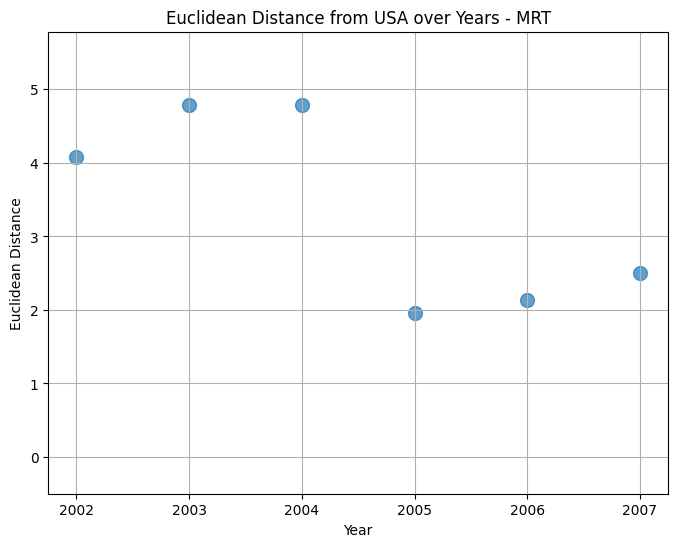

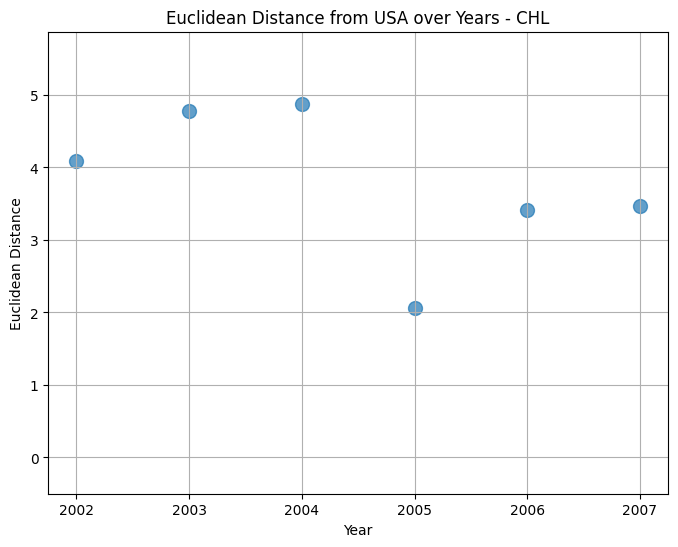

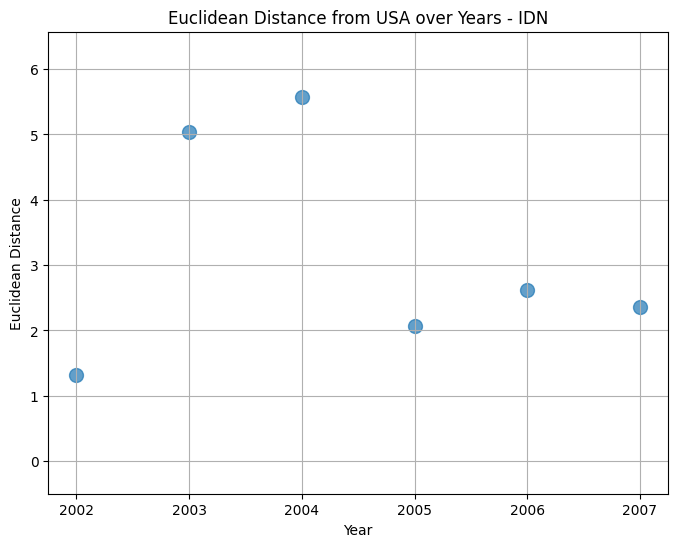

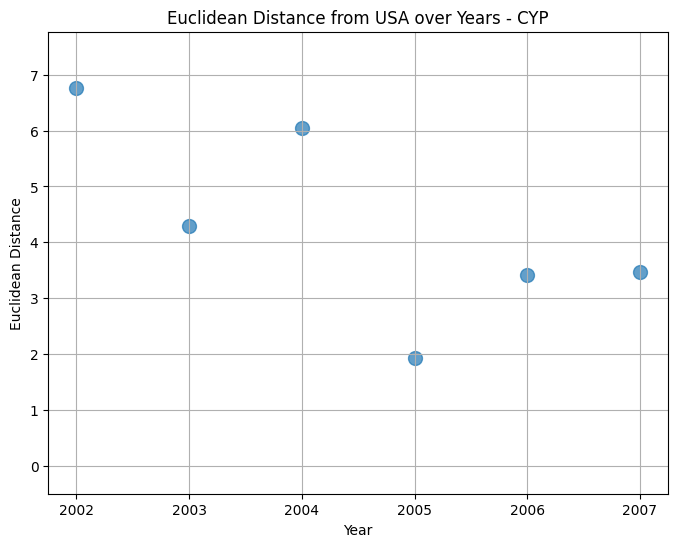

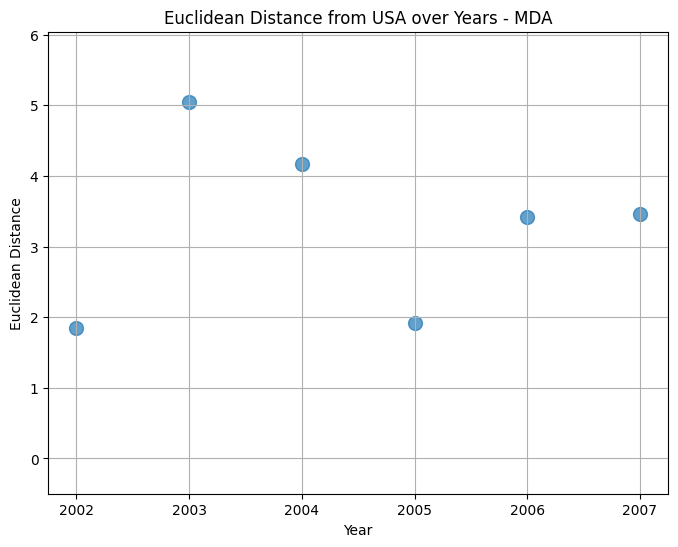

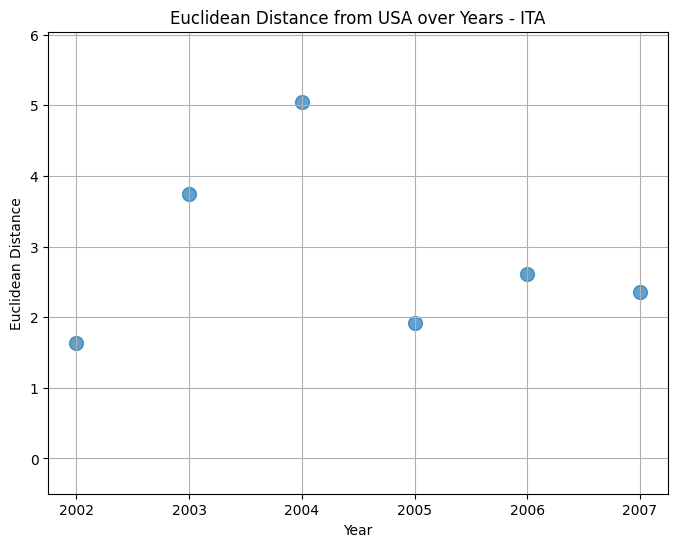

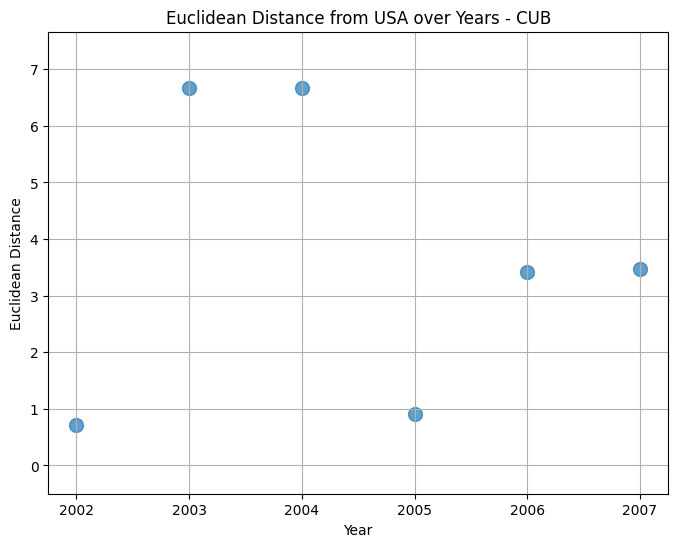

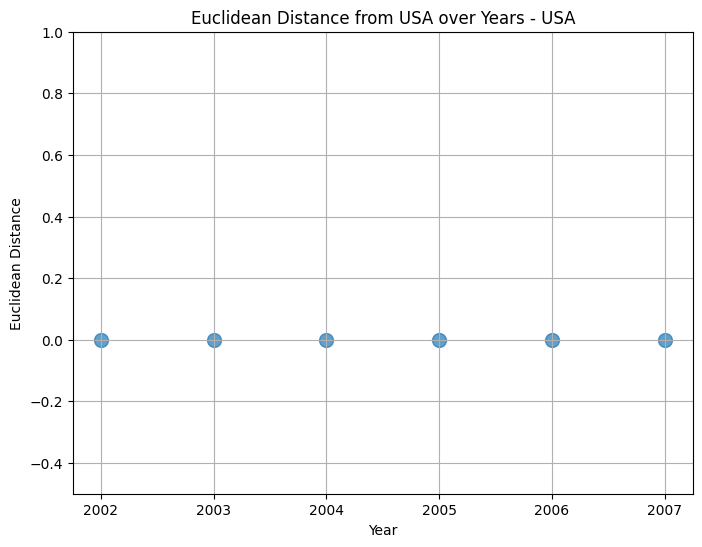

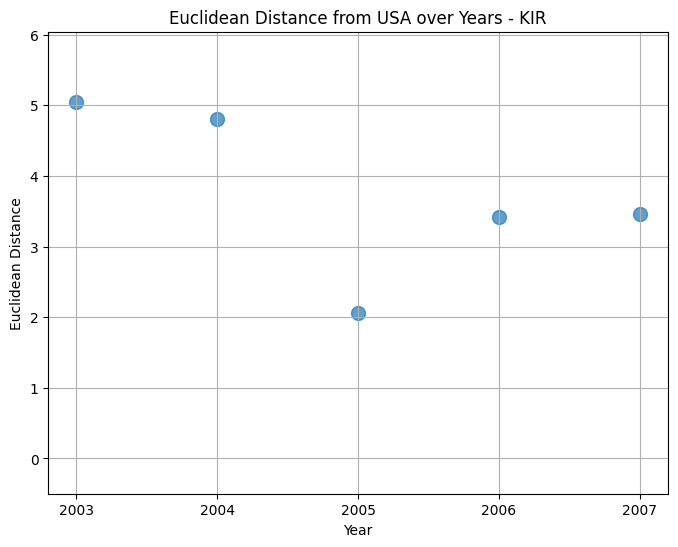

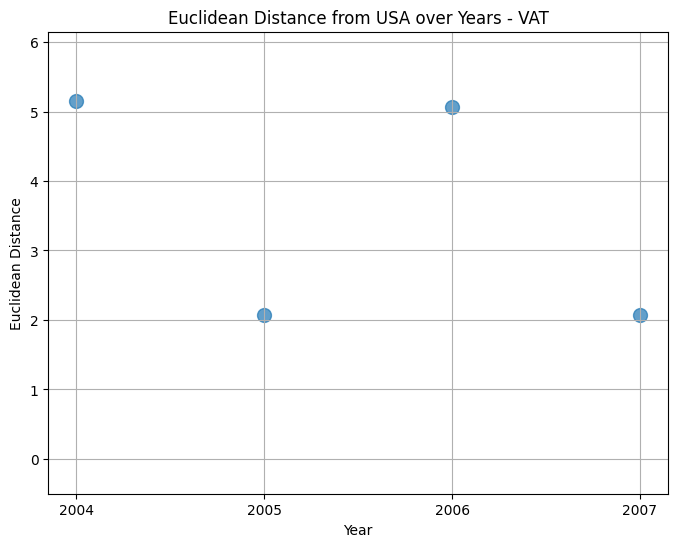

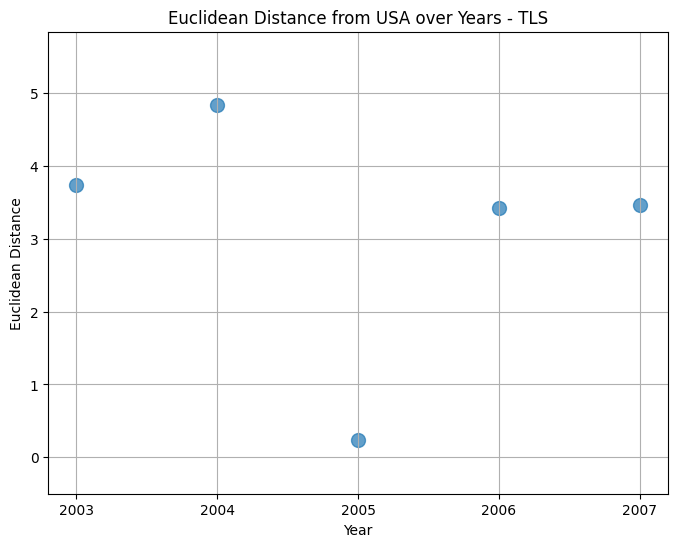

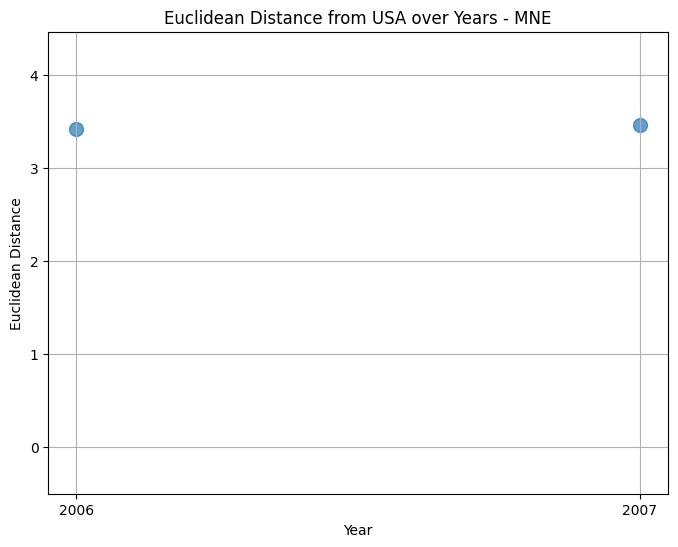

In [27]:
df_vectors['year'] = pd.to_numeric(df['year'])

# List of unique countries
countries = df_vectors['country'].unique()

# Create scatter plots for each country
for country in countries:
    # Filter the data for the current country
    country_data = df_vectors[df['country'] == country]
    
    # Create a new figure for each country
    plt.figure(figsize=(8, 6))
    
    # Create a scatter plot for the current country
    plt.scatter(country_data['year'], country_data['distance'], s=100, alpha=0.7)
    plt.xticks(ticks=country_data['year'].unique())
    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Euclidean Distance from USA over Years - {country}')
    plt.ylim(-0.5, max(country_data['distance']) + 1)
    plt.grid(True)
    
    # Show the plot for the current country
    plt.show()


In [109]:
import json

# Load your JSON data
with open('../data/processed/UN_data_with_narrative_answers.json', 'r') as file:
    data = json.load(file)

# Filter out the entries with the specified "Narrative_answers"
filtered_data = [
    entry for entry in data
    if entry.get("Narrative_answers") != {
        "1": "C",
        "2": "C",
        "3": "C",
        "4": "C",
        "5": "C",
        "6": "C"
    }
]

# Save the filtered data back to the JSON file
with open('../data/processed/UN_data_with_narrative_answers_relevant.json', 'w') as file:
    json.dump(filtered_data, file, indent=4)